In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "1:4"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 333290 images
Dataset type val label type: species


Loaded 43293 images
Dataset type test label type: species


Loaded 43520 images
Dataset type test label type: species


Loaded 5270 images


In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

1:4 etvcjp2m


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

trn_inp = []
trn_e_u = []
trn_e_v = []
trn_rcn = []
trn_tgt = []

val_inp = []
val_e_u = []
val_e_v = []
val_rcn = []
val_tgt = []

ind_inp = []
ind_e_u = []
ind_e_v = []
ind_rcn = []
ind_tgt = []

if ood_str:
    ood_inp = []
    ood_e_u = []
    ood_e_v = []
    ood_rcn = []
    ood_tgt = []

rnd_inp = []
rnd_e_u = []
rnd_e_v = []
rnd_rcn = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    trn_inp.extend(x.detach().cpu().numpy())
    trn_e_u.extend(e_u.detach().cpu().numpy())
    trn_e_v.extend(e_v.detach().cpu().numpy())
    trn_rcn.extend(rcn.detach().cpu().numpy())
    trn_tgt.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    val_inp.extend(x.detach().cpu().numpy())
    val_e_u.extend(e_u.detach().cpu().numpy())
    val_e_v.extend(e_v.detach().cpu().numpy())
    val_rcn.extend(rcn.detach().cpu().numpy())
    val_tgt.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    ind_inp.extend(x.detach().cpu().numpy())
    ind_e_u.extend(e_u.detach().cpu().numpy())
    ind_e_v.extend(e_v.detach().cpu().numpy())
    ind_rcn.extend(rcn.detach().cpu().numpy())
    ind_tgt.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ood_inp.extend(x.detach().cpu().numpy())
        ood_e_u.extend(e_u.detach().cpu().numpy())
        ood_e_v.extend(e_v.detach().cpu().numpy())
        ood_rcn.extend(rcn.detach().cpu().numpy())
        ood_tgt.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    rnd_inp.extend(x.detach().cpu().numpy())
    rnd_e_u.extend(e_u.detach().cpu().numpy())
    rnd_e_v.extend(e_v.detach().cpu().numpy())
    rnd_rcn.extend(rcn.detach().cpu().numpy())
print("test RnD - OK")

  0%|                                                                                                        | 0/5208 [00:00<?, ?it/s]

  0%|                                                                                                | 1/5208 [00:00<56:46,  1.53it/s]

  0%|                                                                                                | 3/5208 [00:00<18:16,  4.75it/s]

  0%|                                                                                                | 5/5208 [00:00<11:20,  7.65it/s]

  0%|▏                                                                                               | 7/5208 [00:00<08:28, 10.23it/s]

  0%|▏                                                                                               | 9/5208 [00:01<06:58, 12.43it/s]

  0%|▏                                                                                              | 11/5208 [00:01<06:06, 14.20it/s]

  0%|▏                                                                                              | 13/5208 [00:01<05:34, 15.55it/s]

  0%|▎                                                                                              | 15/5208 [00:01<05:13, 16.58it/s]

  0%|▎                                                                                              | 17/5208 [00:01<04:59, 17.34it/s]

  0%|▎                                                                                              | 19/5208 [00:01<04:50, 17.89it/s]

  0%|▍                                                                                              | 21/5208 [00:01<04:43, 18.29it/s]

  0%|▍                                                                                              | 23/5208 [00:01<04:39, 18.58it/s]

  0%|▍                                                                                              | 25/5208 [00:01<04:36, 18.77it/s]

  1%|▍                                                                                              | 27/5208 [00:02<04:34, 18.89it/s]

  1%|▌                                                                                              | 29/5208 [00:02<04:32, 18.99it/s]

  1%|▌                                                                                              | 31/5208 [00:02<04:31, 19.06it/s]

  1%|▌                                                                                              | 33/5208 [00:02<04:31, 19.09it/s]

  1%|▋                                                                                              | 35/5208 [00:02<04:30, 19.14it/s]

  1%|▋                                                                                              | 37/5208 [00:02<04:29, 19.19it/s]

  1%|▋                                                                                              | 39/5208 [00:02<04:29, 19.20it/s]

  1%|▋                                                                                              | 41/5208 [00:02<04:29, 19.19it/s]

  1%|▊                                                                                              | 43/5208 [00:02<04:28, 19.21it/s]

  1%|▊                                                                                              | 45/5208 [00:02<04:28, 19.22it/s]

  1%|▊                                                                                              | 47/5208 [00:03<04:28, 19.23it/s]

  1%|▉                                                                                              | 49/5208 [00:03<04:29, 19.17it/s]

  1%|▉                                                                                              | 51/5208 [00:03<04:28, 19.19it/s]

  1%|▉                                                                                              | 53/5208 [00:03<04:28, 19.19it/s]

  1%|█                                                                                              | 55/5208 [00:03<04:28, 19.17it/s]

  1%|█                                                                                              | 57/5208 [00:03<04:28, 19.19it/s]

  1%|█                                                                                              | 59/5208 [00:03<04:28, 19.20it/s]

  1%|█                                                                                              | 61/5208 [00:03<04:28, 19.19it/s]

  1%|█▏                                                                                             | 63/5208 [00:03<04:27, 19.20it/s]

  1%|█▏                                                                                             | 65/5208 [00:03<04:28, 19.19it/s]

  1%|█▏                                                                                             | 67/5208 [00:04<04:27, 19.22it/s]

  1%|█▎                                                                                             | 69/5208 [00:04<04:27, 19.24it/s]

  1%|█▎                                                                                             | 71/5208 [00:04<04:26, 19.28it/s]

  1%|█▎                                                                                             | 73/5208 [00:04<04:25, 19.31it/s]

  1%|█▎                                                                                             | 75/5208 [00:04<04:25, 19.31it/s]

  1%|█▍                                                                                             | 77/5208 [00:04<04:25, 19.34it/s]

  2%|█▍                                                                                             | 79/5208 [00:04<04:24, 19.39it/s]

  2%|█▍                                                                                             | 81/5208 [00:04<04:23, 19.43it/s]

  2%|█▌                                                                                             | 83/5208 [00:04<04:23, 19.44it/s]

  2%|█▌                                                                                             | 85/5208 [00:05<04:23, 19.46it/s]

  2%|█▌                                                                                             | 87/5208 [00:05<04:22, 19.47it/s]

  2%|█▌                                                                                             | 89/5208 [00:05<04:23, 19.44it/s]

  2%|█▋                                                                                             | 91/5208 [00:05<04:23, 19.42it/s]

  2%|█▋                                                                                             | 93/5208 [00:05<04:23, 19.40it/s]

  2%|█▋                                                                                             | 95/5208 [00:05<04:23, 19.39it/s]

  2%|█▊                                                                                             | 97/5208 [00:05<04:24, 19.33it/s]

  2%|█▊                                                                                             | 99/5208 [00:05<04:24, 19.31it/s]

  2%|█▊                                                                                            | 101/5208 [00:05<04:24, 19.28it/s]

  2%|█▊                                                                                            | 103/5208 [00:05<04:25, 19.24it/s]

  2%|█▉                                                                                            | 105/5208 [00:06<04:25, 19.25it/s]

  2%|█▉                                                                                            | 107/5208 [00:06<04:25, 19.23it/s]

  2%|█▉                                                                                            | 109/5208 [00:06<04:25, 19.22it/s]

  2%|██                                                                                            | 111/5208 [00:06<04:25, 19.20it/s]

  2%|██                                                                                            | 113/5208 [00:06<04:25, 19.21it/s]

  2%|██                                                                                            | 115/5208 [00:06<04:25, 19.19it/s]

  2%|██                                                                                            | 117/5208 [00:06<04:25, 19.17it/s]

  2%|██▏                                                                                           | 119/5208 [00:06<04:25, 19.18it/s]

  2%|██▏                                                                                           | 121/5208 [00:06<04:25, 19.18it/s]

  2%|██▏                                                                                           | 123/5208 [00:07<04:25, 19.19it/s]

  2%|██▎                                                                                           | 125/5208 [00:07<04:25, 19.17it/s]

  2%|██▎                                                                                           | 127/5208 [00:07<04:24, 19.22it/s]

  2%|██▎                                                                                           | 129/5208 [00:07<04:23, 19.25it/s]

  3%|██▎                                                                                           | 131/5208 [00:07<04:23, 19.25it/s]

  3%|██▍                                                                                           | 133/5208 [00:07<04:23, 19.27it/s]

  3%|██▍                                                                                           | 135/5208 [00:07<04:23, 19.28it/s]

  3%|██▍                                                                                           | 137/5208 [00:07<04:22, 19.29it/s]

  3%|██▌                                                                                           | 139/5208 [00:07<04:22, 19.28it/s]

  3%|██▌                                                                                           | 141/5208 [00:07<04:23, 19.23it/s]

  3%|██▌                                                                                           | 143/5208 [00:08<04:24, 19.17it/s]

  3%|██▌                                                                                           | 145/5208 [00:08<04:24, 19.15it/s]

  3%|██▋                                                                                           | 147/5208 [00:08<04:23, 19.18it/s]

  3%|██▋                                                                                           | 149/5208 [00:08<04:23, 19.18it/s]

  3%|██▋                                                                                           | 151/5208 [00:08<04:23, 19.20it/s]

  3%|██▊                                                                                           | 153/5208 [00:08<04:23, 19.16it/s]

  3%|██▊                                                                                           | 155/5208 [00:08<04:25, 19.05it/s]

  3%|██▊                                                                                           | 157/5208 [00:08<04:25, 19.05it/s]

  3%|██▊                                                                                           | 159/5208 [00:08<04:24, 19.08it/s]

  3%|██▉                                                                                           | 161/5208 [00:08<04:24, 19.08it/s]

  3%|██▉                                                                                           | 163/5208 [00:09<04:25, 19.00it/s]

  3%|██▉                                                                                           | 165/5208 [00:09<04:26, 18.94it/s]

  3%|███                                                                                           | 167/5208 [00:09<04:26, 18.92it/s]

  3%|███                                                                                           | 169/5208 [00:09<04:25, 18.94it/s]

  3%|███                                                                                           | 171/5208 [00:09<04:25, 18.95it/s]

  3%|███                                                                                           | 173/5208 [00:09<04:25, 18.93it/s]

  3%|███▏                                                                                          | 175/5208 [00:09<04:24, 19.00it/s]

  3%|███▏                                                                                          | 177/5208 [00:09<04:25, 18.96it/s]

  3%|███▏                                                                                          | 179/5208 [00:09<04:25, 18.96it/s]

  3%|███▎                                                                                          | 181/5208 [00:10<04:25, 18.96it/s]

  4%|███▎                                                                                          | 183/5208 [00:10<04:24, 18.99it/s]

  4%|███▎                                                                                          | 185/5208 [00:10<04:24, 18.99it/s]

  4%|███▍                                                                                          | 187/5208 [00:10<04:24, 18.98it/s]

  4%|███▍                                                                                          | 189/5208 [00:10<04:24, 18.98it/s]

  4%|███▍                                                                                          | 191/5208 [00:10<04:24, 18.98it/s]

  4%|███▍                                                                                          | 193/5208 [00:10<04:24, 18.97it/s]

  4%|███▌                                                                                          | 195/5208 [00:10<04:24, 18.95it/s]

  4%|███▌                                                                                          | 197/5208 [00:10<04:24, 18.93it/s]

  4%|███▌                                                                                          | 199/5208 [00:10<04:24, 18.93it/s]

  4%|███▋                                                                                          | 201/5208 [00:11<04:25, 18.85it/s]

  4%|███▋                                                                                          | 203/5208 [00:11<04:25, 18.85it/s]

  4%|███▋                                                                                          | 205/5208 [00:11<04:25, 18.85it/s]

  4%|███▋                                                                                          | 207/5208 [00:11<04:24, 18.88it/s]

  4%|███▊                                                                                          | 209/5208 [00:11<04:24, 18.88it/s]

  4%|███▊                                                                                          | 211/5208 [00:11<04:24, 18.92it/s]

  4%|███▊                                                                                          | 213/5208 [00:11<04:23, 18.95it/s]

  4%|███▉                                                                                          | 215/5208 [00:11<04:23, 18.98it/s]

  4%|███▉                                                                                          | 217/5208 [00:11<04:22, 18.99it/s]

  4%|███▉                                                                                          | 219/5208 [00:12<04:23, 18.95it/s]

  4%|███▉                                                                                          | 221/5208 [00:12<04:23, 18.92it/s]

  4%|████                                                                                          | 223/5208 [00:12<04:23, 18.90it/s]

  4%|████                                                                                          | 225/5208 [00:12<04:23, 18.90it/s]

  4%|████                                                                                          | 227/5208 [00:12<04:23, 18.89it/s]

  4%|████▏                                                                                         | 229/5208 [00:12<04:23, 18.87it/s]

  4%|████▏                                                                                         | 231/5208 [00:12<04:23, 18.85it/s]

  4%|████▏                                                                                         | 233/5208 [00:12<04:24, 18.84it/s]

  5%|████▏                                                                                         | 235/5208 [00:12<04:24, 18.83it/s]

  5%|████▎                                                                                         | 237/5208 [00:13<04:24, 18.81it/s]

  5%|████▎                                                                                         | 239/5208 [00:13<04:24, 18.79it/s]

  5%|████▎                                                                                         | 241/5208 [00:13<04:24, 18.77it/s]

  5%|████▍                                                                                         | 243/5208 [00:13<04:25, 18.74it/s]

  5%|████▍                                                                                         | 245/5208 [00:13<04:24, 18.76it/s]

  5%|████▍                                                                                         | 247/5208 [00:13<04:25, 18.67it/s]

  5%|████▍                                                                                         | 249/5208 [00:13<04:25, 18.69it/s]

  5%|████▌                                                                                         | 251/5208 [00:13<04:24, 18.73it/s]

  5%|████▌                                                                                         | 253/5208 [00:13<04:24, 18.75it/s]

  5%|████▌                                                                                         | 255/5208 [00:13<04:23, 18.78it/s]

  5%|████▋                                                                                         | 257/5208 [00:14<04:23, 18.82it/s]

  5%|████▋                                                                                         | 259/5208 [00:14<04:22, 18.84it/s]

  5%|████▋                                                                                         | 261/5208 [00:14<04:22, 18.85it/s]

  5%|████▋                                                                                         | 263/5208 [00:14<04:22, 18.86it/s]

  5%|████▊                                                                                         | 265/5208 [00:14<04:22, 18.85it/s]

  5%|████▊                                                                                         | 267/5208 [00:14<04:22, 18.84it/s]

  5%|████▊                                                                                         | 269/5208 [00:14<04:21, 18.85it/s]

  5%|████▉                                                                                         | 271/5208 [00:14<04:24, 18.70it/s]

  5%|████▉                                                                                         | 273/5208 [00:14<04:23, 18.73it/s]

  5%|████▉                                                                                         | 275/5208 [00:15<04:21, 18.84it/s]

  5%|████▉                                                                                         | 277/5208 [00:15<04:20, 18.92it/s]

  5%|█████                                                                                         | 279/5208 [00:15<04:19, 18.97it/s]

  5%|█████                                                                                         | 281/5208 [00:15<04:19, 18.97it/s]

  5%|█████                                                                                         | 283/5208 [00:15<04:19, 19.01it/s]

  5%|█████▏                                                                                        | 285/5208 [00:15<04:18, 19.06it/s]

  6%|█████▏                                                                                        | 287/5208 [00:15<04:18, 19.04it/s]

  6%|█████▏                                                                                        | 289/5208 [00:15<04:18, 19.05it/s]

  6%|█████▎                                                                                        | 291/5208 [00:15<04:17, 19.09it/s]

  6%|█████▎                                                                                        | 293/5208 [00:15<04:18, 19.01it/s]

  6%|█████▎                                                                                        | 295/5208 [00:16<04:19, 18.91it/s]

  6%|█████▎                                                                                        | 297/5208 [00:16<04:18, 18.97it/s]

  6%|█████▍                                                                                        | 299/5208 [00:16<04:18, 19.01it/s]

  6%|█████▍                                                                                        | 301/5208 [00:16<04:17, 19.03it/s]

  6%|█████▍                                                                                        | 303/5208 [00:16<04:17, 19.07it/s]

  6%|█████▌                                                                                        | 305/5208 [00:16<04:17, 19.07it/s]

  6%|█████▌                                                                                        | 307/5208 [00:16<04:17, 19.03it/s]

  6%|█████▌                                                                                        | 309/5208 [00:16<04:17, 19.03it/s]

  6%|█████▌                                                                                        | 311/5208 [00:16<04:17, 19.02it/s]

  6%|█████▋                                                                                        | 313/5208 [00:17<04:17, 19.03it/s]

  6%|█████▋                                                                                        | 315/5208 [00:17<04:17, 19.03it/s]

  6%|█████▋                                                                                        | 317/5208 [00:17<04:17, 19.02it/s]

  6%|█████▊                                                                                        | 319/5208 [00:17<04:17, 18.97it/s]

  6%|█████▊                                                                                        | 321/5208 [00:17<04:17, 18.96it/s]

  6%|█████▊                                                                                        | 323/5208 [00:17<04:17, 18.99it/s]

  6%|█████▊                                                                                        | 325/5208 [00:17<04:16, 19.02it/s]

  6%|█████▉                                                                                        | 327/5208 [00:17<04:16, 19.03it/s]

  6%|█████▉                                                                                        | 329/5208 [00:17<04:16, 19.02it/s]

  6%|█████▉                                                                                        | 331/5208 [00:17<04:16, 19.02it/s]

  6%|██████                                                                                        | 333/5208 [00:18<04:16, 19.03it/s]

  6%|██████                                                                                        | 335/5208 [00:18<04:14, 19.12it/s]

  6%|██████                                                                                        | 337/5208 [00:18<04:14, 19.18it/s]

  7%|██████                                                                                        | 339/5208 [00:18<04:13, 19.24it/s]

  7%|██████▏                                                                                       | 341/5208 [00:18<04:12, 19.27it/s]

  7%|██████▏                                                                                       | 343/5208 [00:18<04:12, 19.27it/s]

  7%|██████▏                                                                                       | 345/5208 [00:18<04:12, 19.29it/s]

  7%|██████▎                                                                                       | 347/5208 [00:18<04:11, 19.31it/s]

  7%|██████▎                                                                                       | 349/5208 [00:18<04:11, 19.33it/s]

  7%|██████▎                                                                                       | 351/5208 [00:19<04:11, 19.32it/s]

  7%|██████▎                                                                                       | 353/5208 [00:19<04:11, 19.32it/s]

  7%|██████▍                                                                                       | 355/5208 [00:19<04:10, 19.34it/s]

  7%|██████▍                                                                                       | 357/5208 [00:19<04:11, 19.30it/s]

  7%|██████▍                                                                                       | 359/5208 [00:19<04:10, 19.32it/s]

  7%|██████▌                                                                                       | 361/5208 [00:19<04:10, 19.34it/s]

  7%|██████▌                                                                                       | 363/5208 [00:19<04:10, 19.33it/s]

  7%|██████▌                                                                                       | 365/5208 [00:19<04:10, 19.31it/s]

  7%|██████▌                                                                                       | 367/5208 [00:19<04:10, 19.32it/s]

  7%|██████▋                                                                                       | 369/5208 [00:19<04:10, 19.32it/s]

  7%|██████▋                                                                                       | 371/5208 [00:20<04:10, 19.30it/s]

  7%|██████▋                                                                                       | 373/5208 [00:20<04:10, 19.31it/s]

  7%|██████▊                                                                                       | 375/5208 [00:20<04:10, 19.33it/s]

  7%|██████▊                                                                                       | 377/5208 [00:20<04:09, 19.34it/s]

  7%|██████▊                                                                                       | 379/5208 [00:20<04:09, 19.32it/s]

  7%|██████▉                                                                                       | 381/5208 [00:20<04:09, 19.34it/s]

  7%|██████▉                                                                                       | 383/5208 [00:20<04:09, 19.35it/s]

  7%|██████▉                                                                                       | 385/5208 [00:20<04:09, 19.30it/s]

  7%|██████▉                                                                                       | 387/5208 [00:20<04:10, 19.23it/s]

  7%|███████                                                                                       | 389/5208 [00:20<04:11, 19.18it/s]

  8%|███████                                                                                       | 391/5208 [00:21<04:10, 19.21it/s]

  8%|███████                                                                                       | 393/5208 [00:21<04:10, 19.22it/s]

  8%|███████▏                                                                                      | 395/5208 [00:21<04:09, 19.25it/s]

  8%|███████▏                                                                                      | 397/5208 [00:21<04:09, 19.27it/s]

  8%|███████▏                                                                                      | 399/5208 [00:21<04:09, 19.29it/s]

  8%|███████▏                                                                                      | 401/5208 [00:21<04:09, 19.28it/s]

  8%|███████▎                                                                                      | 403/5208 [00:21<04:09, 19.28it/s]

  8%|███████▎                                                                                      | 405/5208 [00:21<04:09, 19.27it/s]

  8%|███████▎                                                                                      | 407/5208 [00:21<04:09, 19.27it/s]

  8%|███████▍                                                                                      | 409/5208 [00:22<04:08, 19.28it/s]

  8%|███████▍                                                                                      | 411/5208 [00:22<04:08, 19.30it/s]

  8%|███████▍                                                                                      | 413/5208 [00:22<04:08, 19.30it/s]

  8%|███████▍                                                                                      | 415/5208 [00:22<04:08, 19.27it/s]

  8%|███████▌                                                                                      | 417/5208 [00:22<04:08, 19.29it/s]

  8%|███████▌                                                                                      | 419/5208 [00:22<04:07, 19.31it/s]

  8%|███████▌                                                                                      | 421/5208 [00:22<04:07, 19.31it/s]

  8%|███████▋                                                                                      | 423/5208 [00:22<04:07, 19.30it/s]

  8%|███████▋                                                                                      | 425/5208 [00:22<04:07, 19.29it/s]

  8%|███████▋                                                                                      | 427/5208 [00:22<04:07, 19.30it/s]

  8%|███████▋                                                                                      | 429/5208 [00:23<04:07, 19.29it/s]

  8%|███████▊                                                                                      | 431/5208 [00:23<04:07, 19.29it/s]

  8%|███████▊                                                                                      | 433/5208 [00:23<04:07, 19.30it/s]

  8%|███████▊                                                                                      | 435/5208 [00:23<04:07, 19.28it/s]

  8%|███████▉                                                                                      | 437/5208 [00:23<04:07, 19.29it/s]

  8%|███████▉                                                                                      | 439/5208 [00:23<04:07, 19.30it/s]

  8%|███████▉                                                                                      | 441/5208 [00:23<04:06, 19.30it/s]

  9%|███████▉                                                                                      | 443/5208 [00:23<04:07, 19.28it/s]

  9%|████████                                                                                      | 445/5208 [00:23<04:06, 19.29it/s]

  9%|████████                                                                                      | 447/5208 [00:23<04:06, 19.30it/s]

  9%|████████                                                                                      | 449/5208 [00:24<04:06, 19.29it/s]

  9%|████████▏                                                                                     | 451/5208 [00:24<04:06, 19.30it/s]

  9%|████████▏                                                                                     | 453/5208 [00:24<04:06, 19.30it/s]

  9%|████████▏                                                                                     | 455/5208 [00:24<04:06, 19.30it/s]

  9%|████████▏                                                                                     | 457/5208 [00:24<04:06, 19.28it/s]

  9%|████████▎                                                                                     | 459/5208 [00:24<04:06, 19.29it/s]

  9%|████████▎                                                                                     | 461/5208 [00:24<04:05, 19.31it/s]

  9%|████████▎                                                                                     | 463/5208 [00:24<04:06, 19.28it/s]

  9%|████████▍                                                                                     | 465/5208 [00:24<04:05, 19.29it/s]

  9%|████████▍                                                                                     | 467/5208 [00:25<04:05, 19.31it/s]

  9%|████████▍                                                                                     | 469/5208 [00:25<04:05, 19.30it/s]

  9%|████████▌                                                                                     | 471/5208 [00:25<04:05, 19.29it/s]

  9%|████████▌                                                                                     | 473/5208 [00:25<04:05, 19.31it/s]

  9%|████████▌                                                                                     | 475/5208 [00:25<04:05, 19.30it/s]

  9%|████████▌                                                                                     | 477/5208 [00:25<04:05, 19.30it/s]

  9%|████████▋                                                                                     | 479/5208 [00:25<04:05, 19.29it/s]

  9%|████████▋                                                                                     | 481/5208 [00:25<04:04, 19.32it/s]

  9%|████████▋                                                                                     | 483/5208 [00:25<04:04, 19.33it/s]

  9%|████████▊                                                                                     | 485/5208 [00:25<04:04, 19.31it/s]

  9%|████████▊                                                                                     | 487/5208 [00:26<04:04, 19.33it/s]

  9%|████████▊                                                                                     | 489/5208 [00:26<04:04, 19.33it/s]

  9%|████████▊                                                                                     | 491/5208 [00:26<04:03, 19.33it/s]

  9%|████████▉                                                                                     | 493/5208 [00:26<04:04, 19.30it/s]

 10%|████████▉                                                                                     | 495/5208 [00:26<04:04, 19.31it/s]

 10%|████████▉                                                                                     | 497/5208 [00:26<04:03, 19.32it/s]

 10%|█████████                                                                                     | 499/5208 [00:26<04:04, 19.29it/s]

 10%|█████████                                                                                     | 501/5208 [00:26<04:03, 19.31it/s]

 10%|█████████                                                                                     | 503/5208 [00:26<04:03, 19.31it/s]

 10%|█████████                                                                                     | 505/5208 [00:26<04:03, 19.30it/s]

 10%|█████████▏                                                                                    | 507/5208 [00:27<04:03, 19.28it/s]

 10%|█████████▏                                                                                    | 509/5208 [00:27<04:03, 19.29it/s]

 10%|█████████▏                                                                                    | 511/5208 [00:27<04:03, 19.27it/s]

 10%|█████████▎                                                                                    | 513/5208 [00:27<04:03, 19.27it/s]

 10%|█████████▎                                                                                    | 515/5208 [00:27<04:03, 19.29it/s]

 10%|█████████▎                                                                                    | 517/5208 [00:27<04:03, 19.28it/s]

 10%|█████████▎                                                                                    | 519/5208 [00:27<04:03, 19.30it/s]

 10%|█████████▍                                                                                    | 521/5208 [00:27<04:02, 19.30it/s]

 10%|█████████▍                                                                                    | 523/5208 [00:27<04:02, 19.31it/s]

 10%|█████████▍                                                                                    | 525/5208 [00:28<04:02, 19.30it/s]

 10%|█████████▌                                                                                    | 527/5208 [00:28<04:02, 19.30it/s]

 10%|█████████▌                                                                                    | 529/5208 [00:28<04:02, 19.31it/s]

 10%|█████████▌                                                                                    | 531/5208 [00:28<04:02, 19.26it/s]

 10%|█████████▌                                                                                    | 533/5208 [00:28<04:02, 19.27it/s]

 10%|█████████▋                                                                                    | 535/5208 [00:28<04:02, 19.30it/s]

 10%|█████████▋                                                                                    | 537/5208 [00:28<04:01, 19.30it/s]

 10%|█████████▋                                                                                    | 539/5208 [00:28<04:02, 19.27it/s]

 10%|█████████▊                                                                                    | 541/5208 [00:28<04:01, 19.31it/s]

 10%|█████████▊                                                                                    | 543/5208 [00:28<04:01, 19.33it/s]

 10%|█████████▊                                                                                    | 545/5208 [00:29<04:01, 19.32it/s]

 11%|█████████▊                                                                                    | 547/5208 [00:29<04:00, 19.34it/s]

 11%|█████████▉                                                                                    | 549/5208 [00:29<04:00, 19.34it/s]

 11%|█████████▉                                                                                    | 551/5208 [00:29<04:00, 19.33it/s]

 11%|█████████▉                                                                                    | 553/5208 [00:29<04:01, 19.30it/s]

 11%|██████████                                                                                    | 555/5208 [00:29<04:00, 19.32it/s]

 11%|██████████                                                                                    | 557/5208 [00:29<04:00, 19.34it/s]

 11%|██████████                                                                                    | 559/5208 [00:29<04:00, 19.30it/s]

 11%|██████████▏                                                                                   | 561/5208 [00:29<04:00, 19.31it/s]

 11%|██████████▏                                                                                   | 563/5208 [00:29<04:00, 19.32it/s]

 11%|██████████▏                                                                                   | 565/5208 [00:30<04:00, 19.33it/s]

 11%|██████████▏                                                                                   | 567/5208 [00:30<04:00, 19.31it/s]

 11%|██████████▎                                                                                   | 569/5208 [00:30<04:00, 19.32it/s]

 11%|██████████▎                                                                                   | 571/5208 [00:30<03:59, 19.34it/s]

 11%|██████████▎                                                                                   | 573/5208 [00:30<03:59, 19.32it/s]

 11%|██████████▍                                                                                   | 575/5208 [00:30<04:00, 19.30it/s]

 11%|██████████▍                                                                                   | 577/5208 [00:30<03:59, 19.31it/s]

 11%|██████████▍                                                                                   | 579/5208 [00:30<03:59, 19.31it/s]

 11%|██████████▍                                                                                   | 581/5208 [00:30<03:59, 19.32it/s]

 11%|██████████▌                                                                                   | 583/5208 [00:31<03:59, 19.31it/s]

 11%|██████████▌                                                                                   | 585/5208 [00:31<03:59, 19.32it/s]

 11%|██████████▌                                                                                   | 587/5208 [00:31<03:59, 19.33it/s]

 11%|██████████▋                                                                                   | 589/5208 [00:31<03:58, 19.34it/s]

 11%|██████████▋                                                                                   | 591/5208 [00:31<03:58, 19.32it/s]

 11%|██████████▋                                                                                   | 593/5208 [00:31<03:58, 19.33it/s]

 11%|██████████▋                                                                                   | 595/5208 [00:31<03:58, 19.34it/s]

 11%|██████████▊                                                                                   | 597/5208 [00:31<03:58, 19.32it/s]

 12%|██████████▊                                                                                   | 599/5208 [00:31<03:58, 19.31it/s]

 12%|██████████▊                                                                                   | 601/5208 [00:31<03:58, 19.31it/s]

 12%|██████████▉                                                                                   | 603/5208 [00:32<03:58, 19.32it/s]

 12%|██████████▉                                                                                   | 605/5208 [00:32<03:58, 19.31it/s]

 12%|██████████▉                                                                                   | 607/5208 [00:32<03:58, 19.31it/s]

 12%|██████████▉                                                                                   | 609/5208 [00:32<03:57, 19.32it/s]

 12%|███████████                                                                                   | 611/5208 [00:32<03:57, 19.33it/s]

 12%|███████████                                                                                   | 613/5208 [00:32<03:57, 19.31it/s]

 12%|███████████                                                                                   | 615/5208 [00:32<03:57, 19.32it/s]

 12%|███████████▏                                                                                  | 617/5208 [00:32<03:57, 19.34it/s]

 12%|███████████▏                                                                                  | 619/5208 [00:32<03:57, 19.31it/s]

 12%|███████████▏                                                                                  | 621/5208 [00:32<03:57, 19.32it/s]

 12%|███████████▏                                                                                  | 623/5208 [00:33<03:57, 19.32it/s]

 12%|███████████▎                                                                                  | 625/5208 [00:33<03:57, 19.33it/s]

 12%|███████████▎                                                                                  | 627/5208 [00:33<03:56, 19.33it/s]

 12%|███████████▎                                                                                  | 629/5208 [00:33<03:56, 19.33it/s]

 12%|███████████▍                                                                                  | 631/5208 [00:33<03:56, 19.34it/s]

 12%|███████████▍                                                                                  | 633/5208 [00:33<03:56, 19.35it/s]

 12%|███████████▍                                                                                  | 635/5208 [00:33<03:56, 19.33it/s]

 12%|███████████▍                                                                                  | 637/5208 [00:33<03:56, 19.33it/s]

 12%|███████████▌                                                                                  | 639/5208 [00:33<03:56, 19.32it/s]

 12%|███████████▌                                                                                  | 641/5208 [00:34<03:56, 19.28it/s]

 12%|███████████▌                                                                                  | 643/5208 [00:34<03:56, 19.28it/s]

 12%|███████████▋                                                                                  | 645/5208 [00:34<03:56, 19.29it/s]

 12%|███████████▋                                                                                  | 647/5208 [00:34<03:56, 19.27it/s]

 12%|███████████▋                                                                                  | 649/5208 [00:34<03:56, 19.29it/s]

 12%|███████████▊                                                                                  | 651/5208 [00:34<03:55, 19.31it/s]

 13%|███████████▊                                                                                  | 653/5208 [00:34<03:55, 19.32it/s]

 13%|███████████▊                                                                                  | 655/5208 [00:34<03:55, 19.30it/s]

 13%|███████████▊                                                                                  | 657/5208 [00:34<03:55, 19.30it/s]

 13%|███████████▉                                                                                  | 659/5208 [00:34<03:55, 19.31it/s]

 13%|███████████▉                                                                                  | 661/5208 [00:35<03:55, 19.32it/s]

 13%|███████████▉                                                                                  | 663/5208 [00:35<03:55, 19.32it/s]

 13%|████████████                                                                                  | 665/5208 [00:35<03:55, 19.30it/s]

 13%|████████████                                                                                  | 667/5208 [00:35<03:55, 19.31it/s]

 13%|████████████                                                                                  | 669/5208 [00:35<03:55, 19.31it/s]

 13%|████████████                                                                                  | 671/5208 [00:35<03:55, 19.30it/s]

 13%|████████████▏                                                                                 | 673/5208 [00:35<03:54, 19.31it/s]

 13%|████████████▏                                                                                 | 675/5208 [00:35<03:54, 19.32it/s]

 13%|████████████▏                                                                                 | 677/5208 [00:35<03:54, 19.32it/s]

 13%|████████████▎                                                                                 | 679/5208 [00:35<03:54, 19.31it/s]

 13%|████████████▎                                                                                 | 681/5208 [00:36<03:54, 19.32it/s]

 13%|████████████▎                                                                                 | 683/5208 [00:36<03:54, 19.33it/s]

 13%|████████████▎                                                                                 | 685/5208 [00:36<03:53, 19.34it/s]

 13%|████████████▍                                                                                 | 687/5208 [00:36<03:53, 19.33it/s]

 13%|████████████▍                                                                                 | 689/5208 [00:36<03:53, 19.34it/s]

 13%|████████████▍                                                                                 | 691/5208 [00:36<03:53, 19.35it/s]

 13%|████████████▌                                                                                 | 693/5208 [00:36<03:53, 19.33it/s]

 13%|████████████▌                                                                                 | 695/5208 [00:36<03:53, 19.34it/s]

 13%|████████████▌                                                                                 | 697/5208 [00:36<03:53, 19.33it/s]

 13%|████████████▌                                                                                 | 699/5208 [00:37<03:53, 19.33it/s]

 13%|████████████▋                                                                                 | 701/5208 [00:37<03:53, 19.30it/s]

 13%|████████████▋                                                                                 | 703/5208 [00:37<03:53, 19.31it/s]

 14%|████████████▋                                                                                 | 705/5208 [00:37<03:53, 19.32it/s]

 14%|████████████▊                                                                                 | 707/5208 [00:37<03:53, 19.30it/s]

 14%|████████████▊                                                                                 | 709/5208 [00:37<03:52, 19.31it/s]

 14%|████████████▊                                                                                 | 711/5208 [00:37<03:53, 19.30it/s]

 14%|████████████▊                                                                                 | 713/5208 [00:37<03:52, 19.31it/s]

 14%|████████████▉                                                                                 | 715/5208 [00:37<03:52, 19.29it/s]

 14%|████████████▉                                                                                 | 717/5208 [00:37<03:52, 19.30it/s]

 14%|████████████▉                                                                                 | 719/5208 [00:38<03:52, 19.29it/s]

 14%|█████████████                                                                                 | 721/5208 [00:38<03:52, 19.27it/s]

 14%|█████████████                                                                                 | 723/5208 [00:38<03:52, 19.28it/s]

 14%|█████████████                                                                                 | 725/5208 [00:38<03:52, 19.29it/s]

 14%|█████████████                                                                                 | 727/5208 [00:38<03:52, 19.26it/s]

 14%|█████████████▏                                                                                | 729/5208 [00:38<03:52, 19.28it/s]

 14%|█████████████▏                                                                                | 731/5208 [00:38<03:52, 19.28it/s]

 14%|█████████████▏                                                                                | 733/5208 [00:38<03:51, 19.30it/s]

 14%|█████████████▎                                                                                | 735/5208 [00:38<03:51, 19.30it/s]

 14%|█████████████▎                                                                                | 737/5208 [00:39<03:51, 19.28it/s]

 14%|█████████████▎                                                                                | 739/5208 [00:39<03:51, 19.30it/s]

 14%|█████████████▎                                                                                | 741/5208 [00:39<03:51, 19.30it/s]

 14%|█████████████▍                                                                                | 743/5208 [00:39<03:51, 19.31it/s]

 14%|█████████████▍                                                                                | 745/5208 [00:39<03:51, 19.30it/s]

 14%|█████████████▍                                                                                | 747/5208 [00:39<03:50, 19.33it/s]

 14%|█████████████▌                                                                                | 749/5208 [00:39<03:50, 19.34it/s]

 14%|█████████████▌                                                                                | 751/5208 [00:39<03:50, 19.33it/s]

 14%|█████████████▌                                                                                | 753/5208 [00:39<03:50, 19.35it/s]

 14%|█████████████▋                                                                                | 755/5208 [00:39<03:50, 19.34it/s]

 15%|█████████████▋                                                                                | 757/5208 [00:40<03:50, 19.34it/s]

 15%|█████████████▋                                                                                | 759/5208 [00:40<03:50, 19.30it/s]

 15%|█████████████▋                                                                                | 761/5208 [00:40<03:50, 19.33it/s]

 15%|█████████████▊                                                                                | 763/5208 [00:40<03:49, 19.36it/s]

 15%|█████████████▊                                                                                | 765/5208 [00:40<03:49, 19.36it/s]

 15%|█████████████▊                                                                                | 767/5208 [00:40<03:49, 19.34it/s]

 15%|█████████████▉                                                                                | 769/5208 [00:40<03:49, 19.37it/s]

 15%|█████████████▉                                                                                | 771/5208 [00:40<03:49, 19.36it/s]

 15%|█████████████▉                                                                                | 773/5208 [00:40<03:49, 19.33it/s]

 15%|█████████████▉                                                                                | 775/5208 [00:40<03:49, 19.34it/s]

 15%|██████████████                                                                                | 777/5208 [00:41<03:48, 19.36it/s]

 15%|██████████████                                                                                | 779/5208 [00:41<03:48, 19.39it/s]

 15%|██████████████                                                                                | 781/5208 [00:41<03:48, 19.34it/s]

 15%|██████████████▏                                                                               | 783/5208 [00:41<03:48, 19.34it/s]

 15%|██████████████▏                                                                               | 785/5208 [00:41<03:48, 19.34it/s]

 15%|██████████████▏                                                                               | 787/5208 [00:41<03:49, 19.30it/s]

 15%|██████████████▏                                                                               | 789/5208 [00:41<03:49, 19.30it/s]

 15%|██████████████▎                                                                               | 791/5208 [00:41<03:48, 19.30it/s]

 15%|██████████████▎                                                                               | 793/5208 [00:41<03:48, 19.31it/s]

 15%|██████████████▎                                                                               | 795/5208 [00:42<03:48, 19.29it/s]

 15%|██████████████▍                                                                               | 797/5208 [00:42<03:48, 19.28it/s]

 15%|██████████████▍                                                                               | 799/5208 [00:42<03:48, 19.28it/s]

 15%|██████████████▍                                                                               | 801/5208 [00:42<03:48, 19.25it/s]

 15%|██████████████▍                                                                               | 803/5208 [00:42<03:48, 19.25it/s]

 15%|██████████████▌                                                                               | 805/5208 [00:42<03:48, 19.26it/s]

 15%|██████████████▌                                                                               | 807/5208 [00:42<03:48, 19.28it/s]

 16%|██████████████▌                                                                               | 809/5208 [00:42<03:47, 19.29it/s]

 16%|██████████████▋                                                                               | 811/5208 [00:42<03:47, 19.33it/s]

 16%|██████████████▋                                                                               | 813/5208 [00:42<03:47, 19.35it/s]

 16%|██████████████▋                                                                               | 815/5208 [00:43<03:47, 19.32it/s]

 16%|██████████████▋                                                                               | 817/5208 [00:43<03:47, 19.29it/s]

 16%|██████████████▊                                                                               | 819/5208 [00:43<03:48, 19.20it/s]

 16%|██████████████▊                                                                               | 821/5208 [00:43<03:48, 19.16it/s]

 16%|██████████████▊                                                                               | 823/5208 [00:43<03:48, 19.18it/s]

 16%|██████████████▉                                                                               | 825/5208 [00:43<03:48, 19.18it/s]

 16%|██████████████▉                                                                               | 827/5208 [00:43<03:48, 19.17it/s]

 16%|██████████████▉                                                                               | 829/5208 [00:43<03:48, 19.15it/s]

 16%|██████████████▉                                                                               | 831/5208 [00:43<03:48, 19.14it/s]

 16%|███████████████                                                                               | 833/5208 [00:43<03:48, 19.14it/s]

 16%|███████████████                                                                               | 835/5208 [00:44<03:48, 19.14it/s]

 16%|███████████████                                                                               | 837/5208 [00:44<03:48, 19.15it/s]

 16%|███████████████▏                                                                              | 839/5208 [00:44<03:48, 19.12it/s]

 16%|███████████████▏                                                                              | 841/5208 [00:44<03:48, 19.07it/s]

 16%|███████████████▏                                                                              | 843/5208 [00:44<03:48, 19.07it/s]

 16%|███████████████▎                                                                              | 845/5208 [00:44<03:48, 19.08it/s]

 16%|███████████████▎                                                                              | 847/5208 [00:44<03:48, 19.09it/s]

 16%|███████████████▎                                                                              | 849/5208 [00:44<03:47, 19.13it/s]

 16%|███████████████▎                                                                              | 851/5208 [00:44<03:47, 19.13it/s]

 16%|███████████████▍                                                                              | 853/5208 [00:45<03:47, 19.16it/s]

 16%|███████████████▍                                                                              | 855/5208 [00:45<03:46, 19.25it/s]

 16%|███████████████▍                                                                              | 857/5208 [00:45<03:45, 19.33it/s]

 16%|███████████████▌                                                                              | 859/5208 [00:45<03:44, 19.39it/s]

 17%|███████████████▌                                                                              | 861/5208 [00:45<03:43, 19.43it/s]

 17%|███████████████▌                                                                              | 863/5208 [00:45<03:43, 19.46it/s]

 17%|███████████████▌                                                                              | 865/5208 [00:45<03:42, 19.50it/s]

 17%|███████████████▋                                                                              | 867/5208 [00:45<03:42, 19.50it/s]

 17%|███████████████▋                                                                              | 869/5208 [00:45<03:42, 19.52it/s]

 17%|███████████████▋                                                                              | 871/5208 [00:45<03:42, 19.53it/s]

 17%|███████████████▊                                                                              | 873/5208 [00:46<03:41, 19.54it/s]

 17%|███████████████▊                                                                              | 875/5208 [00:46<03:41, 19.55it/s]

 17%|███████████████▊                                                                              | 877/5208 [00:46<03:41, 19.55it/s]

 17%|███████████████▊                                                                              | 879/5208 [00:46<03:41, 19.56it/s]

 17%|███████████████▉                                                                              | 881/5208 [00:46<03:41, 19.56it/s]

 17%|███████████████▉                                                                              | 883/5208 [00:46<03:41, 19.56it/s]

 17%|███████████████▉                                                                              | 885/5208 [00:46<03:41, 19.55it/s]

 17%|████████████████                                                                              | 887/5208 [00:46<03:41, 19.55it/s]

 17%|████████████████                                                                              | 889/5208 [00:46<03:40, 19.55it/s]

 17%|████████████████                                                                              | 891/5208 [00:46<03:40, 19.55it/s]

 17%|████████████████                                                                              | 893/5208 [00:47<03:40, 19.55it/s]

 17%|████████████████▏                                                                             | 895/5208 [00:47<03:40, 19.55it/s]

 17%|████████████████▏                                                                             | 897/5208 [00:47<03:40, 19.54it/s]

 17%|████████████████▏                                                                             | 899/5208 [00:47<03:40, 19.55it/s]

 17%|████████████████▎                                                                             | 901/5208 [00:47<03:40, 19.55it/s]

 17%|████████████████▎                                                                             | 903/5208 [00:47<03:40, 19.55it/s]

 17%|████████████████▎                                                                             | 905/5208 [00:47<03:40, 19.54it/s]

 17%|████████████████▎                                                                             | 907/5208 [00:47<03:40, 19.54it/s]

 17%|████████████████▍                                                                             | 909/5208 [00:47<03:40, 19.54it/s]

 17%|████████████████▍                                                                             | 911/5208 [00:47<03:40, 19.53it/s]

 18%|████████████████▍                                                                             | 913/5208 [00:48<03:39, 19.52it/s]

 18%|████████████████▌                                                                             | 915/5208 [00:48<03:39, 19.52it/s]

 18%|████████████████▌                                                                             | 917/5208 [00:48<03:39, 19.53it/s]

 18%|████████████████▌                                                                             | 919/5208 [00:48<03:39, 19.54it/s]

 18%|████████████████▌                                                                             | 921/5208 [00:48<03:39, 19.49it/s]

 18%|████████████████▋                                                                             | 923/5208 [00:48<03:39, 19.51it/s]

 18%|████████████████▋                                                                             | 925/5208 [00:48<03:39, 19.53it/s]

 18%|████████████████▋                                                                             | 927/5208 [00:48<03:39, 19.53it/s]

 18%|████████████████▊                                                                             | 929/5208 [00:48<03:38, 19.54it/s]

 18%|████████████████▊                                                                             | 931/5208 [00:49<03:38, 19.54it/s]

 18%|████████████████▊                                                                             | 933/5208 [00:49<03:38, 19.53it/s]

 18%|████████████████▉                                                                             | 935/5208 [00:49<03:38, 19.54it/s]

 18%|████████████████▉                                                                             | 937/5208 [00:49<03:38, 19.54it/s]

 18%|████████████████▉                                                                             | 939/5208 [00:49<03:38, 19.51it/s]

 18%|████████████████▉                                                                             | 941/5208 [00:49<03:39, 19.47it/s]

 18%|█████████████████                                                                             | 943/5208 [00:49<03:39, 19.46it/s]

 18%|█████████████████                                                                             | 945/5208 [00:49<03:39, 19.44it/s]

 18%|█████████████████                                                                             | 947/5208 [00:49<03:39, 19.40it/s]

 18%|█████████████████▏                                                                            | 949/5208 [00:49<03:39, 19.37it/s]

 18%|█████████████████▏                                                                            | 951/5208 [00:50<03:40, 19.34it/s]

 18%|█████████████████▏                                                                            | 953/5208 [00:50<03:39, 19.35it/s]

 18%|█████████████████▏                                                                            | 955/5208 [00:50<03:40, 19.32it/s]

 18%|█████████████████▎                                                                            | 957/5208 [00:50<03:40, 19.29it/s]

 18%|█████████████████▎                                                                            | 959/5208 [00:50<03:40, 19.28it/s]

 18%|█████████████████▎                                                                            | 961/5208 [00:50<03:40, 19.25it/s]

 18%|█████████████████▍                                                                            | 963/5208 [00:50<03:40, 19.28it/s]

 19%|█████████████████▍                                                                            | 965/5208 [00:50<03:39, 19.30it/s]

 19%|█████████████████▍                                                                            | 967/5208 [00:50<03:39, 19.33it/s]

 19%|█████████████████▍                                                                            | 969/5208 [00:50<03:39, 19.34it/s]

 19%|█████████████████▌                                                                            | 971/5208 [00:51<03:38, 19.37it/s]

 19%|█████████████████▌                                                                            | 973/5208 [00:51<03:38, 19.36it/s]

 19%|█████████████████▌                                                                            | 975/5208 [00:51<03:39, 19.32it/s]

 19%|█████████████████▋                                                                            | 977/5208 [00:51<03:39, 19.31it/s]

 19%|█████████████████▋                                                                            | 979/5208 [00:51<03:39, 19.29it/s]

 19%|█████████████████▋                                                                            | 981/5208 [00:51<03:39, 19.28it/s]

 19%|█████████████████▋                                                                            | 983/5208 [00:51<03:39, 19.25it/s]

 19%|█████████████████▊                                                                            | 985/5208 [00:51<03:39, 19.27it/s]

 19%|█████████████████▊                                                                            | 987/5208 [00:51<03:39, 19.27it/s]

 19%|█████████████████▊                                                                            | 989/5208 [00:52<03:38, 19.28it/s]

 19%|█████████████████▉                                                                            | 991/5208 [00:52<03:38, 19.33it/s]

 19%|█████████████████▉                                                                            | 993/5208 [00:52<03:37, 19.35it/s]

 19%|█████████████████▉                                                                            | 995/5208 [00:52<03:37, 19.37it/s]

 19%|█████████████████▉                                                                            | 997/5208 [00:52<03:37, 19.34it/s]

 19%|██████████████████                                                                            | 999/5208 [00:52<03:37, 19.35it/s]

 19%|█████████████████▉                                                                           | 1001/5208 [00:52<03:37, 19.33it/s]

 19%|█████████████████▉                                                                           | 1003/5208 [00:52<03:38, 19.27it/s]

 19%|█████████████████▉                                                                           | 1005/5208 [00:52<03:38, 19.26it/s]

 19%|█████████████████▉                                                                           | 1007/5208 [00:52<03:38, 19.25it/s]

 19%|██████████████████                                                                           | 1009/5208 [00:53<03:38, 19.24it/s]

 19%|██████████████████                                                                           | 1011/5208 [00:53<03:38, 19.19it/s]

 19%|██████████████████                                                                           | 1013/5208 [00:53<03:38, 19.20it/s]

 19%|██████████████████▏                                                                          | 1015/5208 [00:53<03:38, 19.23it/s]

 20%|██████████████████▏                                                                          | 1017/5208 [00:53<03:37, 19.25it/s]

 20%|██████████████████▏                                                                          | 1019/5208 [00:53<03:37, 19.28it/s]

 20%|██████████████████▏                                                                          | 1021/5208 [00:53<03:36, 19.30it/s]

 20%|██████████████████▎                                                                          | 1023/5208 [00:53<03:36, 19.30it/s]

 20%|██████████████████▎                                                                          | 1025/5208 [00:53<03:36, 19.30it/s]

 20%|██████████████████▎                                                                          | 1027/5208 [00:53<03:36, 19.31it/s]

 20%|██████████████████▍                                                                          | 1029/5208 [00:54<03:36, 19.31it/s]

 20%|██████████████████▍                                                                          | 1031/5208 [00:54<03:36, 19.29it/s]

 20%|██████████████████▍                                                                          | 1033/5208 [00:54<03:36, 19.31it/s]

 20%|██████████████████▍                                                                          | 1035/5208 [00:54<03:36, 19.29it/s]

 20%|██████████████████▌                                                                          | 1037/5208 [00:54<03:36, 19.23it/s]

 20%|██████████████████▌                                                                          | 1039/5208 [00:54<03:36, 19.24it/s]

 20%|██████████████████▌                                                                          | 1041/5208 [00:54<03:36, 19.22it/s]

 20%|██████████████████▋                                                                          | 1043/5208 [00:54<03:37, 19.19it/s]

 20%|██████████████████▋                                                                          | 1045/5208 [00:54<03:37, 19.18it/s]

 20%|██████████████████▋                                                                          | 1047/5208 [00:55<03:37, 19.16it/s]

 20%|██████████████████▋                                                                          | 1049/5208 [00:55<03:37, 19.16it/s]

 20%|██████████████████▊                                                                          | 1051/5208 [00:55<03:37, 19.15it/s]

 20%|██████████████████▊                                                                          | 1053/5208 [00:55<03:36, 19.16it/s]

 20%|██████████████████▊                                                                          | 1055/5208 [00:55<03:36, 19.14it/s]

 20%|██████████████████▉                                                                          | 1057/5208 [00:55<03:37, 19.12it/s]

 20%|██████████████████▉                                                                          | 1059/5208 [00:55<03:37, 19.11it/s]

 20%|██████████████████▉                                                                          | 1061/5208 [00:55<03:37, 19.11it/s]

 20%|██████████████████▉                                                                          | 1063/5208 [00:55<03:37, 19.10it/s]

 20%|███████████████████                                                                          | 1065/5208 [00:55<03:36, 19.10it/s]

 20%|███████████████████                                                                          | 1067/5208 [00:56<03:36, 19.11it/s]

 21%|███████████████████                                                                          | 1069/5208 [00:56<03:36, 19.10it/s]

 21%|███████████████████▏                                                                         | 1071/5208 [00:56<03:36, 19.10it/s]

 21%|███████████████████▏                                                                         | 1073/5208 [00:56<03:36, 19.09it/s]

 21%|███████████████████▏                                                                         | 1075/5208 [00:56<03:36, 19.10it/s]

 21%|███████████████████▏                                                                         | 1077/5208 [00:56<03:35, 19.16it/s]

 21%|███████████████████▎                                                                         | 1079/5208 [00:56<03:34, 19.22it/s]

 21%|███████████████████▎                                                                         | 1081/5208 [00:56<03:34, 19.25it/s]

 21%|███████████████████▎                                                                         | 1083/5208 [00:56<03:34, 19.24it/s]

 21%|███████████████████▍                                                                         | 1085/5208 [00:57<03:34, 19.26it/s]

 21%|███████████████████▍                                                                         | 1087/5208 [00:57<03:33, 19.27it/s]

 21%|███████████████████▍                                                                         | 1089/5208 [00:57<03:33, 19.28it/s]

 21%|███████████████████▍                                                                         | 1091/5208 [00:57<03:33, 19.29it/s]

 21%|███████████████████▌                                                                         | 1093/5208 [00:57<03:33, 19.29it/s]

 21%|███████████████████▌                                                                         | 1095/5208 [00:57<03:32, 19.31it/s]

 21%|███████████████████▌                                                                         | 1097/5208 [00:57<03:32, 19.30it/s]

 21%|███████████████████▋                                                                         | 1099/5208 [00:57<03:32, 19.30it/s]

 21%|███████████████████▋                                                                         | 1101/5208 [00:57<03:32, 19.29it/s]

 21%|███████████████████▋                                                                         | 1103/5208 [00:57<03:33, 19.27it/s]

 21%|███████████████████▋                                                                         | 1105/5208 [00:58<03:33, 19.24it/s]

 21%|███████████████████▊                                                                         | 1107/5208 [00:58<03:33, 19.20it/s]

 21%|███████████████████▊                                                                         | 1109/5208 [00:58<03:33, 19.19it/s]

 21%|███████████████████▊                                                                         | 1111/5208 [00:58<03:32, 19.24it/s]

 21%|███████████████████▉                                                                         | 1113/5208 [00:58<03:32, 19.28it/s]

 21%|███████████████████▉                                                                         | 1115/5208 [00:58<03:31, 19.31it/s]

 21%|███████████████████▉                                                                         | 1117/5208 [00:58<03:31, 19.32it/s]

 21%|███████████████████▉                                                                         | 1119/5208 [00:58<03:31, 19.32it/s]

 22%|████████████████████                                                                         | 1121/5208 [00:58<03:31, 19.30it/s]

 22%|████████████████████                                                                         | 1123/5208 [00:58<03:31, 19.30it/s]

 22%|████████████████████                                                                         | 1125/5208 [00:59<03:31, 19.32it/s]

 22%|████████████████████▏                                                                        | 1127/5208 [00:59<03:31, 19.29it/s]

 22%|████████████████████▏                                                                        | 1129/5208 [00:59<03:31, 19.28it/s]

 22%|████████████████████▏                                                                        | 1131/5208 [00:59<03:31, 19.31it/s]

 22%|████████████████████▏                                                                        | 1133/5208 [00:59<03:30, 19.34it/s]

 22%|████████████████████▎                                                                        | 1135/5208 [00:59<03:30, 19.36it/s]

 22%|████████████████████▎                                                                        | 1137/5208 [00:59<03:30, 19.37it/s]

 22%|████████████████████▎                                                                        | 1139/5208 [00:59<03:29, 19.38it/s]

 22%|████████████████████▍                                                                        | 1141/5208 [00:59<03:29, 19.38it/s]

 22%|████████████████████▍                                                                        | 1143/5208 [01:00<03:30, 19.35it/s]

 22%|████████████████████▍                                                                        | 1145/5208 [01:00<03:30, 19.31it/s]

 22%|████████████████████▍                                                                        | 1147/5208 [01:00<03:30, 19.26it/s]

 22%|████████████████████▌                                                                        | 1149/5208 [01:00<03:31, 19.23it/s]

 22%|████████████████████▌                                                                        | 1151/5208 [01:00<03:30, 19.25it/s]

 22%|████████████████████▌                                                                        | 1153/5208 [01:00<03:30, 19.24it/s]

 22%|████████████████████▋                                                                        | 1155/5208 [01:00<03:30, 19.26it/s]

 22%|████████████████████▋                                                                        | 1157/5208 [01:00<03:30, 19.26it/s]

 22%|████████████████████▋                                                                        | 1159/5208 [01:00<03:30, 19.26it/s]

 22%|████████████████████▋                                                                        | 1161/5208 [01:00<03:30, 19.23it/s]

 22%|████████████████████▊                                                                        | 1163/5208 [01:01<03:30, 19.24it/s]

 22%|████████████████████▊                                                                        | 1165/5208 [01:01<03:29, 19.27it/s]

 22%|████████████████████▊                                                                        | 1167/5208 [01:01<03:30, 19.22it/s]

 22%|████████████████████▉                                                                        | 1169/5208 [01:01<03:30, 19.19it/s]

 22%|████████████████████▉                                                                        | 1171/5208 [01:01<03:30, 19.18it/s]

 23%|████████████████████▉                                                                        | 1173/5208 [01:01<03:30, 19.16it/s]

 23%|████████████████████▉                                                                        | 1175/5208 [01:01<03:30, 19.16it/s]

 23%|█████████████████████                                                                        | 1177/5208 [01:01<03:30, 19.16it/s]

 23%|█████████████████████                                                                        | 1179/5208 [01:01<03:30, 19.17it/s]

 23%|█████████████████████                                                                        | 1181/5208 [01:01<03:30, 19.16it/s]

 23%|█████████████████████▏                                                                       | 1183/5208 [01:02<03:30, 19.17it/s]

 23%|█████████████████████▏                                                                       | 1185/5208 [01:02<03:29, 19.17it/s]

 23%|█████████████████████▏                                                                       | 1187/5208 [01:02<03:29, 19.18it/s]

 23%|█████████████████████▏                                                                       | 1189/5208 [01:02<03:29, 19.22it/s]

 23%|█████████████████████▎                                                                       | 1191/5208 [01:02<03:29, 19.20it/s]

 23%|█████████████████████▎                                                                       | 1193/5208 [01:02<03:29, 19.21it/s]

 23%|█████████████████████▎                                                                       | 1195/5208 [01:02<03:29, 19.18it/s]

 23%|█████████████████████▍                                                                       | 1197/5208 [01:02<03:29, 19.15it/s]

 23%|█████████████████████▍                                                                       | 1199/5208 [01:02<03:30, 19.05it/s]

 23%|█████████████████████▍                                                                       | 1201/5208 [01:03<03:30, 19.04it/s]

 23%|█████████████████████▍                                                                       | 1203/5208 [01:03<03:30, 19.01it/s]

 23%|█████████████████████▌                                                                       | 1205/5208 [01:03<03:29, 19.07it/s]

 23%|█████████████████████▌                                                                       | 1207/5208 [01:03<03:28, 19.15it/s]

 23%|█████████████████████▌                                                                       | 1209/5208 [01:03<03:28, 19.16it/s]

 23%|█████████████████████▋                                                                       | 1211/5208 [01:03<03:28, 19.21it/s]

 23%|█████████████████████▋                                                                       | 1213/5208 [01:03<03:27, 19.21it/s]

 23%|█████████████████████▋                                                                       | 1215/5208 [01:03<03:28, 19.20it/s]

 23%|█████████████████████▋                                                                       | 1217/5208 [01:03<03:27, 19.20it/s]

 23%|█████████████████████▊                                                                       | 1219/5208 [01:03<03:27, 19.21it/s]

 23%|█████████████████████▊                                                                       | 1221/5208 [01:04<03:27, 19.22it/s]

 23%|█████████████████████▊                                                                       | 1223/5208 [01:04<03:27, 19.19it/s]

 24%|█████████████████████▉                                                                       | 1225/5208 [01:04<03:27, 19.23it/s]

 24%|█████████████████████▉                                                                       | 1227/5208 [01:04<03:26, 19.28it/s]

 24%|█████████████████████▉                                                                       | 1229/5208 [01:04<03:26, 19.29it/s]

 24%|█████████████████████▉                                                                       | 1231/5208 [01:04<03:26, 19.23it/s]

 24%|██████████████████████                                                                       | 1233/5208 [01:04<03:27, 19.18it/s]

 24%|██████████████████████                                                                       | 1235/5208 [01:04<03:27, 19.16it/s]

 24%|██████████████████████                                                                       | 1237/5208 [01:04<03:27, 19.13it/s]

 24%|██████████████████████▏                                                                      | 1239/5208 [01:05<03:27, 19.11it/s]

 24%|██████████████████████▏                                                                      | 1241/5208 [01:05<03:27, 19.09it/s]

 24%|██████████████████████▏                                                                      | 1243/5208 [01:05<03:28, 19.06it/s]

 24%|██████████████████████▏                                                                      | 1245/5208 [01:05<03:27, 19.07it/s]

 24%|██████████████████████▎                                                                      | 1247/5208 [01:05<03:27, 19.08it/s]

 24%|██████████████████████▎                                                                      | 1249/5208 [01:05<03:27, 19.09it/s]

 24%|██████████████████████▎                                                                      | 1251/5208 [01:05<03:27, 19.07it/s]

 24%|██████████████████████▍                                                                      | 1253/5208 [01:05<03:27, 19.08it/s]

 24%|██████████████████████▍                                                                      | 1255/5208 [01:05<03:27, 19.08it/s]

 24%|██████████████████████▍                                                                      | 1257/5208 [01:05<03:27, 19.07it/s]

 24%|██████████████████████▍                                                                      | 1259/5208 [01:06<03:26, 19.08it/s]

 24%|██████████████████████▌                                                                      | 1261/5208 [01:06<03:26, 19.09it/s]

 24%|██████████████████████▌                                                                      | 1263/5208 [01:06<03:26, 19.09it/s]

 24%|██████████████████████▌                                                                      | 1265/5208 [01:06<03:26, 19.08it/s]

 24%|██████████████████████▋                                                                      | 1267/5208 [01:06<03:26, 19.12it/s]

 24%|██████████████████████▋                                                                      | 1269/5208 [01:06<03:26, 19.12it/s]

 24%|██████████████████████▋                                                                      | 1271/5208 [01:06<03:27, 19.01it/s]

 24%|██████████████████████▋                                                                      | 1273/5208 [01:06<03:27, 18.96it/s]

 24%|██████████████████████▊                                                                      | 1275/5208 [01:06<03:29, 18.79it/s]

 25%|██████████████████████▊                                                                      | 1277/5208 [01:07<03:27, 18.91it/s]

 25%|██████████████████████▊                                                                      | 1279/5208 [01:07<03:26, 19.01it/s]

 25%|██████████████████████▉                                                                      | 1281/5208 [01:07<03:25, 19.08it/s]

 25%|██████████████████████▉                                                                      | 1283/5208 [01:07<03:25, 19.11it/s]

 25%|██████████████████████▉                                                                      | 1285/5208 [01:07<03:25, 19.14it/s]

 25%|██████████████████████▉                                                                      | 1287/5208 [01:07<03:24, 19.17it/s]

 25%|███████████████████████                                                                      | 1289/5208 [01:07<03:24, 19.20it/s]

 25%|███████████████████████                                                                      | 1291/5208 [01:07<03:23, 19.21it/s]

 25%|███████████████████████                                                                      | 1293/5208 [01:07<03:23, 19.21it/s]

 25%|███████████████████████▏                                                                     | 1295/5208 [01:07<03:23, 19.21it/s]

 25%|███████████████████████▏                                                                     | 1297/5208 [01:08<03:25, 19.08it/s]

 25%|███████████████████████▏                                                                     | 1299/5208 [01:08<03:24, 19.11it/s]

 25%|███████████████████████▏                                                                     | 1301/5208 [01:08<03:24, 19.15it/s]

 25%|███████████████████████▎                                                                     | 1303/5208 [01:08<03:24, 19.11it/s]

 25%|███████████████████████▎                                                                     | 1305/5208 [01:08<03:24, 19.10it/s]

 25%|███████████████████████▎                                                                     | 1307/5208 [01:08<03:24, 19.10it/s]

 25%|███████████████████████▍                                                                     | 1309/5208 [01:08<03:23, 19.14it/s]

 25%|███████████████████████▍                                                                     | 1311/5208 [01:08<03:23, 19.16it/s]

 25%|███████████████████████▍                                                                     | 1313/5208 [01:08<03:23, 19.11it/s]

 25%|███████████████████████▍                                                                     | 1315/5208 [01:09<03:23, 19.14it/s]

 25%|███████████████████████▌                                                                     | 1317/5208 [01:09<03:22, 19.17it/s]

 25%|███████████████████████▌                                                                     | 1319/5208 [01:09<03:22, 19.21it/s]

 25%|███████████████████████▌                                                                     | 1321/5208 [01:09<03:24, 18.98it/s]

 25%|███████████████████████▋                                                                     | 1323/5208 [01:09<03:24, 19.01it/s]

 25%|███████████████████████▋                                                                     | 1325/5208 [01:09<03:23, 19.06it/s]

 25%|███████████████████████▋                                                                     | 1327/5208 [01:09<03:23, 19.06it/s]

 26%|███████████████████████▋                                                                     | 1329/5208 [01:09<03:23, 19.07it/s]

 26%|███████████████████████▊                                                                     | 1331/5208 [01:09<03:23, 19.08it/s]

 26%|███████████████████████▊                                                                     | 1333/5208 [01:09<03:23, 19.07it/s]

 26%|███████████████████████▊                                                                     | 1335/5208 [01:10<03:23, 19.06it/s]

 26%|███████████████████████▉                                                                     | 1337/5208 [01:10<03:23, 19.06it/s]

 26%|███████████████████████▉                                                                     | 1339/5208 [01:10<03:22, 19.06it/s]

 26%|███████████████████████▉                                                                     | 1341/5208 [01:10<03:22, 19.06it/s]

 26%|███████████████████████▉                                                                     | 1343/5208 [01:10<03:23, 18.96it/s]

 26%|████████████████████████                                                                     | 1345/5208 [01:10<03:23, 18.99it/s]

 26%|████████████████████████                                                                     | 1347/5208 [01:10<03:23, 19.01it/s]

 26%|████████████████████████                                                                     | 1349/5208 [01:10<03:22, 19.02it/s]

 26%|████████████████████████▏                                                                    | 1351/5208 [01:10<03:22, 19.03it/s]

 26%|████████████████████████▏                                                                    | 1353/5208 [01:10<03:22, 19.05it/s]

 26%|████████████████████████▏                                                                    | 1355/5208 [01:11<03:22, 19.05it/s]

 26%|████████████████████████▏                                                                    | 1357/5208 [01:11<03:21, 19.07it/s]

 26%|████████████████████████▎                                                                    | 1359/5208 [01:11<03:22, 19.01it/s]

 26%|████████████████████████▎                                                                    | 1361/5208 [01:11<03:22, 18.99it/s]

 26%|████████████████████████▎                                                                    | 1363/5208 [01:11<03:22, 19.00it/s]

 26%|████████████████████████▍                                                                    | 1365/5208 [01:11<03:22, 19.00it/s]

 26%|████████████████████████▍                                                                    | 1367/5208 [01:11<03:21, 19.07it/s]

 26%|████████████████████████▍                                                                    | 1369/5208 [01:11<03:20, 19.15it/s]

 26%|████████████████████████▍                                                                    | 1371/5208 [01:11<03:19, 19.22it/s]

 26%|████████████████████████▌                                                                    | 1373/5208 [01:12<03:18, 19.28it/s]

 26%|████████████████████████▌                                                                    | 1375/5208 [01:12<03:18, 19.33it/s]

 26%|████████████████████████▌                                                                    | 1377/5208 [01:12<03:18, 19.34it/s]

 26%|████████████████████████▋                                                                    | 1379/5208 [01:12<03:17, 19.37it/s]

 27%|████████████████████████▋                                                                    | 1381/5208 [01:12<03:17, 19.39it/s]

 27%|████████████████████████▋                                                                    | 1383/5208 [01:12<03:17, 19.38it/s]

 27%|████████████████████████▋                                                                    | 1385/5208 [01:12<03:17, 19.39it/s]

 27%|████████████████████████▊                                                                    | 1387/5208 [01:12<03:18, 19.26it/s]

 27%|████████████████████████▊                                                                    | 1389/5208 [01:12<03:17, 19.32it/s]

 27%|████████████████████████▊                                                                    | 1391/5208 [01:12<03:17, 19.33it/s]

 27%|████████████████████████▉                                                                    | 1393/5208 [01:13<03:17, 19.36it/s]

 27%|████████████████████████▉                                                                    | 1395/5208 [01:13<03:16, 19.37it/s]

 27%|████████████████████████▉                                                                    | 1397/5208 [01:13<03:16, 19.36it/s]

 27%|████████████████████████▉                                                                    | 1399/5208 [01:13<03:16, 19.38it/s]

 27%|█████████████████████████                                                                    | 1401/5208 [01:13<03:16, 19.40it/s]

 27%|█████████████████████████                                                                    | 1403/5208 [01:13<03:16, 19.41it/s]

 27%|█████████████████████████                                                                    | 1405/5208 [01:13<03:16, 19.39it/s]

 27%|█████████████████████████▏                                                                   | 1407/5208 [01:13<03:15, 19.41it/s]

 27%|█████████████████████████▏                                                                   | 1409/5208 [01:13<03:17, 19.27it/s]

 27%|█████████████████████████▏                                                                   | 1411/5208 [01:14<03:16, 19.30it/s]

 27%|█████████████████████████▏                                                                   | 1413/5208 [01:14<03:16, 19.35it/s]

 27%|█████████████████████████▎                                                                   | 1415/5208 [01:14<03:15, 19.39it/s]

 27%|█████████████████████████▎                                                                   | 1417/5208 [01:14<03:15, 19.40it/s]

 27%|█████████████████████████▎                                                                   | 1419/5208 [01:14<03:15, 19.39it/s]

 27%|█████████████████████████▎                                                                   | 1421/5208 [01:14<03:15, 19.41it/s]

 27%|█████████████████████████▍                                                                   | 1423/5208 [01:14<03:15, 19.40it/s]

 27%|█████████████████████████▍                                                                   | 1425/5208 [01:14<03:15, 19.38it/s]

 27%|█████████████████████████▍                                                                   | 1427/5208 [01:14<03:15, 19.37it/s]

 27%|█████████████████████████▌                                                                   | 1429/5208 [01:14<03:15, 19.37it/s]

 27%|█████████████████████████▌                                                                   | 1431/5208 [01:15<03:16, 19.21it/s]

 28%|█████████████████████████▌                                                                   | 1433/5208 [01:15<03:16, 19.23it/s]

 28%|█████████████████████████▌                                                                   | 1435/5208 [01:15<03:15, 19.26it/s]

 28%|█████████████████████████▋                                                                   | 1437/5208 [01:15<03:15, 19.30it/s]

 28%|█████████████████████████▋                                                                   | 1439/5208 [01:15<03:15, 19.30it/s]

 28%|█████████████████████████▋                                                                   | 1441/5208 [01:15<03:15, 19.31it/s]

 28%|█████████████████████████▊                                                                   | 1443/5208 [01:15<03:14, 19.33it/s]

 28%|█████████████████████████▊                                                                   | 1445/5208 [01:15<03:14, 19.33it/s]

 28%|█████████████████████████▊                                                                   | 1447/5208 [01:15<03:14, 19.32it/s]

 28%|█████████████████████████▊                                                                   | 1449/5208 [01:15<03:14, 19.33it/s]

 28%|█████████████████████████▉                                                                   | 1451/5208 [01:16<03:14, 19.30it/s]

 28%|█████████████████████████▉                                                                   | 1453/5208 [01:16<03:15, 19.25it/s]

 28%|█████████████████████████▉                                                                   | 1455/5208 [01:16<03:16, 19.07it/s]

 28%|██████████████████████████                                                                   | 1457/5208 [01:16<03:16, 19.13it/s]

 28%|██████████████████████████                                                                   | 1459/5208 [01:16<03:15, 19.17it/s]

 28%|██████████████████████████                                                                   | 1461/5208 [01:16<03:15, 19.18it/s]

 28%|██████████████████████████                                                                   | 1463/5208 [01:16<03:15, 19.20it/s]

 28%|██████████████████████████▏                                                                  | 1465/5208 [01:16<03:14, 19.25it/s]

 28%|██████████████████████████▏                                                                  | 1467/5208 [01:16<03:14, 19.25it/s]

 28%|██████████████████████████▏                                                                  | 1469/5208 [01:17<03:14, 19.27it/s]

 28%|██████████████████████████▎                                                                  | 1471/5208 [01:17<03:13, 19.29it/s]

 28%|██████████████████████████▎                                                                  | 1473/5208 [01:17<03:13, 19.29it/s]

 28%|██████████████████████████▎                                                                  | 1475/5208 [01:17<03:13, 19.27it/s]

 28%|██████████████████████████▍                                                                  | 1477/5208 [01:17<03:14, 19.20it/s]

 28%|██████████████████████████▍                                                                  | 1479/5208 [01:17<03:14, 19.17it/s]

 28%|██████████████████████████▍                                                                  | 1481/5208 [01:17<03:14, 19.18it/s]

 28%|██████████████████████████▍                                                                  | 1483/5208 [01:17<03:14, 19.17it/s]

 29%|██████████████████████████▌                                                                  | 1485/5208 [01:17<03:14, 19.17it/s]

 29%|██████████████████████████▌                                                                  | 1487/5208 [01:17<03:13, 19.19it/s]

 29%|██████████████████████████▌                                                                  | 1489/5208 [01:18<03:13, 19.19it/s]

 29%|██████████████████████████▋                                                                  | 1491/5208 [01:18<03:13, 19.20it/s]

 29%|██████████████████████████▋                                                                  | 1493/5208 [01:18<03:13, 19.20it/s]

 29%|██████████████████████████▋                                                                  | 1495/5208 [01:18<03:13, 19.20it/s]

 29%|██████████████████████████▋                                                                  | 1497/5208 [01:18<03:13, 19.21it/s]

 29%|██████████████████████████▊                                                                  | 1499/5208 [01:18<03:14, 19.08it/s]

 29%|██████████████████████████▊                                                                  | 1501/5208 [01:18<03:14, 19.08it/s]

 29%|██████████████████████████▊                                                                  | 1503/5208 [01:18<03:14, 19.09it/s]

 29%|██████████████████████████▉                                                                  | 1505/5208 [01:18<03:13, 19.12it/s]

 29%|██████████████████████████▉                                                                  | 1507/5208 [01:18<03:13, 19.12it/s]

 29%|██████████████████████████▉                                                                  | 1509/5208 [01:19<03:13, 19.14it/s]

 29%|██████████████████████████▉                                                                  | 1511/5208 [01:19<03:12, 19.16it/s]

 29%|███████████████████████████                                                                  | 1513/5208 [01:19<03:12, 19.17it/s]

 29%|███████████████████████████                                                                  | 1515/5208 [01:19<03:12, 19.15it/s]

 29%|███████████████████████████                                                                  | 1517/5208 [01:19<03:12, 19.17it/s]

 29%|███████████████████████████▏                                                                 | 1519/5208 [01:19<03:12, 19.18it/s]

 29%|███████████████████████████▏                                                                 | 1521/5208 [01:19<03:12, 19.12it/s]

 29%|███████████████████████████▏                                                                 | 1523/5208 [01:19<03:12, 19.13it/s]

 29%|███████████████████████████▏                                                                 | 1525/5208 [01:19<03:12, 19.15it/s]

 29%|███████████████████████████▎                                                                 | 1527/5208 [01:20<03:12, 19.16it/s]

 29%|███████████████████████████▎                                                                 | 1529/5208 [01:20<03:12, 19.14it/s]

 29%|███████████████████████████▎                                                                 | 1531/5208 [01:20<03:11, 19.16it/s]

 29%|███████████████████████████▍                                                                 | 1533/5208 [01:20<03:11, 19.16it/s]

 29%|███████████████████████████▍                                                                 | 1535/5208 [01:20<03:12, 19.12it/s]

 30%|███████████████████████████▍                                                                 | 1537/5208 [01:20<03:11, 19.16it/s]

 30%|███████████████████████████▍                                                                 | 1539/5208 [01:20<03:11, 19.18it/s]

 30%|███████████████████████████▌                                                                 | 1541/5208 [01:20<03:11, 19.18it/s]

 30%|███████████████████████████▌                                                                 | 1543/5208 [01:20<03:12, 19.04it/s]

 30%|███████████████████████████▌                                                                 | 1545/5208 [01:20<03:11, 19.09it/s]

 30%|███████████████████████████▋                                                                 | 1547/5208 [01:21<03:11, 19.12it/s]

 30%|███████████████████████████▋                                                                 | 1549/5208 [01:21<03:11, 19.11it/s]

 30%|███████████████████████████▋                                                                 | 1551/5208 [01:21<03:11, 19.10it/s]

 30%|███████████████████████████▋                                                                 | 1553/5208 [01:21<03:10, 19.15it/s]

 30%|███████████████████████████▊                                                                 | 1555/5208 [01:21<03:10, 19.21it/s]

 30%|███████████████████████████▊                                                                 | 1557/5208 [01:21<03:09, 19.23it/s]

 30%|███████████████████████████▊                                                                 | 1559/5208 [01:21<03:09, 19.28it/s]

 30%|███████████████████████████▉                                                                 | 1561/5208 [01:21<03:08, 19.30it/s]

 30%|███████████████████████████▉                                                                 | 1563/5208 [01:21<03:08, 19.30it/s]

 30%|███████████████████████████▉                                                                 | 1565/5208 [01:22<03:09, 19.19it/s]

 30%|███████████████████████████▉                                                                 | 1567/5208 [01:22<03:09, 19.22it/s]

 30%|████████████████████████████                                                                 | 1569/5208 [01:22<03:09, 19.24it/s]

 30%|████████████████████████████                                                                 | 1571/5208 [01:22<03:08, 19.26it/s]

 30%|████████████████████████████                                                                 | 1573/5208 [01:22<03:08, 19.29it/s]

 30%|████████████████████████████▏                                                                | 1575/5208 [01:22<03:08, 19.32it/s]

 30%|████████████████████████████▏                                                                | 1577/5208 [01:22<03:07, 19.32it/s]

 30%|████████████████████████████▏                                                                | 1579/5208 [01:22<03:07, 19.33it/s]

 30%|████████████████████████████▏                                                                | 1581/5208 [01:22<03:07, 19.33it/s]

 30%|████████████████████████████▎                                                                | 1583/5208 [01:22<03:07, 19.33it/s]

 30%|████████████████████████████▎                                                                | 1585/5208 [01:23<03:07, 19.32it/s]

 30%|████████████████████████████▎                                                                | 1587/5208 [01:23<03:07, 19.36it/s]

 31%|████████████████████████████▍                                                                | 1589/5208 [01:23<03:07, 19.27it/s]

 31%|████████████████████████████▍                                                                | 1591/5208 [01:23<03:08, 19.21it/s]

 31%|████████████████████████████▍                                                                | 1593/5208 [01:23<03:08, 19.18it/s]

 31%|████████████████████████████▍                                                                | 1595/5208 [01:23<03:08, 19.18it/s]

 31%|████████████████████████████▌                                                                | 1597/5208 [01:23<03:08, 19.19it/s]

 31%|████████████████████████████▌                                                                | 1599/5208 [01:23<03:08, 19.19it/s]

 31%|████████████████████████████▌                                                                | 1601/5208 [01:23<03:07, 19.19it/s]

 31%|████████████████████████████▋                                                                | 1603/5208 [01:23<03:07, 19.18it/s]

 31%|████████████████████████████▋                                                                | 1605/5208 [01:24<03:07, 19.21it/s]

 31%|████████████████████████████▋                                                                | 1607/5208 [01:24<03:06, 19.28it/s]

 31%|████████████████████████████▋                                                                | 1609/5208 [01:24<03:06, 19.31it/s]

 31%|████████████████████████████▊                                                                | 1611/5208 [01:24<03:06, 19.31it/s]

 31%|████████████████████████████▊                                                                | 1613/5208 [01:24<03:06, 19.30it/s]

 31%|████████████████████████████▊                                                                | 1615/5208 [01:24<03:06, 19.32it/s]

 31%|████████████████████████████▉                                                                | 1617/5208 [01:24<03:05, 19.32it/s]

 31%|████████████████████████████▉                                                                | 1619/5208 [01:24<03:05, 19.30it/s]

 31%|████████████████████████████▉                                                                | 1621/5208 [01:24<03:05, 19.31it/s]

 31%|████████████████████████████▉                                                                | 1623/5208 [01:25<03:05, 19.31it/s]

 31%|█████████████████████████████                                                                | 1625/5208 [01:25<03:05, 19.32it/s]

 31%|█████████████████████████████                                                                | 1627/5208 [01:25<03:05, 19.29it/s]

 31%|█████████████████████████████                                                                | 1629/5208 [01:25<03:05, 19.29it/s]

 31%|█████████████████████████████▏                                                               | 1631/5208 [01:25<03:05, 19.28it/s]

 31%|█████████████████████████████▏                                                               | 1633/5208 [01:25<03:05, 19.27it/s]

 31%|█████████████████████████████▏                                                               | 1635/5208 [01:25<03:05, 19.26it/s]

 31%|█████████████████████████████▏                                                               | 1637/5208 [01:25<03:05, 19.25it/s]

 31%|█████████████████████████████▎                                                               | 1639/5208 [01:25<03:05, 19.25it/s]

 32%|█████████████████████████████▎                                                               | 1641/5208 [01:25<03:05, 19.24it/s]

 32%|█████████████████████████████▎                                                               | 1643/5208 [01:26<03:05, 19.25it/s]

 32%|█████████████████████████████▍                                                               | 1645/5208 [01:26<03:06, 19.15it/s]

 32%|█████████████████████████████▍                                                               | 1647/5208 [01:26<03:05, 19.16it/s]

 32%|█████████████████████████████▍                                                               | 1649/5208 [01:26<03:05, 19.19it/s]

 32%|█████████████████████████████▍                                                               | 1651/5208 [01:26<03:05, 19.22it/s]

 32%|█████████████████████████████▌                                                               | 1653/5208 [01:26<03:04, 19.22it/s]

 32%|█████████████████████████████▌                                                               | 1655/5208 [01:26<03:05, 19.20it/s]

 32%|█████████████████████████████▌                                                               | 1657/5208 [01:26<03:04, 19.22it/s]

 32%|█████████████████████████████▋                                                               | 1659/5208 [01:26<03:04, 19.23it/s]

 32%|█████████████████████████████▋                                                               | 1661/5208 [01:27<03:04, 19.20it/s]

 32%|█████████████████████████████▋                                                               | 1663/5208 [01:27<03:05, 19.08it/s]

 32%|█████████████████████████████▋                                                               | 1665/5208 [01:27<03:05, 19.14it/s]

 32%|█████████████████████████████▊                                                               | 1667/5208 [01:27<03:04, 19.19it/s]

 32%|█████████████████████████████▊                                                               | 1669/5208 [01:27<03:04, 19.22it/s]

 32%|█████████████████████████████▊                                                               | 1671/5208 [01:27<03:03, 19.25it/s]

 32%|█████████████████████████████▉                                                               | 1673/5208 [01:27<03:03, 19.28it/s]

 32%|█████████████████████████████▉                                                               | 1675/5208 [01:27<03:03, 19.29it/s]

 32%|█████████████████████████████▉                                                               | 1677/5208 [01:27<03:02, 19.31it/s]

 32%|█████████████████████████████▉                                                               | 1679/5208 [01:27<03:02, 19.31it/s]

 32%|██████████████████████████████                                                               | 1681/5208 [01:28<03:03, 19.25it/s]

 32%|██████████████████████████████                                                               | 1683/5208 [01:28<03:04, 19.16it/s]

 32%|██████████████████████████████                                                               | 1685/5208 [01:28<03:04, 19.06it/s]

 32%|██████████████████████████████▏                                                              | 1687/5208 [01:28<03:05, 19.03it/s]

 32%|██████████████████████████████▏                                                              | 1689/5208 [01:28<03:04, 19.03it/s]

 32%|██████████████████████████████▏                                                              | 1691/5208 [01:28<03:04, 19.01it/s]

 33%|██████████████████████████████▏                                                              | 1693/5208 [01:28<03:04, 19.01it/s]

 33%|██████████████████████████████▎                                                              | 1695/5208 [01:28<03:05, 18.96it/s]

 33%|██████████████████████████████▎                                                              | 1697/5208 [01:28<03:05, 18.93it/s]

 33%|██████████████████████████████▎                                                              | 1699/5208 [01:28<03:05, 18.93it/s]

 33%|██████████████████████████████▍                                                              | 1701/5208 [01:29<03:04, 18.97it/s]

 33%|██████████████████████████████▍                                                              | 1703/5208 [01:29<03:04, 18.99it/s]

 33%|██████████████████████████████▍                                                              | 1705/5208 [01:29<03:04, 18.96it/s]

 33%|██████████████████████████████▍                                                              | 1707/5208 [01:29<03:04, 18.93it/s]

 33%|██████████████████████████████▌                                                              | 1709/5208 [01:29<03:04, 18.93it/s]

 33%|██████████████████████████████▌                                                              | 1711/5208 [01:29<03:04, 18.92it/s]

 33%|██████████████████████████████▌                                                              | 1713/5208 [01:29<03:04, 18.91it/s]

 33%|██████████████████████████████▋                                                              | 1715/5208 [01:29<03:04, 18.92it/s]

 33%|██████████████████████████████▋                                                              | 1717/5208 [01:29<03:04, 18.94it/s]

 33%|██████████████████████████████▋                                                              | 1719/5208 [01:30<03:04, 18.95it/s]

 33%|██████████████████████████████▋                                                              | 1721/5208 [01:30<03:03, 18.97it/s]

 33%|██████████████████████████████▊                                                              | 1723/5208 [01:30<03:03, 19.00it/s]

 33%|██████████████████████████████▊                                                              | 1725/5208 [01:30<03:03, 19.03it/s]

 33%|██████████████████████████████▊                                                              | 1727/5208 [01:30<03:04, 18.91it/s]

 33%|██████████████████████████████▉                                                              | 1729/5208 [01:30<03:03, 18.93it/s]

 33%|██████████████████████████████▉                                                              | 1731/5208 [01:30<03:03, 18.97it/s]

 33%|██████████████████████████████▉                                                              | 1733/5208 [01:30<03:03, 18.97it/s]

 33%|██████████████████████████████▉                                                              | 1735/5208 [01:30<03:03, 18.98it/s]

 33%|███████████████████████████████                                                              | 1737/5208 [01:31<03:02, 18.98it/s]

 33%|███████████████████████████████                                                              | 1739/5208 [01:31<03:02, 18.98it/s]

 33%|███████████████████████████████                                                              | 1741/5208 [01:31<03:03, 18.94it/s]

 33%|███████████████████████████████                                                              | 1743/5208 [01:31<03:03, 18.89it/s]

 34%|███████████████████████████████▏                                                             | 1745/5208 [01:31<03:02, 18.94it/s]

 34%|███████████████████████████████▏                                                             | 1747/5208 [01:31<03:02, 18.96it/s]

 34%|███████████████████████████████▏                                                             | 1749/5208 [01:31<03:02, 18.99it/s]

 34%|███████████████████████████████▎                                                             | 1751/5208 [01:31<03:01, 19.00it/s]

 34%|███████████████████████████████▎                                                             | 1753/5208 [01:31<03:01, 19.01it/s]

 34%|███████████████████████████████▎                                                             | 1755/5208 [01:31<03:01, 19.01it/s]

 34%|███████████████████████████████▎                                                             | 1757/5208 [01:32<03:01, 19.04it/s]

 34%|███████████████████████████████▍                                                             | 1759/5208 [01:32<03:01, 19.02it/s]

 34%|███████████████████████████████▍                                                             | 1761/5208 [01:32<03:01, 18.99it/s]

 34%|███████████████████████████████▍                                                             | 1763/5208 [01:32<03:01, 19.00it/s]

 34%|███████████████████████████████▌                                                             | 1765/5208 [01:32<03:01, 18.99it/s]

 34%|███████████████████████████████▌                                                             | 1767/5208 [01:32<03:00, 19.01it/s]

 34%|███████████████████████████████▌                                                             | 1769/5208 [01:32<03:00, 19.02it/s]

 34%|███████████████████████████████▌                                                             | 1771/5208 [01:32<03:00, 19.02it/s]

 34%|███████████████████████████████▋                                                             | 1773/5208 [01:32<03:00, 19.00it/s]

 34%|███████████████████████████████▋                                                             | 1775/5208 [01:33<03:01, 18.95it/s]

 34%|███████████████████████████████▋                                                             | 1777/5208 [01:33<03:00, 18.96it/s]

 34%|███████████████████████████████▊                                                             | 1779/5208 [01:33<03:00, 18.97it/s]

 34%|███████████████████████████████▊                                                             | 1781/5208 [01:33<03:00, 18.97it/s]

 34%|███████████████████████████████▊                                                             | 1783/5208 [01:33<03:00, 18.95it/s]

 34%|███████████████████████████████▊                                                             | 1785/5208 [01:33<03:00, 18.94it/s]

 34%|███████████████████████████████▉                                                             | 1787/5208 [01:33<03:00, 18.97it/s]

 34%|███████████████████████████████▉                                                             | 1789/5208 [01:33<03:00, 18.99it/s]

 34%|███████████████████████████████▉                                                             | 1791/5208 [01:33<02:59, 19.01it/s]

 34%|████████████████████████████████                                                             | 1793/5208 [01:33<02:59, 19.03it/s]

 34%|████████████████████████████████                                                             | 1795/5208 [01:34<02:59, 19.06it/s]

 35%|████████████████████████████████                                                             | 1797/5208 [01:34<02:58, 19.06it/s]

 35%|████████████████████████████████▏                                                            | 1799/5208 [01:34<02:58, 19.06it/s]

 35%|████████████████████████████████▏                                                            | 1801/5208 [01:34<02:58, 19.06it/s]

 35%|████████████████████████████████▏                                                            | 1803/5208 [01:34<02:58, 19.05it/s]

 35%|████████████████████████████████▏                                                            | 1805/5208 [01:34<02:58, 19.06it/s]

 35%|████████████████████████████████▎                                                            | 1807/5208 [01:34<02:58, 19.06it/s]

 35%|████████████████████████████████▎                                                            | 1809/5208 [01:34<02:58, 19.07it/s]

 35%|████████████████████████████████▎                                                            | 1811/5208 [01:34<02:58, 19.08it/s]

 35%|████████████████████████████████▍                                                            | 1813/5208 [01:34<02:57, 19.08it/s]

 35%|████████████████████████████████▍                                                            | 1815/5208 [01:35<02:57, 19.07it/s]

 35%|████████████████████████████████▍                                                            | 1817/5208 [01:35<02:57, 19.06it/s]

 35%|████████████████████████████████▍                                                            | 1819/5208 [01:35<02:57, 19.04it/s]

 35%|████████████████████████████████▌                                                            | 1821/5208 [01:35<02:57, 19.08it/s]

 35%|████████████████████████████████▌                                                            | 1823/5208 [01:35<02:56, 19.15it/s]

 35%|████████████████████████████████▌                                                            | 1825/5208 [01:35<02:56, 19.17it/s]

 35%|████████████████████████████████▋                                                            | 1827/5208 [01:35<02:56, 19.18it/s]

 35%|████████████████████████████████▋                                                            | 1829/5208 [01:35<02:55, 19.21it/s]

 35%|████████████████████████████████▋                                                            | 1831/5208 [01:35<02:55, 19.24it/s]

 35%|████████████████████████████████▋                                                            | 1833/5208 [01:36<02:55, 19.28it/s]

 35%|████████████████████████████████▊                                                            | 1835/5208 [01:36<02:54, 19.32it/s]

 35%|████████████████████████████████▊                                                            | 1837/5208 [01:36<02:54, 19.34it/s]

 35%|████████████████████████████████▊                                                            | 1839/5208 [01:36<02:55, 19.21it/s]

 35%|████████████████████████████████▉                                                            | 1841/5208 [01:36<02:55, 19.15it/s]

 35%|████████████████████████████████▉                                                            | 1843/5208 [01:36<02:55, 19.21it/s]

 35%|████████████████████████████████▉                                                            | 1845/5208 [01:36<02:54, 19.26it/s]

 35%|████████████████████████████████▉                                                            | 1847/5208 [01:36<02:53, 19.32it/s]

 36%|█████████████████████████████████                                                            | 1849/5208 [01:36<02:53, 19.36it/s]

 36%|█████████████████████████████████                                                            | 1851/5208 [01:36<02:53, 19.39it/s]

 36%|█████████████████████████████████                                                            | 1853/5208 [01:37<02:52, 19.40it/s]

 36%|█████████████████████████████████▏                                                           | 1855/5208 [01:37<02:52, 19.41it/s]

 36%|█████████████████████████████████▏                                                           | 1857/5208 [01:37<02:52, 19.40it/s]

 36%|█████████████████████████████████▏                                                           | 1859/5208 [01:37<02:52, 19.40it/s]

 36%|█████████████████████████████████▏                                                           | 1861/5208 [01:37<02:52, 19.41it/s]

 36%|█████████████████████████████████▎                                                           | 1863/5208 [01:37<02:52, 19.42it/s]

 36%|█████████████████████████████████▎                                                           | 1865/5208 [01:37<02:52, 19.43it/s]

 36%|█████████████████████████████████▎                                                           | 1867/5208 [01:37<02:52, 19.41it/s]

 36%|█████████████████████████████████▍                                                           | 1869/5208 [01:37<02:51, 19.42it/s]

 36%|█████████████████████████████████▍                                                           | 1871/5208 [01:38<02:52, 19.32it/s]

 36%|█████████████████████████████████▍                                                           | 1873/5208 [01:38<02:52, 19.39it/s]

 36%|█████████████████████████████████▍                                                           | 1875/5208 [01:38<02:51, 19.42it/s]

 36%|█████████████████████████████████▌                                                           | 1877/5208 [01:38<02:51, 19.43it/s]

 36%|█████████████████████████████████▌                                                           | 1879/5208 [01:38<02:51, 19.44it/s]

 36%|█████████████████████████████████▌                                                           | 1881/5208 [01:38<02:51, 19.42it/s]

 36%|█████████████████████████████████▋                                                           | 1883/5208 [01:38<02:51, 19.42it/s]

 36%|█████████████████████████████████▋                                                           | 1885/5208 [01:38<02:50, 19.43it/s]

 36%|█████████████████████████████████▋                                                           | 1887/5208 [01:38<02:51, 19.42it/s]

 36%|█████████████████████████████████▋                                                           | 1889/5208 [01:38<02:50, 19.42it/s]

 36%|█████████████████████████████████▊                                                           | 1891/5208 [01:39<02:50, 19.42it/s]

 36%|█████████████████████████████████▊                                                           | 1893/5208 [01:39<02:50, 19.42it/s]

 36%|█████████████████████████████████▊                                                           | 1895/5208 [01:39<02:50, 19.40it/s]

 36%|█████████████████████████████████▉                                                           | 1897/5208 [01:39<02:50, 19.42it/s]

 36%|█████████████████████████████████▉                                                           | 1899/5208 [01:39<02:50, 19.43it/s]

 37%|█████████████████████████████████▉                                                           | 1901/5208 [01:39<02:50, 19.43it/s]

 37%|█████████████████████████████████▉                                                           | 1903/5208 [01:39<02:50, 19.44it/s]

 37%|██████████████████████████████████                                                           | 1905/5208 [01:39<02:49, 19.45it/s]

 37%|██████████████████████████████████                                                           | 1907/5208 [01:39<02:49, 19.44it/s]

 37%|██████████████████████████████████                                                           | 1909/5208 [01:39<02:49, 19.43it/s]

 37%|██████████████████████████████████▏                                                          | 1911/5208 [01:40<02:49, 19.44it/s]

 37%|██████████████████████████████████▏                                                          | 1913/5208 [01:40<02:49, 19.44it/s]

 37%|██████████████████████████████████▏                                                          | 1915/5208 [01:40<02:49, 19.41it/s]

 37%|██████████████████████████████████▏                                                          | 1917/5208 [01:40<02:49, 19.43it/s]

 37%|██████████████████████████████████▎                                                          | 1919/5208 [01:40<02:49, 19.43it/s]

 37%|██████████████████████████████████▎                                                          | 1921/5208 [01:40<02:49, 19.44it/s]

 37%|██████████████████████████████████▎                                                          | 1923/5208 [01:40<02:49, 19.40it/s]

 37%|██████████████████████████████████▍                                                          | 1925/5208 [01:40<02:48, 19.43it/s]

 37%|██████████████████████████████████▍                                                          | 1927/5208 [01:40<02:48, 19.45it/s]

 37%|██████████████████████████████████▍                                                          | 1929/5208 [01:40<02:48, 19.42it/s]

 37%|██████████████████████████████████▍                                                          | 1931/5208 [01:41<02:49, 19.35it/s]

 37%|██████████████████████████████████▌                                                          | 1933/5208 [01:41<02:49, 19.28it/s]

 37%|██████████████████████████████████▌                                                          | 1935/5208 [01:41<02:50, 19.24it/s]

 37%|██████████████████████████████████▌                                                          | 1937/5208 [01:41<02:49, 19.27it/s]

 37%|██████████████████████████████████▋                                                          | 1939/5208 [01:41<02:49, 19.30it/s]

 37%|██████████████████████████████████▋                                                          | 1941/5208 [01:41<02:48, 19.34it/s]

 37%|██████████████████████████████████▋                                                          | 1943/5208 [01:41<02:48, 19.36it/s]

 37%|██████████████████████████████████▋                                                          | 1945/5208 [01:41<02:48, 19.34it/s]

 37%|██████████████████████████████████▊                                                          | 1947/5208 [01:41<02:48, 19.36it/s]

 37%|██████████████████████████████████▊                                                          | 1949/5208 [01:42<02:48, 19.39it/s]

 37%|██████████████████████████████████▊                                                          | 1951/5208 [01:42<02:47, 19.39it/s]

 38%|██████████████████████████████████▉                                                          | 1953/5208 [01:42<02:47, 19.41it/s]

 38%|██████████████████████████████████▉                                                          | 1955/5208 [01:42<02:47, 19.41it/s]

 38%|██████████████████████████████████▉                                                          | 1957/5208 [01:42<02:47, 19.38it/s]

 38%|██████████████████████████████████▉                                                          | 1959/5208 [01:42<02:47, 19.40it/s]

 38%|███████████████████████████████████                                                          | 1961/5208 [01:42<02:47, 19.39it/s]

 38%|███████████████████████████████████                                                          | 1963/5208 [01:42<02:47, 19.41it/s]

 38%|███████████████████████████████████                                                          | 1965/5208 [01:42<02:47, 19.40it/s]

 38%|███████████████████████████████████▏                                                         | 1967/5208 [01:42<02:46, 19.42it/s]

 38%|███████████████████████████████████▏                                                         | 1969/5208 [01:43<02:46, 19.43it/s]

 38%|███████████████████████████████████▏                                                         | 1971/5208 [01:43<02:46, 19.43it/s]

 38%|███████████████████████████████████▏                                                         | 1973/5208 [01:43<02:46, 19.43it/s]

 38%|███████████████████████████████████▎                                                         | 1975/5208 [01:43<02:46, 19.42it/s]

 38%|███████████████████████████████████▎                                                         | 1977/5208 [01:43<02:46, 19.41it/s]

 38%|███████████████████████████████████▎                                                         | 1979/5208 [01:43<02:46, 19.35it/s]

 38%|███████████████████████████████████▍                                                         | 1981/5208 [01:43<02:46, 19.34it/s]

 38%|███████████████████████████████████▍                                                         | 1983/5208 [01:43<02:47, 19.26it/s]

 38%|███████████████████████████████████▍                                                         | 1985/5208 [01:43<02:47, 19.27it/s]

 38%|███████████████████████████████████▍                                                         | 1987/5208 [01:43<02:46, 19.31it/s]

 38%|███████████████████████████████████▌                                                         | 1989/5208 [01:44<02:46, 19.33it/s]

 38%|███████████████████████████████████▌                                                         | 1991/5208 [01:44<02:46, 19.37it/s]

 38%|███████████████████████████████████▌                                                         | 1993/5208 [01:44<02:45, 19.38it/s]

 38%|███████████████████████████████████▋                                                         | 1995/5208 [01:44<02:45, 19.38it/s]

 38%|███████████████████████████████████▋                                                         | 1997/5208 [01:44<02:45, 19.41it/s]

 38%|███████████████████████████████████▋                                                         | 1999/5208 [01:44<02:45, 19.39it/s]

 38%|███████████████████████████████████▋                                                         | 2001/5208 [01:44<02:45, 19.43it/s]

 38%|███████████████████████████████████▊                                                         | 2003/5208 [01:44<02:44, 19.45it/s]

 38%|███████████████████████████████████▊                                                         | 2005/5208 [01:44<02:44, 19.46it/s]

 39%|███████████████████████████████████▊                                                         | 2007/5208 [01:45<02:44, 19.44it/s]

 39%|███████████████████████████████████▉                                                         | 2009/5208 [01:45<02:44, 19.46it/s]

 39%|███████████████████████████████████▉                                                         | 2011/5208 [01:45<02:44, 19.47it/s]

 39%|███████████████████████████████████▉                                                         | 2013/5208 [01:45<02:44, 19.43it/s]

 39%|███████████████████████████████████▉                                                         | 2015/5208 [01:45<02:44, 19.41it/s]

 39%|████████████████████████████████████                                                         | 2017/5208 [01:45<02:44, 19.42it/s]

 39%|████████████████████████████████████                                                         | 2019/5208 [01:45<02:44, 19.43it/s]

 39%|████████████████████████████████████                                                         | 2021/5208 [01:45<02:44, 19.41it/s]

 39%|████████████████████████████████████▏                                                        | 2023/5208 [01:45<02:44, 19.39it/s]

 39%|████████████████████████████████████▏                                                        | 2025/5208 [01:45<02:44, 19.38it/s]

 39%|████████████████████████████████████▏                                                        | 2027/5208 [01:46<02:44, 19.34it/s]

 39%|████████████████████████████████████▏                                                        | 2029/5208 [01:46<02:44, 19.32it/s]

 39%|████████████████████████████████████▎                                                        | 2031/5208 [01:46<02:44, 19.34it/s]

 39%|████████████████████████████████████▎                                                        | 2033/5208 [01:46<02:44, 19.35it/s]

 39%|████████████████████████████████████▎                                                        | 2035/5208 [01:46<02:44, 19.34it/s]

 39%|████████████████████████████████████▍                                                        | 2037/5208 [01:46<02:43, 19.38it/s]

 39%|████████████████████████████████████▍                                                        | 2039/5208 [01:46<02:43, 19.34it/s]

 39%|████████████████████████████████████▍                                                        | 2041/5208 [01:46<02:44, 19.25it/s]

 39%|████████████████████████████████████▍                                                        | 2043/5208 [01:46<02:44, 19.18it/s]

 39%|████████████████████████████████████▌                                                        | 2045/5208 [01:46<02:44, 19.21it/s]

 39%|████████████████████████████████████▌                                                        | 2047/5208 [01:47<02:44, 19.24it/s]

 39%|████████████████████████████████████▌                                                        | 2049/5208 [01:47<02:43, 19.26it/s]

 39%|████████████████████████████████████▋                                                        | 2051/5208 [01:47<02:43, 19.30it/s]

 39%|████████████████████████████████████▋                                                        | 2053/5208 [01:47<02:43, 19.34it/s]

 39%|████████████████████████████████████▋                                                        | 2055/5208 [01:47<02:43, 19.34it/s]

 39%|████████████████████████████████████▋                                                        | 2057/5208 [01:47<02:42, 19.38it/s]

 40%|████████████████████████████████████▊                                                        | 2059/5208 [01:47<02:42, 19.40it/s]

 40%|████████████████████████████████████▊                                                        | 2061/5208 [01:47<02:41, 19.43it/s]

 40%|████████████████████████████████████▊                                                        | 2063/5208 [01:47<02:41, 19.42it/s]

 40%|████████████████████████████████████▉                                                        | 2065/5208 [01:48<02:41, 19.43it/s]

 40%|████████████████████████████████████▉                                                        | 2067/5208 [01:48<02:41, 19.44it/s]

 40%|████████████████████████████████████▉                                                        | 2069/5208 [01:48<02:41, 19.40it/s]

 40%|████████████████████████████████████▉                                                        | 2071/5208 [01:48<02:42, 19.26it/s]

 40%|█████████████████████████████████████                                                        | 2073/5208 [01:48<02:43, 19.15it/s]

 40%|█████████████████████████████████████                                                        | 2075/5208 [01:48<02:43, 19.17it/s]

 40%|█████████████████████████████████████                                                        | 2077/5208 [01:48<02:43, 19.19it/s]

 40%|█████████████████████████████████████▏                                                       | 2079/5208 [01:48<02:42, 19.21it/s]

 40%|█████████████████████████████████████▏                                                       | 2081/5208 [01:48<02:42, 19.26it/s]

 40%|█████████████████████████████████████▏                                                       | 2083/5208 [01:48<02:41, 19.29it/s]

 40%|█████████████████████████████████████▏                                                       | 2085/5208 [01:49<02:41, 19.31it/s]

 40%|█████████████████████████████████████▎                                                       | 2087/5208 [01:49<02:41, 19.30it/s]

 40%|█████████████████████████████████████▎                                                       | 2089/5208 [01:49<02:41, 19.26it/s]

 40%|█████████████████████████████████████▎                                                       | 2091/5208 [01:49<02:42, 19.21it/s]

 40%|█████████████████████████████████████▍                                                       | 2093/5208 [01:49<02:41, 19.25it/s]

 40%|█████████████████████████████████████▍                                                       | 2095/5208 [01:49<02:41, 19.31it/s]

 40%|█████████████████████████████████████▍                                                       | 2097/5208 [01:49<02:41, 19.28it/s]

 40%|█████████████████████████████████████▍                                                       | 2099/5208 [01:49<02:42, 19.19it/s]

 40%|█████████████████████████████████████▌                                                       | 2101/5208 [01:49<02:41, 19.22it/s]

 40%|█████████████████████████████████████▌                                                       | 2103/5208 [01:49<02:41, 19.27it/s]

 40%|█████████████████████████████████████▌                                                       | 2105/5208 [01:50<02:42, 19.06it/s]

 40%|█████████████████████████████████████▋                                                       | 2107/5208 [01:50<02:41, 19.18it/s]

 40%|█████████████████████████████████████▋                                                       | 2109/5208 [01:50<02:41, 19.24it/s]

 41%|█████████████████████████████████████▋                                                       | 2111/5208 [01:50<02:41, 19.20it/s]

 41%|█████████████████████████████████████▋                                                       | 2113/5208 [01:50<02:41, 19.22it/s]

 41%|█████████████████████████████████████▊                                                       | 2115/5208 [01:50<02:40, 19.23it/s]

 41%|█████████████████████████████████████▊                                                       | 2117/5208 [01:50<02:40, 19.24it/s]

 41%|█████████████████████████████████████▊                                                       | 2119/5208 [01:50<02:40, 19.22it/s]

 41%|█████████████████████████████████████▉                                                       | 2121/5208 [01:50<02:40, 19.23it/s]

 41%|█████████████████████████████████████▉                                                       | 2123/5208 [01:51<02:41, 19.11it/s]

 41%|█████████████████████████████████████▉                                                       | 2125/5208 [01:51<02:41, 19.13it/s]

 41%|█████████████████████████████████████▉                                                       | 2127/5208 [01:51<02:40, 19.17it/s]

 41%|██████████████████████████████████████                                                       | 2129/5208 [01:51<02:40, 19.19it/s]

 41%|██████████████████████████████████████                                                       | 2131/5208 [01:51<02:40, 19.19it/s]

 41%|██████████████████████████████████████                                                       | 2133/5208 [01:51<02:40, 19.19it/s]

 41%|██████████████████████████████████████▏                                                      | 2135/5208 [01:51<02:39, 19.21it/s]

 41%|██████████████████████████████████████▏                                                      | 2137/5208 [01:51<02:39, 19.22it/s]

 41%|██████████████████████████████████████▏                                                      | 2139/5208 [01:51<02:39, 19.18it/s]

 41%|██████████████████████████████████████▏                                                      | 2141/5208 [01:51<02:41, 19.05it/s]

 41%|██████████████████████████████████████▎                                                      | 2143/5208 [01:52<02:40, 19.11it/s]

 41%|██████████████████████████████████████▎                                                      | 2145/5208 [01:52<02:39, 19.15it/s]

 41%|██████████████████████████████████████▎                                                      | 2147/5208 [01:52<02:39, 19.16it/s]

 41%|██████████████████████████████████████▍                                                      | 2149/5208 [01:52<02:39, 19.19it/s]

 41%|██████████████████████████████████████▍                                                      | 2151/5208 [01:52<02:39, 19.22it/s]

 41%|██████████████████████████████████████▍                                                      | 2153/5208 [01:52<02:39, 19.21it/s]

 41%|██████████████████████████████████████▍                                                      | 2155/5208 [01:52<02:38, 19.23it/s]

 41%|██████████████████████████████████████▌                                                      | 2157/5208 [01:52<02:38, 19.24it/s]

 41%|██████████████████████████████████████▌                                                      | 2159/5208 [01:52<02:39, 19.06it/s]

 41%|██████████████████████████████████████▌                                                      | 2161/5208 [01:53<02:39, 19.08it/s]

 42%|██████████████████████████████████████▋                                                      | 2163/5208 [01:53<02:39, 19.14it/s]

 42%|██████████████████████████████████████▋                                                      | 2165/5208 [01:53<02:38, 19.18it/s]

 42%|██████████████████████████████████████▋                                                      | 2167/5208 [01:53<02:38, 19.19it/s]

 42%|██████████████████████████████████████▋                                                      | 2169/5208 [01:53<02:38, 19.21it/s]

 42%|██████████████████████████████████████▊                                                      | 2171/5208 [01:53<02:37, 19.23it/s]

 42%|██████████████████████████████████████▊                                                      | 2173/5208 [01:53<02:37, 19.24it/s]

 42%|██████████████████████████████████████▊                                                      | 2175/5208 [01:53<02:38, 19.19it/s]

 42%|██████████████████████████████████████▉                                                      | 2177/5208 [01:53<02:39, 18.98it/s]

 42%|██████████████████████████████████████▉                                                      | 2179/5208 [01:53<02:39, 19.05it/s]

 42%|██████████████████████████████████████▉                                                      | 2181/5208 [01:54<02:38, 19.08it/s]

 42%|██████████████████████████████████████▉                                                      | 2183/5208 [01:54<02:38, 19.13it/s]

 42%|███████████████████████████████████████                                                      | 2185/5208 [01:54<02:37, 19.17it/s]

 42%|███████████████████████████████████████                                                      | 2187/5208 [01:54<02:37, 19.18it/s]

 42%|███████████████████████████████████████                                                      | 2189/5208 [01:54<02:37, 19.18it/s]

 42%|███████████████████████████████████████▏                                                     | 2191/5208 [01:54<02:37, 19.20it/s]

 42%|███████████████████████████████████████▏                                                     | 2193/5208 [01:54<02:36, 19.24it/s]

 42%|███████████████████████████████████████▏                                                     | 2195/5208 [01:54<02:37, 19.16it/s]

 42%|███████████████████████████████████████▏                                                     | 2197/5208 [01:54<02:36, 19.19it/s]

 42%|███████████████████████████████████████▎                                                     | 2199/5208 [01:54<02:36, 19.21it/s]

 42%|███████████████████████████████████████▎                                                     | 2201/5208 [01:55<02:36, 19.23it/s]

 42%|███████████████████████████████████████▎                                                     | 2203/5208 [01:55<02:36, 19.22it/s]

 42%|███████████████████████████████████████▍                                                     | 2205/5208 [01:55<02:36, 19.24it/s]

 42%|███████████████████████████████████████▍                                                     | 2207/5208 [01:55<02:35, 19.25it/s]

 42%|███████████████████████████████████████▍                                                     | 2209/5208 [01:55<02:35, 19.25it/s]

 42%|███████████████████████████████████████▍                                                     | 2211/5208 [01:55<02:35, 19.25it/s]

 42%|███████████████████████████████████████▌                                                     | 2213/5208 [01:55<02:35, 19.26it/s]

 43%|███████████████████████████████████████▌                                                     | 2215/5208 [01:55<02:35, 19.26it/s]

 43%|███████████████████████████████████████▌                                                     | 2217/5208 [01:55<02:35, 19.25it/s]

 43%|███████████████████████████████████████▋                                                     | 2219/5208 [01:56<02:35, 19.25it/s]

 43%|███████████████████████████████████████▋                                                     | 2221/5208 [01:56<02:35, 19.27it/s]

 43%|███████████████████████████████████████▋                                                     | 2223/5208 [01:56<02:35, 19.25it/s]

 43%|███████████████████████████████████████▋                                                     | 2225/5208 [01:56<02:34, 19.26it/s]

 43%|███████████████████████████████████████▊                                                     | 2227/5208 [01:56<02:34, 19.24it/s]

 43%|███████████████████████████████████████▊                                                     | 2229/5208 [01:56<02:34, 19.24it/s]

 43%|███████████████████████████████████████▊                                                     | 2231/5208 [01:56<02:34, 19.23it/s]

 43%|███████████████████████████████████████▉                                                     | 2233/5208 [01:56<02:34, 19.24it/s]

 43%|███████████████████████████████████████▉                                                     | 2235/5208 [01:56<02:34, 19.25it/s]

 43%|███████████████████████████████████████▉                                                     | 2237/5208 [01:56<02:34, 19.22it/s]

 43%|███████████████████████████████████████▉                                                     | 2239/5208 [01:57<02:34, 19.22it/s]

 43%|████████████████████████████████████████                                                     | 2241/5208 [01:57<02:34, 19.23it/s]

 43%|████████████████████████████████████████                                                     | 2243/5208 [01:57<02:34, 19.23it/s]

 43%|████████████████████████████████████████                                                     | 2245/5208 [01:57<02:34, 19.22it/s]

 43%|████████████████████████████████████████▏                                                    | 2247/5208 [01:57<02:34, 19.22it/s]

 43%|████████████████████████████████████████▏                                                    | 2249/5208 [01:57<02:33, 19.23it/s]

 43%|████████████████████████████████████████▏                                                    | 2251/5208 [01:57<02:33, 19.21it/s]

 43%|████████████████████████████████████████▏                                                    | 2253/5208 [01:57<02:33, 19.23it/s]

 43%|████████████████████████████████████████▎                                                    | 2255/5208 [01:57<02:33, 19.24it/s]

 43%|████████████████████████████████████████▎                                                    | 2257/5208 [01:58<02:33, 19.24it/s]

 43%|████████████████████████████████████████▎                                                    | 2259/5208 [01:58<02:33, 19.23it/s]

 43%|████████████████████████████████████████▍                                                    | 2261/5208 [01:58<02:33, 19.25it/s]

 43%|████████████████████████████████████████▍                                                    | 2263/5208 [01:58<02:32, 19.26it/s]

 43%|████████████████████████████████████████▍                                                    | 2265/5208 [01:58<02:32, 19.25it/s]

 44%|████████████████████████████████████████▍                                                    | 2267/5208 [01:58<02:32, 19.25it/s]

 44%|████████████████████████████████████████▌                                                    | 2269/5208 [01:58<02:32, 19.26it/s]

 44%|████████████████████████████████████████▌                                                    | 2271/5208 [01:58<02:32, 19.27it/s]

 44%|████████████████████████████████████████▌                                                    | 2273/5208 [01:58<02:32, 19.26it/s]

 44%|████████████████████████████████████████▋                                                    | 2275/5208 [01:58<02:32, 19.26it/s]

 44%|████████████████████████████████████████▋                                                    | 2277/5208 [01:59<02:32, 19.27it/s]

 44%|████████████████████████████████████████▋                                                    | 2279/5208 [01:59<02:32, 19.25it/s]

 44%|████████████████████████████████████████▋                                                    | 2281/5208 [01:59<02:31, 19.27it/s]

 44%|████████████████████████████████████████▊                                                    | 2283/5208 [01:59<02:31, 19.27it/s]

 44%|████████████████████████████████████████▊                                                    | 2285/5208 [01:59<02:31, 19.29it/s]

 44%|████████████████████████████████████████▊                                                    | 2287/5208 [01:59<02:31, 19.26it/s]

 44%|████████████████████████████████████████▉                                                    | 2289/5208 [01:59<02:31, 19.28it/s]

 44%|████████████████████████████████████████▉                                                    | 2291/5208 [01:59<02:31, 19.28it/s]

 44%|████████████████████████████████████████▉                                                    | 2293/5208 [01:59<02:31, 19.27it/s]

 44%|████████████████████████████████████████▉                                                    | 2295/5208 [01:59<02:31, 19.28it/s]

 44%|█████████████████████████████████████████                                                    | 2297/5208 [02:00<02:30, 19.29it/s]

 44%|█████████████████████████████████████████                                                    | 2299/5208 [02:00<02:30, 19.29it/s]

 44%|█████████████████████████████████████████                                                    | 2301/5208 [02:00<02:31, 19.18it/s]

 44%|█████████████████████████████████████████▏                                                   | 2303/5208 [02:00<02:31, 19.21it/s]

 44%|█████████████████████████████████████████▏                                                   | 2305/5208 [02:00<02:31, 19.18it/s]

 44%|█████████████████████████████████████████▏                                                   | 2307/5208 [02:00<02:31, 19.20it/s]

 44%|█████████████████████████████████████████▏                                                   | 2309/5208 [02:00<02:30, 19.24it/s]

 44%|█████████████████████████████████████████▎                                                   | 2311/5208 [02:00<02:30, 19.25it/s]

 44%|█████████████████████████████████████████▎                                                   | 2313/5208 [02:00<02:30, 19.22it/s]

 44%|█████████████████████████████████████████▎                                                   | 2315/5208 [02:01<02:31, 19.06it/s]

 44%|█████████████████████████████████████████▍                                                   | 2317/5208 [02:01<02:31, 19.06it/s]

 45%|█████████████████████████████████████████▍                                                   | 2319/5208 [02:01<02:31, 19.05it/s]

 45%|█████████████████████████████████████████▍                                                   | 2321/5208 [02:01<02:31, 19.04it/s]

 45%|█████████████████████████████████████████▍                                                   | 2323/5208 [02:01<02:31, 19.01it/s]

 45%|█████████████████████████████████████████▌                                                   | 2325/5208 [02:01<02:31, 19.02it/s]

 45%|█████████████████████████████████████████▌                                                   | 2327/5208 [02:01<02:31, 19.03it/s]

 45%|█████████████████████████████████████████▌                                                   | 2329/5208 [02:01<02:31, 19.04it/s]

 45%|█████████████████████████████████████████▋                                                   | 2331/5208 [02:01<02:31, 19.04it/s]

 45%|█████████████████████████████████████████▋                                                   | 2333/5208 [02:01<02:30, 19.06it/s]

 45%|█████████████████████████████████████████▋                                                   | 2335/5208 [02:02<02:30, 19.07it/s]

 45%|█████████████████████████████████████████▋                                                   | 2337/5208 [02:02<02:30, 19.08it/s]

 45%|█████████████████████████████████████████▊                                                   | 2339/5208 [02:02<02:30, 19.08it/s]

 45%|█████████████████████████████████████████▊                                                   | 2341/5208 [02:02<02:30, 19.08it/s]

 45%|█████████████████████████████████████████▊                                                   | 2343/5208 [02:02<02:29, 19.12it/s]

 45%|█████████████████████████████████████████▉                                                   | 2345/5208 [02:02<02:29, 19.10it/s]

 45%|█████████████████████████████████████████▉                                                   | 2347/5208 [02:02<02:30, 19.07it/s]

 45%|█████████████████████████████████████████▉                                                   | 2349/5208 [02:02<02:29, 19.09it/s]

 45%|█████████████████████████████████████████▉                                                   | 2351/5208 [02:02<02:29, 19.15it/s]

 45%|██████████████████████████████████████████                                                   | 2353/5208 [02:03<02:29, 19.13it/s]

 45%|██████████████████████████████████████████                                                   | 2355/5208 [02:03<02:28, 19.15it/s]

 45%|██████████████████████████████████████████                                                   | 2357/5208 [02:03<02:28, 19.16it/s]

 45%|██████████████████████████████████████████▏                                                  | 2359/5208 [02:03<02:28, 19.13it/s]

 45%|██████████████████████████████████████████▏                                                  | 2361/5208 [02:03<02:29, 19.09it/s]

 45%|██████████████████████████████████████████▏                                                  | 2363/5208 [02:03<02:29, 19.05it/s]

 45%|██████████████████████████████████████████▏                                                  | 2365/5208 [02:03<02:29, 19.06it/s]

 45%|██████████████████████████████████████████▎                                                  | 2367/5208 [02:03<02:29, 19.03it/s]

 45%|██████████████████████████████████████████▎                                                  | 2369/5208 [02:03<02:30, 18.89it/s]

 46%|██████████████████████████████████████████▎                                                  | 2371/5208 [02:03<02:29, 19.01it/s]

 46%|██████████████████████████████████████████▍                                                  | 2373/5208 [02:04<02:28, 19.04it/s]

 46%|██████████████████████████████████████████▍                                                  | 2375/5208 [02:04<02:28, 19.05it/s]

 46%|██████████████████████████████████████████▍                                                  | 2377/5208 [02:04<02:28, 19.06it/s]

 46%|██████████████████████████████████████████▍                                                  | 2379/5208 [02:04<02:28, 19.07it/s]

 46%|██████████████████████████████████████████▌                                                  | 2381/5208 [02:04<02:28, 19.07it/s]

 46%|██████████████████████████████████████████▌                                                  | 2383/5208 [02:04<02:28, 19.08it/s]

 46%|██████████████████████████████████████████▌                                                  | 2385/5208 [02:04<02:27, 19.12it/s]

 46%|██████████████████████████████████████████▋                                                  | 2387/5208 [02:04<02:27, 19.07it/s]

 46%|██████████████████████████████████████████▋                                                  | 2389/5208 [02:04<02:27, 19.05it/s]

 46%|██████████████████████████████████████████▋                                                  | 2391/5208 [02:05<02:27, 19.10it/s]

 46%|██████████████████████████████████████████▋                                                  | 2393/5208 [02:05<02:27, 19.05it/s]

 46%|██████████████████████████████████████████▊                                                  | 2395/5208 [02:05<02:27, 19.10it/s]

 46%|██████████████████████████████████████████▊                                                  | 2397/5208 [02:05<02:26, 19.19it/s]

 46%|██████████████████████████████████████████▊                                                  | 2399/5208 [02:05<02:25, 19.25it/s]

 46%|██████████████████████████████████████████▉                                                  | 2401/5208 [02:05<02:26, 19.20it/s]

 46%|██████████████████████████████████████████▉                                                  | 2403/5208 [02:05<02:26, 19.21it/s]

 46%|██████████████████████████████████████████▉                                                  | 2405/5208 [02:05<02:25, 19.22it/s]

 46%|██████████████████████████████████████████▉                                                  | 2407/5208 [02:05<02:26, 19.15it/s]

 46%|███████████████████████████████████████████                                                  | 2409/5208 [02:05<02:26, 19.13it/s]

 46%|███████████████████████████████████████████                                                  | 2411/5208 [02:06<02:26, 19.15it/s]

 46%|███████████████████████████████████████████                                                  | 2413/5208 [02:06<02:25, 19.18it/s]

 46%|███████████████████████████████████████████▏                                                 | 2415/5208 [02:06<02:25, 19.18it/s]

 46%|███████████████████████████████████████████▏                                                 | 2417/5208 [02:06<02:25, 19.19it/s]

 46%|███████████████████████████████████████████▏                                                 | 2419/5208 [02:06<02:25, 19.21it/s]

 46%|███████████████████████████████████████████▏                                                 | 2421/5208 [02:06<02:24, 19.22it/s]

 47%|███████████████████████████████████████████▎                                                 | 2423/5208 [02:06<02:25, 19.20it/s]

 47%|███████████████████████████████████████████▎                                                 | 2425/5208 [02:06<02:24, 19.23it/s]

 47%|███████████████████████████████████████████▎                                                 | 2427/5208 [02:06<02:24, 19.25it/s]

 47%|███████████████████████████████████████████▍                                                 | 2429/5208 [02:06<02:24, 19.25it/s]

 47%|███████████████████████████████████████████▍                                                 | 2431/5208 [02:07<02:24, 19.26it/s]

 47%|███████████████████████████████████████████▍                                                 | 2433/5208 [02:07<02:24, 19.26it/s]

 47%|███████████████████████████████████████████▍                                                 | 2435/5208 [02:07<02:24, 19.25it/s]

 47%|███████████████████████████████████████████▌                                                 | 2437/5208 [02:07<02:24, 19.23it/s]

 47%|███████████████████████████████████████████▌                                                 | 2439/5208 [02:07<02:23, 19.24it/s]

 47%|███████████████████████████████████████████▌                                                 | 2441/5208 [02:07<02:23, 19.25it/s]

 47%|███████████████████████████████████████████▋                                                 | 2443/5208 [02:07<02:23, 19.24it/s]

 47%|███████████████████████████████████████████▋                                                 | 2445/5208 [02:07<02:23, 19.24it/s]

 47%|███████████████████████████████████████████▋                                                 | 2447/5208 [02:07<02:23, 19.24it/s]

 47%|███████████████████████████████████████████▋                                                 | 2449/5208 [02:08<02:23, 19.24it/s]

 47%|███████████████████████████████████████████▊                                                 | 2451/5208 [02:08<02:23, 19.23it/s]

 47%|███████████████████████████████████████████▊                                                 | 2453/5208 [02:08<02:23, 19.25it/s]

 47%|███████████████████████████████████████████▊                                                 | 2455/5208 [02:08<02:23, 19.25it/s]

 47%|███████████████████████████████████████████▉                                                 | 2457/5208 [02:08<02:22, 19.24it/s]

 47%|███████████████████████████████████████████▉                                                 | 2459/5208 [02:08<02:22, 19.26it/s]

 47%|███████████████████████████████████████████▉                                                 | 2461/5208 [02:08<02:22, 19.26it/s]

 47%|███████████████████████████████████████████▉                                                 | 2463/5208 [02:08<02:22, 19.27it/s]

 47%|████████████████████████████████████████████                                                 | 2465/5208 [02:08<02:22, 19.24it/s]

 47%|████████████████████████████████████████████                                                 | 2467/5208 [02:08<02:22, 19.25it/s]

 47%|████████████████████████████████████████████                                                 | 2469/5208 [02:09<02:22, 19.26it/s]

 47%|████████████████████████████████████████████▏                                                | 2471/5208 [02:09<02:22, 19.23it/s]

 47%|████████████████████████████████████████████▏                                                | 2473/5208 [02:09<02:21, 19.27it/s]

 48%|████████████████████████████████████████████▏                                                | 2475/5208 [02:09<02:21, 19.30it/s]

 48%|████████████████████████████████████████████▏                                                | 2477/5208 [02:09<02:21, 19.33it/s]

 48%|████████████████████████████████████████████▎                                                | 2479/5208 [02:09<02:21, 19.32it/s]

 48%|████████████████████████████████████████████▎                                                | 2481/5208 [02:09<02:20, 19.35it/s]

 48%|████████████████████████████████████████████▎                                                | 2483/5208 [02:09<02:20, 19.37it/s]

 48%|████████████████████████████████████████████▍                                                | 2485/5208 [02:09<02:20, 19.36it/s]

 48%|████████████████████████████████████████████▍                                                | 2487/5208 [02:09<02:20, 19.38it/s]

 48%|████████████████████████████████████████████▍                                                | 2489/5208 [02:10<02:20, 19.40it/s]

 48%|████████████████████████████████████████████▍                                                | 2491/5208 [02:10<02:20, 19.39it/s]

 48%|████████████████████████████████████████████▌                                                | 2493/5208 [02:10<02:20, 19.28it/s]

 48%|████████████████████████████████████████████▌                                                | 2495/5208 [02:10<02:21, 19.16it/s]

 48%|████████████████████████████████████████████▌                                                | 2497/5208 [02:10<02:21, 19.18it/s]

 48%|████████████████████████████████████████████▋                                                | 2499/5208 [02:10<02:21, 19.17it/s]

 48%|████████████████████████████████████████████▋                                                | 2501/5208 [02:10<02:21, 19.17it/s]

 48%|████████████████████████████████████████████▋                                                | 2503/5208 [02:10<02:21, 19.17it/s]

 48%|████████████████████████████████████████████▋                                                | 2505/5208 [02:10<02:20, 19.18it/s]

 48%|████████████████████████████████████████████▊                                                | 2507/5208 [02:11<02:20, 19.20it/s]

 48%|████████████████████████████████████████████▊                                                | 2509/5208 [02:11<02:20, 19.22it/s]

 48%|████████████████████████████████████████████▊                                                | 2511/5208 [02:11<02:20, 19.16it/s]

 48%|████████████████████████████████████████████▉                                                | 2513/5208 [02:11<02:20, 19.13it/s]

 48%|████████████████████████████████████████████▉                                                | 2515/5208 [02:11<02:20, 19.15it/s]

 48%|████████████████████████████████████████████▉                                                | 2517/5208 [02:11<02:20, 19.17it/s]

 48%|████████████████████████████████████████████▉                                                | 2519/5208 [02:11<02:20, 19.16it/s]

 48%|█████████████████████████████████████████████                                                | 2521/5208 [02:11<02:20, 19.15it/s]

 48%|█████████████████████████████████████████████                                                | 2523/5208 [02:11<02:20, 19.17it/s]

 48%|█████████████████████████████████████████████                                                | 2525/5208 [02:11<02:19, 19.22it/s]

 49%|█████████████████████████████████████████████▏                                               | 2527/5208 [02:12<02:19, 19.25it/s]

 49%|█████████████████████████████████████████████▏                                               | 2529/5208 [02:12<02:18, 19.29it/s]

 49%|█████████████████████████████████████████████▏                                               | 2531/5208 [02:12<02:18, 19.30it/s]

 49%|█████████████████████████████████████████████▏                                               | 2533/5208 [02:12<02:18, 19.29it/s]

 49%|█████████████████████████████████████████████▎                                               | 2535/5208 [02:12<02:19, 19.21it/s]

 49%|█████████████████████████████████████████████▎                                               | 2537/5208 [02:12<02:19, 19.19it/s]

 49%|█████████████████████████████████████████████▎                                               | 2539/5208 [02:12<02:19, 19.15it/s]

 49%|█████████████████████████████████████████████▍                                               | 2541/5208 [02:12<02:19, 19.11it/s]

 49%|█████████████████████████████████████████████▍                                               | 2543/5208 [02:12<02:19, 19.13it/s]

 49%|█████████████████████████████████████████████▍                                               | 2545/5208 [02:13<02:19, 19.14it/s]

 49%|█████████████████████████████████████████████▍                                               | 2547/5208 [02:13<02:18, 19.15it/s]

 49%|█████████████████████████████████████████████▌                                               | 2549/5208 [02:13<02:18, 19.16it/s]

 49%|█████████████████████████████████████████████▌                                               | 2551/5208 [02:13<02:18, 19.20it/s]

 49%|█████████████████████████████████████████████▌                                               | 2553/5208 [02:13<02:18, 19.20it/s]

 49%|█████████████████████████████████████████████▋                                               | 2555/5208 [02:13<02:18, 19.19it/s]

 49%|█████████████████████████████████████████████▋                                               | 2557/5208 [02:13<02:17, 19.22it/s]

 49%|█████████████████████████████████████████████▋                                               | 2559/5208 [02:13<02:17, 19.22it/s]

 49%|█████████████████████████████████████████████▋                                               | 2561/5208 [02:13<02:17, 19.23it/s]

 49%|█████████████████████████████████████████████▊                                               | 2563/5208 [02:13<02:17, 19.23it/s]

 49%|█████████████████████████████████████████████▊                                               | 2565/5208 [02:14<02:17, 19.26it/s]

 49%|█████████████████████████████████████████████▊                                               | 2567/5208 [02:14<02:17, 19.26it/s]

 49%|█████████████████████████████████████████████▉                                               | 2569/5208 [02:14<02:17, 19.23it/s]

 49%|█████████████████████████████████████████████▉                                               | 2571/5208 [02:14<02:17, 19.24it/s]

 49%|█████████████████████████████████████████████▉                                               | 2573/5208 [02:14<02:16, 19.25it/s]

 49%|█████████████████████████████████████████████▉                                               | 2575/5208 [02:14<02:16, 19.26it/s]

 49%|██████████████████████████████████████████████                                               | 2577/5208 [02:14<02:16, 19.25it/s]

 50%|██████████████████████████████████████████████                                               | 2579/5208 [02:14<02:16, 19.26it/s]

 50%|██████████████████████████████████████████████                                               | 2581/5208 [02:14<02:16, 19.28it/s]

 50%|██████████████████████████████████████████████▏                                              | 2583/5208 [02:14<02:16, 19.26it/s]

 50%|██████████████████████████████████████████████▏                                              | 2585/5208 [02:15<02:16, 19.28it/s]

 50%|██████████████████████████████████████████████▏                                              | 2587/5208 [02:15<02:15, 19.29it/s]

 50%|██████████████████████████████████████████████▏                                              | 2589/5208 [02:15<02:15, 19.28it/s]

 50%|██████████████████████████████████████████████▎                                              | 2591/5208 [02:15<02:15, 19.27it/s]

 50%|██████████████████████████████████████████████▎                                              | 2593/5208 [02:15<02:15, 19.27it/s]

 50%|██████████████████████████████████████████████▎                                              | 2595/5208 [02:15<02:15, 19.27it/s]

 50%|██████████████████████████████████████████████▍                                              | 2597/5208 [02:15<02:15, 19.27it/s]

 50%|██████████████████████████████████████████████▍                                              | 2599/5208 [02:15<02:15, 19.26it/s]

 50%|██████████████████████████████████████████████▍                                              | 2601/5208 [02:15<02:15, 19.27it/s]

 50%|██████████████████████████████████████████████▍                                              | 2603/5208 [02:16<02:15, 19.27it/s]

 50%|██████████████████████████████████████████████▌                                              | 2605/5208 [02:16<02:15, 19.26it/s]

 50%|██████████████████████████████████████████████▌                                              | 2607/5208 [02:16<02:14, 19.28it/s]

 50%|██████████████████████████████████████████████▌                                              | 2609/5208 [02:16<02:14, 19.29it/s]

 50%|██████████████████████████████████████████████▋                                              | 2611/5208 [02:16<02:14, 19.26it/s]

 50%|██████████████████████████████████████████████▋                                              | 2613/5208 [02:16<02:14, 19.26it/s]

 50%|██████████████████████████████████████████████▋                                              | 2615/5208 [02:16<02:14, 19.26it/s]

 50%|██████████████████████████████████████████████▋                                              | 2617/5208 [02:16<02:14, 19.27it/s]

 50%|██████████████████████████████████████████████▊                                              | 2619/5208 [02:16<02:14, 19.25it/s]

 50%|██████████████████████████████████████████████▊                                              | 2621/5208 [02:16<02:14, 19.28it/s]

 50%|██████████████████████████████████████████████▊                                              | 2623/5208 [02:17<02:14, 19.29it/s]

 50%|██████████████████████████████████████████████▉                                              | 2625/5208 [02:17<02:14, 19.25it/s]

 50%|██████████████████████████████████████████████▉                                              | 2627/5208 [02:17<02:14, 19.22it/s]

 50%|██████████████████████████████████████████████▉                                              | 2629/5208 [02:17<02:14, 19.24it/s]

 51%|██████████████████████████████████████████████▉                                              | 2631/5208 [02:17<02:13, 19.26it/s]

 51%|███████████████████████████████████████████████                                              | 2633/5208 [02:17<02:13, 19.27it/s]

 51%|███████████████████████████████████████████████                                              | 2635/5208 [02:17<02:13, 19.31it/s]

 51%|███████████████████████████████████████████████                                              | 2637/5208 [02:17<02:12, 19.34it/s]

 51%|███████████████████████████████████████████████▏                                             | 2639/5208 [02:17<02:12, 19.34it/s]

 51%|███████████████████████████████████████████████▏                                             | 2641/5208 [02:18<02:12, 19.36it/s]

 51%|███████████████████████████████████████████████▏                                             | 2643/5208 [02:18<02:12, 19.34it/s]

 51%|███████████████████████████████████████████████▏                                             | 2645/5208 [02:18<02:12, 19.34it/s]

 51%|███████████████████████████████████████████████▎                                             | 2647/5208 [02:18<02:12, 19.33it/s]

 51%|███████████████████████████████████████████████▎                                             | 2649/5208 [02:18<02:12, 19.35it/s]

 51%|███████████████████████████████████████████████▎                                             | 2651/5208 [02:18<02:12, 19.37it/s]

 51%|███████████████████████████████████████████████▍                                             | 2653/5208 [02:18<02:11, 19.37it/s]

 51%|███████████████████████████████████████████████▍                                             | 2655/5208 [02:18<02:11, 19.38it/s]

 51%|███████████████████████████████████████████████▍                                             | 2657/5208 [02:18<02:11, 19.37it/s]

 51%|███████████████████████████████████████████████▍                                             | 2659/5208 [02:18<02:11, 19.37it/s]

 51%|███████████████████████████████████████████████▌                                             | 2661/5208 [02:19<02:11, 19.36it/s]

 51%|███████████████████████████████████████████████▌                                             | 2663/5208 [02:19<02:11, 19.38it/s]

 51%|███████████████████████████████████████████████▌                                             | 2665/5208 [02:19<02:11, 19.40it/s]

 51%|███████████████████████████████████████████████▋                                             | 2667/5208 [02:19<02:11, 19.34it/s]

 51%|███████████████████████████████████████████████▋                                             | 2669/5208 [02:19<02:11, 19.36it/s]

 51%|███████████████████████████████████████████████▋                                             | 2671/5208 [02:19<02:10, 19.38it/s]

 51%|███████████████████████████████████████████████▋                                             | 2673/5208 [02:19<02:11, 19.33it/s]

 51%|███████████████████████████████████████████████▊                                             | 2675/5208 [02:19<02:11, 19.29it/s]

 51%|███████████████████████████████████████████████▊                                             | 2677/5208 [02:19<02:11, 19.29it/s]

 51%|███████████████████████████████████████████████▊                                             | 2679/5208 [02:19<02:11, 19.29it/s]

 51%|███████████████████████████████████████████████▉                                             | 2681/5208 [02:20<02:11, 19.26it/s]

 52%|███████████████████████████████████████████████▉                                             | 2683/5208 [02:20<02:11, 19.26it/s]

 52%|███████████████████████████████████████████████▉                                             | 2685/5208 [02:20<02:10, 19.26it/s]

 52%|███████████████████████████████████████████████▉                                             | 2687/5208 [02:20<02:10, 19.27it/s]

 52%|████████████████████████████████████████████████                                             | 2689/5208 [02:20<02:10, 19.23it/s]

 52%|████████████████████████████████████████████████                                             | 2691/5208 [02:20<02:10, 19.25it/s]

 52%|████████████████████████████████████████████████                                             | 2693/5208 [02:20<02:10, 19.24it/s]

 52%|████████████████████████████████████████████████▏                                            | 2695/5208 [02:20<02:10, 19.23it/s]

 52%|████████████████████████████████████████████████▏                                            | 2697/5208 [02:20<02:10, 19.24it/s]

 52%|████████████████████████████████████████████████▏                                            | 2699/5208 [02:21<02:10, 19.26it/s]

 52%|████████████████████████████████████████████████▏                                            | 2701/5208 [02:21<02:10, 19.28it/s]

 52%|████████████████████████████████████████████████▎                                            | 2703/5208 [02:21<02:10, 19.23it/s]

 52%|████████████████████████████████████████████████▎                                            | 2705/5208 [02:21<02:10, 19.24it/s]

 52%|████████████████████████████████████████████████▎                                            | 2707/5208 [02:21<02:09, 19.26it/s]

 52%|████████████████████████████████████████████████▍                                            | 2709/5208 [02:21<02:09, 19.25it/s]

 52%|████████████████████████████████████████████████▍                                            | 2711/5208 [02:21<02:09, 19.26it/s]

 52%|████████████████████████████████████████████████▍                                            | 2713/5208 [02:21<02:09, 19.23it/s]

 52%|████████████████████████████████████████████████▍                                            | 2715/5208 [02:21<02:10, 19.14it/s]

 52%|████████████████████████████████████████████████▌                                            | 2717/5208 [02:21<02:10, 19.04it/s]

 52%|████████████████████████████████████████████████▌                                            | 2719/5208 [02:22<02:10, 19.08it/s]

 52%|████████████████████████████████████████████████▌                                            | 2721/5208 [02:22<02:10, 19.13it/s]

 52%|████████████████████████████████████████████████▋                                            | 2723/5208 [02:22<02:09, 19.14it/s]

 52%|████████████████████████████████████████████████▋                                            | 2725/5208 [02:22<02:09, 19.21it/s]

 52%|████████████████████████████████████████████████▋                                            | 2727/5208 [02:22<02:08, 19.27it/s]

 52%|████████████████████████████████████████████████▋                                            | 2729/5208 [02:22<02:08, 19.32it/s]

 52%|████████████████████████████████████████████████▊                                            | 2731/5208 [02:22<02:08, 19.34it/s]

 52%|████████████████████████████████████████████████▊                                            | 2733/5208 [02:22<02:08, 19.32it/s]

 53%|████████████████████████████████████████████████▊                                            | 2735/5208 [02:22<02:07, 19.34it/s]

 53%|████████████████████████████████████████████████▉                                            | 2737/5208 [02:22<02:07, 19.33it/s]

 53%|████████████████████████████████████████████████▉                                            | 2739/5208 [02:23<02:07, 19.31it/s]

 53%|████████████████████████████████████████████████▉                                            | 2741/5208 [02:23<02:07, 19.29it/s]

 53%|████████████████████████████████████████████████▉                                            | 2743/5208 [02:23<02:07, 19.27it/s]

 53%|█████████████████████████████████████████████████                                            | 2745/5208 [02:23<02:07, 19.24it/s]

 53%|█████████████████████████████████████████████████                                            | 2747/5208 [02:23<02:07, 19.24it/s]

 53%|█████████████████████████████████████████████████                                            | 2749/5208 [02:23<02:08, 19.18it/s]

 53%|█████████████████████████████████████████████████▏                                           | 2751/5208 [02:23<02:07, 19.21it/s]

 53%|█████████████████████████████████████████████████▏                                           | 2753/5208 [02:23<02:07, 19.27it/s]

 53%|█████████████████████████████████████████████████▏                                           | 2755/5208 [02:23<02:06, 19.32it/s]

 53%|█████████████████████████████████████████████████▏                                           | 2757/5208 [02:24<02:06, 19.36it/s]

 53%|█████████████████████████████████████████████████▎                                           | 2759/5208 [02:24<02:06, 19.37it/s]

 53%|█████████████████████████████████████████████████▎                                           | 2761/5208 [02:24<02:06, 19.38it/s]

 53%|█████████████████████████████████████████████████▎                                           | 2763/5208 [02:24<02:06, 19.36it/s]

 53%|█████████████████████████████████████████████████▍                                           | 2765/5208 [02:24<02:07, 19.12it/s]

 53%|█████████████████████████████████████████████████▍                                           | 2767/5208 [02:24<02:07, 19.15it/s]

 53%|█████████████████████████████████████████████████▍                                           | 2769/5208 [02:24<02:07, 19.19it/s]

 53%|█████████████████████████████████████████████████▍                                           | 2771/5208 [02:24<02:06, 19.21it/s]

 53%|█████████████████████████████████████████████████▌                                           | 2773/5208 [02:24<02:06, 19.21it/s]

 53%|█████████████████████████████████████████████████▌                                           | 2775/5208 [02:24<02:06, 19.25it/s]

 53%|█████████████████████████████████████████████████▌                                           | 2777/5208 [02:25<02:06, 19.29it/s]

 53%|█████████████████████████████████████████████████▋                                           | 2779/5208 [02:25<02:05, 19.30it/s]

 53%|█████████████████████████████████████████████████▋                                           | 2781/5208 [02:25<02:05, 19.33it/s]

 53%|█████████████████████████████████████████████████▋                                           | 2783/5208 [02:25<02:06, 19.22it/s]

 53%|█████████████████████████████████████████████████▋                                           | 2785/5208 [02:25<02:05, 19.26it/s]

 54%|█████████████████████████████████████████████████▊                                           | 2787/5208 [02:25<02:05, 19.22it/s]

 54%|█████████████████████████████████████████████████▊                                           | 2789/5208 [02:25<02:05, 19.23it/s]

 54%|█████████████████████████████████████████████████▊                                           | 2791/5208 [02:25<02:05, 19.22it/s]

 54%|█████████████████████████████████████████████████▉                                           | 2793/5208 [02:25<02:05, 19.19it/s]

 54%|█████████████████████████████████████████████████▉                                           | 2795/5208 [02:25<02:05, 19.19it/s]

 54%|█████████████████████████████████████████████████▉                                           | 2797/5208 [02:26<02:05, 19.21it/s]

 54%|█████████████████████████████████████████████████▉                                           | 2799/5208 [02:26<02:05, 19.20it/s]

 54%|██████████████████████████████████████████████████                                           | 2801/5208 [02:26<02:05, 19.23it/s]

 54%|██████████████████████████████████████████████████                                           | 2803/5208 [02:26<02:04, 19.28it/s]

 54%|██████████████████████████████████████████████████                                           | 2805/5208 [02:26<02:04, 19.31it/s]

 54%|██████████████████████████████████████████████████▏                                          | 2807/5208 [02:26<02:04, 19.32it/s]

 54%|██████████████████████████████████████████████████▏                                          | 2809/5208 [02:26<02:04, 19.35it/s]

 54%|██████████████████████████████████████████████████▏                                          | 2811/5208 [02:26<02:03, 19.37it/s]

 54%|██████████████████████████████████████████████████▏                                          | 2813/5208 [02:26<02:03, 19.37it/s]

 54%|██████████████████████████████████████████████████▎                                          | 2815/5208 [02:27<02:04, 19.25it/s]

 54%|██████████████████████████████████████████████████▎                                          | 2817/5208 [02:27<02:03, 19.30it/s]

 54%|██████████████████████████████████████████████████▎                                          | 2819/5208 [02:27<02:03, 19.34it/s]

 54%|██████████████████████████████████████████████████▍                                          | 2821/5208 [02:27<02:03, 19.36it/s]

 54%|██████████████████████████████████████████████████▍                                          | 2823/5208 [02:27<02:03, 19.38it/s]

 54%|██████████████████████████████████████████████████▍                                          | 2825/5208 [02:27<02:02, 19.38it/s]

 54%|██████████████████████████████████████████████████▍                                          | 2827/5208 [02:27<02:03, 19.34it/s]

 54%|██████████████████████████████████████████████████▌                                          | 2829/5208 [02:27<02:03, 19.30it/s]

 54%|██████████████████████████████████████████████████▌                                          | 2831/5208 [02:27<02:03, 19.21it/s]

 54%|██████████████████████████████████████████████████▌                                          | 2833/5208 [02:27<02:04, 19.14it/s]

 54%|██████████████████████████████████████████████████▌                                          | 2835/5208 [02:28<02:04, 19.13it/s]

 54%|██████████████████████████████████████████████████▋                                          | 2837/5208 [02:28<02:03, 19.15it/s]

 55%|██████████████████████████████████████████████████▋                                          | 2839/5208 [02:28<02:04, 19.03it/s]

 55%|██████████████████████████████████████████████████▋                                          | 2841/5208 [02:28<02:04, 19.02it/s]

 55%|██████████████████████████████████████████████████▊                                          | 2843/5208 [02:28<02:04, 19.05it/s]

 55%|██████████████████████████████████████████████████▊                                          | 2845/5208 [02:28<02:04, 19.00it/s]

 55%|██████████████████████████████████████████████████▊                                          | 2847/5208 [02:28<02:03, 19.05it/s]

 55%|██████████████████████████████████████████████████▊                                          | 2849/5208 [02:28<02:03, 19.08it/s]

 55%|██████████████████████████████████████████████████▉                                          | 2851/5208 [02:28<02:03, 19.12it/s]

 55%|██████████████████████████████████████████████████▉                                          | 2853/5208 [02:29<02:03, 19.14it/s]

 55%|██████████████████████████████████████████████████▉                                          | 2855/5208 [02:29<02:02, 19.17it/s]

 55%|███████████████████████████████████████████████████                                          | 2857/5208 [02:29<02:02, 19.19it/s]

 55%|███████████████████████████████████████████████████                                          | 2859/5208 [02:29<02:02, 19.20it/s]

 55%|███████████████████████████████████████████████████                                          | 2861/5208 [02:29<02:02, 19.21it/s]

 55%|███████████████████████████████████████████████████                                          | 2863/5208 [02:29<02:02, 19.21it/s]

 55%|███████████████████████████████████████████████████▏                                         | 2865/5208 [02:29<02:02, 19.20it/s]

 55%|███████████████████████████████████████████████████▏                                         | 2867/5208 [02:29<02:01, 19.20it/s]

 55%|███████████████████████████████████████████████████▏                                         | 2869/5208 [02:29<02:01, 19.22it/s]

 55%|███████████████████████████████████████████████████▎                                         | 2871/5208 [02:29<02:01, 19.22it/s]

 55%|███████████████████████████████████████████████████▎                                         | 2873/5208 [02:30<02:01, 19.21it/s]

 55%|███████████████████████████████████████████████████▎                                         | 2875/5208 [02:30<02:01, 19.20it/s]

 55%|███████████████████████████████████████████████████▎                                         | 2877/5208 [02:30<02:01, 19.20it/s]

 55%|███████████████████████████████████████████████████▍                                         | 2879/5208 [02:30<02:01, 19.23it/s]

 55%|███████████████████████████████████████████████████▍                                         | 2881/5208 [02:30<02:00, 19.24it/s]

 55%|███████████████████████████████████████████████████▍                                         | 2883/5208 [02:30<02:00, 19.26it/s]

 55%|███████████████████████████████████████████████████▌                                         | 2885/5208 [02:30<02:00, 19.23it/s]

 55%|███████████████████████████████████████████████████▌                                         | 2887/5208 [02:30<02:00, 19.21it/s]

 55%|███████████████████████████████████████████████████▌                                         | 2889/5208 [02:30<02:00, 19.23it/s]

 56%|███████████████████████████████████████████████████▌                                         | 2891/5208 [02:30<02:00, 19.23it/s]

 56%|███████████████████████████████████████████████████▋                                         | 2893/5208 [02:31<02:00, 19.24it/s]

 56%|███████████████████████████████████████████████████▋                                         | 2895/5208 [02:31<02:00, 19.25it/s]

 56%|███████████████████████████████████████████████████▋                                         | 2897/5208 [02:31<01:59, 19.27it/s]

 56%|███████████████████████████████████████████████████▊                                         | 2899/5208 [02:31<01:59, 19.26it/s]

 56%|███████████████████████████████████████████████████▊                                         | 2901/5208 [02:31<01:59, 19.26it/s]

 56%|███████████████████████████████████████████████████▊                                         | 2903/5208 [02:31<01:59, 19.28it/s]

 56%|███████████████████████████████████████████████████▊                                         | 2905/5208 [02:31<01:59, 19.26it/s]

 56%|███████████████████████████████████████████████████▉                                         | 2907/5208 [02:31<01:59, 19.26it/s]

 56%|███████████████████████████████████████████████████▉                                         | 2909/5208 [02:31<01:59, 19.27it/s]

 56%|███████████████████████████████████████████████████▉                                         | 2911/5208 [02:32<01:59, 19.27it/s]

 56%|████████████████████████████████████████████████████                                         | 2913/5208 [02:32<01:59, 19.25it/s]

 56%|████████████████████████████████████████████████████                                         | 2915/5208 [02:32<01:59, 19.26it/s]

 56%|████████████████████████████████████████████████████                                         | 2917/5208 [02:32<01:58, 19.26it/s]

 56%|████████████████████████████████████████████████████                                         | 2919/5208 [02:32<01:58, 19.24it/s]

 56%|████████████████████████████████████████████████████▏                                        | 2921/5208 [02:32<01:58, 19.27it/s]

 56%|████████████████████████████████████████████████████▏                                        | 2923/5208 [02:32<01:58, 19.28it/s]

 56%|████████████████████████████████████████████████████▏                                        | 2925/5208 [02:32<01:58, 19.29it/s]

 56%|████████████████████████████████████████████████████▎                                        | 2927/5208 [02:32<01:58, 19.27it/s]

 56%|████████████████████████████████████████████████████▎                                        | 2929/5208 [02:32<01:58, 19.28it/s]

 56%|████████████████████████████████████████████████████▎                                        | 2931/5208 [02:33<01:58, 19.29it/s]

 56%|████████████████████████████████████████████████████▍                                        | 2933/5208 [02:33<01:58, 19.28it/s]

 56%|████████████████████████████████████████████████████▍                                        | 2935/5208 [02:33<01:57, 19.28it/s]

 56%|████████████████████████████████████████████████████▍                                        | 2937/5208 [02:33<01:57, 19.28it/s]

 56%|████████████████████████████████████████████████████▍                                        | 2939/5208 [02:33<01:57, 19.27it/s]

 56%|████████████████████████████████████████████████████▌                                        | 2941/5208 [02:33<01:57, 19.23it/s]

 57%|████████████████████████████████████████████████████▌                                        | 2943/5208 [02:33<01:57, 19.24it/s]

 57%|████████████████████████████████████████████████████▌                                        | 2945/5208 [02:33<01:57, 19.26it/s]

 57%|████████████████████████████████████████████████████▋                                        | 2947/5208 [02:33<01:57, 19.24it/s]

 57%|████████████████████████████████████████████████████▋                                        | 2949/5208 [02:34<01:57, 19.25it/s]

 57%|████████████████████████████████████████████████████▋                                        | 2951/5208 [02:34<01:57, 19.26it/s]

 57%|████████████████████████████████████████████████████▋                                        | 2953/5208 [02:34<01:57, 19.26it/s]

 57%|████████████████████████████████████████████████████▊                                        | 2955/5208 [02:34<01:57, 19.19it/s]

 57%|████████████████████████████████████████████████████▊                                        | 2957/5208 [02:34<01:57, 19.22it/s]

 57%|████████████████████████████████████████████████████▊                                        | 2959/5208 [02:34<01:56, 19.24it/s]

 57%|████████████████████████████████████████████████████▉                                        | 2961/5208 [02:34<01:56, 19.24it/s]

 57%|████████████████████████████████████████████████████▉                                        | 2963/5208 [02:34<01:56, 19.25it/s]

 57%|████████████████████████████████████████████████████▉                                        | 2965/5208 [02:34<01:56, 19.25it/s]

 57%|████████████████████████████████████████████████████▉                                        | 2967/5208 [02:34<01:56, 19.26it/s]

 57%|█████████████████████████████████████████████████████                                        | 2969/5208 [02:35<01:56, 19.23it/s]

 57%|█████████████████████████████████████████████████████                                        | 2971/5208 [02:35<01:56, 19.24it/s]

 57%|█████████████████████████████████████████████████████                                        | 2973/5208 [02:35<01:56, 19.21it/s]

 57%|█████████████████████████████████████████████████████▏                                       | 2975/5208 [02:35<01:56, 19.21it/s]

 57%|█████████████████████████████████████████████████████▏                                       | 2977/5208 [02:35<01:55, 19.25it/s]

 57%|█████████████████████████████████████████████████████▏                                       | 2979/5208 [02:35<01:55, 19.28it/s]

 57%|█████████████████████████████████████████████████████▏                                       | 2981/5208 [02:35<01:55, 19.32it/s]

 57%|█████████████████████████████████████████████████████▎                                       | 2983/5208 [02:35<01:55, 19.30it/s]

 57%|█████████████████████████████████████████████████████▎                                       | 2985/5208 [02:35<01:55, 19.32it/s]

 57%|█████████████████████████████████████████████████████▎                                       | 2987/5208 [02:35<01:54, 19.33it/s]

 57%|█████████████████████████████████████████████████████▍                                       | 2989/5208 [02:36<01:54, 19.34it/s]

 57%|█████████████████████████████████████████████████████▍                                       | 2991/5208 [02:36<01:54, 19.34it/s]

 57%|█████████████████████████████████████████████████████▍                                       | 2993/5208 [02:36<01:54, 19.34it/s]

 58%|█████████████████████████████████████████████████████▍                                       | 2995/5208 [02:36<01:54, 19.35it/s]

 58%|█████████████████████████████████████████████████████▌                                       | 2997/5208 [02:36<01:54, 19.34it/s]

 58%|█████████████████████████████████████████████████████▌                                       | 2999/5208 [02:36<01:54, 19.36it/s]

 58%|█████████████████████████████████████████████████████▌                                       | 3001/5208 [02:36<01:54, 19.21it/s]

 58%|█████████████████████████████████████████████████████▋                                       | 3003/5208 [02:36<01:54, 19.27it/s]

 58%|█████████████████████████████████████████████████████▋                                       | 3005/5208 [02:36<01:54, 19.30it/s]

 58%|█████████████████████████████████████████████████████▋                                       | 3007/5208 [02:37<01:53, 19.32it/s]

 58%|█████████████████████████████████████████████████████▋                                       | 3009/5208 [02:37<01:53, 19.33it/s]

 58%|█████████████████████████████████████████████████████▊                                       | 3011/5208 [02:37<01:53, 19.32it/s]

 58%|█████████████████████████████████████████████████████▊                                       | 3013/5208 [02:37<01:53, 19.32it/s]

 58%|█████████████████████████████████████████████████████▊                                       | 3015/5208 [02:37<01:53, 19.33it/s]

 58%|█████████████████████████████████████████████████████▉                                       | 3017/5208 [02:37<01:53, 19.34it/s]

 58%|█████████████████████████████████████████████████████▉                                       | 3019/5208 [02:37<01:53, 19.33it/s]

 58%|█████████████████████████████████████████████████████▉                                       | 3021/5208 [02:37<01:53, 19.34it/s]

 58%|█████████████████████████████████████████████████████▉                                       | 3023/5208 [02:37<01:53, 19.33it/s]

 58%|██████████████████████████████████████████████████████                                       | 3025/5208 [02:37<01:52, 19.32it/s]

 58%|██████████████████████████████████████████████████████                                       | 3027/5208 [02:38<01:52, 19.33it/s]

 58%|██████████████████████████████████████████████████████                                       | 3029/5208 [02:38<01:52, 19.34it/s]

 58%|██████████████████████████████████████████████████████▏                                      | 3031/5208 [02:38<01:52, 19.34it/s]

 58%|██████████████████████████████████████████████████████▏                                      | 3033/5208 [02:38<01:52, 19.33it/s]

 58%|██████████████████████████████████████████████████████▏                                      | 3035/5208 [02:38<01:52, 19.33it/s]

 58%|██████████████████████████████████████████████████████▏                                      | 3037/5208 [02:38<01:52, 19.33it/s]

 58%|██████████████████████████████████████████████████████▎                                      | 3039/5208 [02:38<01:52, 19.33it/s]

 58%|██████████████████████████████████████████████████████▎                                      | 3041/5208 [02:38<01:52, 19.34it/s]

 58%|██████████████████████████████████████████████████████▎                                      | 3043/5208 [02:38<01:51, 19.35it/s]

 58%|██████████████████████████████████████████████████████▍                                      | 3045/5208 [02:38<01:51, 19.36it/s]

 59%|██████████████████████████████████████████████████████▍                                      | 3047/5208 [02:39<01:51, 19.34it/s]

 59%|██████████████████████████████████████████████████████▍                                      | 3049/5208 [02:39<01:51, 19.34it/s]

 59%|██████████████████████████████████████████████████████▍                                      | 3051/5208 [02:39<01:51, 19.33it/s]

 59%|██████████████████████████████████████████████████████▌                                      | 3053/5208 [02:39<01:51, 19.32it/s]

 59%|██████████████████████████████████████████████████████▌                                      | 3055/5208 [02:39<01:51, 19.33it/s]

 59%|██████████████████████████████████████████████████████▌                                      | 3057/5208 [02:39<01:51, 19.35it/s]

 59%|██████████████████████████████████████████████████████▋                                      | 3059/5208 [02:39<01:51, 19.36it/s]

 59%|██████████████████████████████████████████████████████▋                                      | 3061/5208 [02:39<01:50, 19.35it/s]

 59%|██████████████████████████████████████████████████████▋                                      | 3063/5208 [02:39<01:50, 19.34it/s]

 59%|██████████████████████████████████████████████████████▋                                      | 3065/5208 [02:40<01:50, 19.33it/s]

 59%|██████████████████████████████████████████████████████▊                                      | 3067/5208 [02:40<01:50, 19.29it/s]

 59%|██████████████████████████████████████████████████████▊                                      | 3069/5208 [02:40<01:50, 19.29it/s]

 59%|██████████████████████████████████████████████████████▊                                      | 3071/5208 [02:40<01:50, 19.28it/s]

 59%|██████████████████████████████████████████████████████▉                                      | 3073/5208 [02:40<01:50, 19.26it/s]

 59%|██████████████████████████████████████████████████████▉                                      | 3075/5208 [02:40<01:50, 19.25it/s]

 59%|██████████████████████████████████████████████████████▉                                      | 3077/5208 [02:40<01:50, 19.26it/s]

 59%|██████████████████████████████████████████████████████▉                                      | 3079/5208 [02:40<01:50, 19.26it/s]

 59%|███████████████████████████████████████████████████████                                      | 3081/5208 [02:40<01:50, 19.23it/s]

 59%|███████████████████████████████████████████████████████                                      | 3083/5208 [02:40<01:50, 19.25it/s]

 59%|███████████████████████████████████████████████████████                                      | 3085/5208 [02:41<01:50, 19.26it/s]

 59%|███████████████████████████████████████████████████████▏                                     | 3087/5208 [02:41<01:50, 19.26it/s]

 59%|███████████████████████████████████████████████████████▏                                     | 3089/5208 [02:41<01:50, 19.25it/s]

 59%|███████████████████████████████████████████████████████▏                                     | 3091/5208 [02:41<01:50, 19.23it/s]

 59%|███████████████████████████████████████████████████████▏                                     | 3093/5208 [02:41<01:49, 19.24it/s]

 59%|███████████████████████████████████████████████████████▎                                     | 3095/5208 [02:41<01:49, 19.23it/s]

 59%|███████████████████████████████████████████████████████▎                                     | 3097/5208 [02:41<01:49, 19.25it/s]

 60%|███████████████████████████████████████████████████████▎                                     | 3099/5208 [02:41<01:49, 19.26it/s]

 60%|███████████████████████████████████████████████████████▍                                     | 3101/5208 [02:41<01:49, 19.27it/s]

 60%|███████████████████████████████████████████████████████▍                                     | 3103/5208 [02:41<01:49, 19.25it/s]

 60%|███████████████████████████████████████████████████████▍                                     | 3105/5208 [02:42<01:49, 19.25it/s]

 60%|███████████████████████████████████████████████████████▍                                     | 3107/5208 [02:42<01:49, 19.27it/s]

 60%|███████████████████████████████████████████████████████▌                                     | 3109/5208 [02:42<01:49, 19.25it/s]

 60%|███████████████████████████████████████████████████████▌                                     | 3111/5208 [02:42<01:48, 19.24it/s]

 60%|███████████████████████████████████████████████████████▌                                     | 3113/5208 [02:42<01:48, 19.24it/s]

 60%|███████████████████████████████████████████████████████▋                                     | 3115/5208 [02:42<01:48, 19.25it/s]

 60%|███████████████████████████████████████████████████████▋                                     | 3117/5208 [02:42<01:48, 19.24it/s]

 60%|███████████████████████████████████████████████████████▋                                     | 3119/5208 [02:42<01:48, 19.24it/s]

 60%|███████████████████████████████████████████████████████▋                                     | 3121/5208 [02:42<01:48, 19.26it/s]

 60%|███████████████████████████████████████████████████████▊                                     | 3123/5208 [02:43<01:48, 19.24it/s]

 60%|███████████████████████████████████████████████████████▊                                     | 3125/5208 [02:43<01:48, 19.26it/s]

 60%|███████████████████████████████████████████████████████▊                                     | 3127/5208 [02:43<01:47, 19.27it/s]

 60%|███████████████████████████████████████████████████████▉                                     | 3129/5208 [02:43<01:47, 19.28it/s]

 60%|███████████████████████████████████████████████████████▉                                     | 3131/5208 [02:43<01:47, 19.25it/s]

 60%|███████████████████████████████████████████████████████▉                                     | 3133/5208 [02:43<01:47, 19.25it/s]

 60%|███████████████████████████████████████████████████████▉                                     | 3135/5208 [02:43<01:47, 19.26it/s]

 60%|████████████████████████████████████████████████████████                                     | 3137/5208 [02:43<01:47, 19.25it/s]

 60%|████████████████████████████████████████████████████████                                     | 3139/5208 [02:43<01:47, 19.26it/s]

 60%|████████████████████████████████████████████████████████                                     | 3141/5208 [02:43<01:47, 19.27it/s]

 60%|████████████████████████████████████████████████████████▏                                    | 3143/5208 [02:44<01:47, 19.27it/s]

 60%|████████████████████████████████████████████████████████▏                                    | 3145/5208 [02:44<01:47, 19.25it/s]

 60%|████████████████████████████████████████████████████████▏                                    | 3147/5208 [02:44<01:47, 19.26it/s]

 60%|████████████████████████████████████████████████████████▏                                    | 3149/5208 [02:44<01:46, 19.26it/s]

 61%|████████████████████████████████████████████████████████▎                                    | 3151/5208 [02:44<01:46, 19.24it/s]

 61%|████████████████████████████████████████████████████████▎                                    | 3153/5208 [02:44<01:46, 19.25it/s]

 61%|████████████████████████████████████████████████████████▎                                    | 3155/5208 [02:44<01:46, 19.26it/s]

 61%|████████████████████████████████████████████████████████▍                                    | 3157/5208 [02:44<01:46, 19.26it/s]

 61%|████████████████████████████████████████████████████████▍                                    | 3159/5208 [02:44<01:46, 19.22it/s]

 61%|████████████████████████████████████████████████████████▍                                    | 3161/5208 [02:44<01:46, 19.24it/s]

 61%|████████████████████████████████████████████████████████▍                                    | 3163/5208 [02:45<01:46, 19.21it/s]

 61%|████████████████████████████████████████████████████████▌                                    | 3165/5208 [02:45<01:46, 19.21it/s]

 61%|████████████████████████████████████████████████████████▌                                    | 3167/5208 [02:45<01:46, 19.18it/s]

 61%|████████████████████████████████████████████████████████▌                                    | 3169/5208 [02:45<01:46, 19.21it/s]

 61%|████████████████████████████████████████████████████████▋                                    | 3171/5208 [02:45<01:46, 19.20it/s]

 61%|████████████████████████████████████████████████████████▋                                    | 3173/5208 [02:45<01:45, 19.20it/s]

 61%|████████████████████████████████████████████████████████▋                                    | 3175/5208 [02:45<01:45, 19.22it/s]

 61%|████████████████████████████████████████████████████████▋                                    | 3177/5208 [02:45<01:45, 19.24it/s]

 61%|████████████████████████████████████████████████████████▊                                    | 3179/5208 [02:46<02:49, 11.99it/s]

 61%|████████████████████████████████████████████████████████▊                                    | 3181/5208 [02:46<02:30, 13.45it/s]

 61%|████████████████████████████████████████████████████████▊                                    | 3183/5208 [02:46<02:17, 14.71it/s]

 61%|████████████████████████████████████████████████████████▉                                    | 3185/5208 [02:46<02:08, 15.74it/s]

 61%|████████████████████████████████████████████████████████▉                                    | 3187/5208 [02:46<02:01, 16.59it/s]

 61%|████████████████████████████████████████████████████████▉                                    | 3189/5208 [02:46<01:56, 17.28it/s]

 61%|████████████████████████████████████████████████████████▉                                    | 3191/5208 [02:46<01:53, 17.81it/s]

 61%|█████████████████████████████████████████████████████████                                    | 3193/5208 [02:46<01:50, 18.20it/s]

 61%|█████████████████████████████████████████████████████████                                    | 3195/5208 [02:46<01:49, 18.46it/s]

 61%|█████████████████████████████████████████████████████████                                    | 3197/5208 [02:47<01:47, 18.67it/s]

 61%|█████████████████████████████████████████████████████████▏                                   | 3199/5208 [02:47<01:46, 18.84it/s]

 61%|█████████████████████████████████████████████████████████▏                                   | 3201/5208 [02:47<01:45, 18.97it/s]

 62%|█████████████████████████████████████████████████████████▏                                   | 3203/5208 [02:47<01:45, 19.07it/s]

 62%|█████████████████████████████████████████████████████████▏                                   | 3205/5208 [02:47<01:44, 19.16it/s]

 62%|█████████████████████████████████████████████████████████▎                                   | 3207/5208 [02:47<01:44, 19.21it/s]

 62%|█████████████████████████████████████████████████████████▎                                   | 3209/5208 [02:47<01:43, 19.23it/s]

 62%|█████████████████████████████████████████████████████████▎                                   | 3211/5208 [02:47<01:43, 19.26it/s]

 62%|█████████████████████████████████████████████████████████▍                                   | 3213/5208 [02:47<01:43, 19.29it/s]

 62%|█████████████████████████████████████████████████████████▍                                   | 3215/5208 [02:48<01:43, 19.29it/s]

 62%|█████████████████████████████████████████████████████████▍                                   | 3217/5208 [02:48<01:43, 19.29it/s]

 62%|█████████████████████████████████████████████████████████▍                                   | 3219/5208 [02:48<01:43, 19.28it/s]

 62%|█████████████████████████████████████████████████████████▌                                   | 3221/5208 [02:48<01:43, 19.27it/s]

 62%|█████████████████████████████████████████████████████████▌                                   | 3223/5208 [02:48<01:43, 19.21it/s]

 62%|█████████████████████████████████████████████████████████▌                                   | 3225/5208 [02:48<01:43, 19.19it/s]

 62%|█████████████████████████████████████████████████████████▋                                   | 3227/5208 [02:48<01:43, 19.16it/s]

 62%|█████████████████████████████████████████████████████████▋                                   | 3229/5208 [02:48<01:43, 19.13it/s]

 62%|█████████████████████████████████████████████████████████▋                                   | 3231/5208 [02:48<01:43, 19.13it/s]

 62%|█████████████████████████████████████████████████████████▋                                   | 3233/5208 [02:48<01:43, 19.14it/s]

 62%|█████████████████████████████████████████████████████████▊                                   | 3235/5208 [02:49<01:43, 19.12it/s]

 62%|█████████████████████████████████████████████████████████▊                                   | 3237/5208 [02:49<01:43, 19.10it/s]

 62%|█████████████████████████████████████████████████████████▊                                   | 3239/5208 [02:49<01:43, 19.11it/s]

 62%|█████████████████████████████████████████████████████████▉                                   | 3241/5208 [02:49<01:42, 19.10it/s]

 62%|█████████████████████████████████████████████████████████▉                                   | 3243/5208 [02:49<01:42, 19.09it/s]

 62%|█████████████████████████████████████████████████████████▉                                   | 3245/5208 [02:49<01:42, 19.10it/s]

 62%|█████████████████████████████████████████████████████████▉                                   | 3247/5208 [02:49<01:42, 19.10it/s]

 62%|██████████████████████████████████████████████████████████                                   | 3249/5208 [02:49<01:42, 19.12it/s]

 62%|██████████████████████████████████████████████████████████                                   | 3251/5208 [02:49<01:42, 19.14it/s]

 62%|██████████████████████████████████████████████████████████                                   | 3253/5208 [02:50<01:41, 19.20it/s]

 62%|██████████████████████████████████████████████████████████▏                                  | 3255/5208 [02:50<01:41, 19.25it/s]

 63%|██████████████████████████████████████████████████████████▏                                  | 3257/5208 [02:50<01:41, 19.29it/s]

 63%|██████████████████████████████████████████████████████████▏                                  | 3259/5208 [02:50<01:41, 19.29it/s]

 63%|██████████████████████████████████████████████████████████▏                                  | 3261/5208 [02:50<01:40, 19.32it/s]

 63%|██████████████████████████████████████████████████████████▎                                  | 3263/5208 [02:50<01:40, 19.33it/s]

 63%|██████████████████████████████████████████████████████████▎                                  | 3265/5208 [02:50<01:40, 19.34it/s]

 63%|██████████████████████████████████████████████████████████▎                                  | 3267/5208 [02:50<01:40, 19.32it/s]

 63%|██████████████████████████████████████████████████████████▍                                  | 3269/5208 [02:50<01:40, 19.32it/s]

 63%|██████████████████████████████████████████████████████████▍                                  | 3271/5208 [02:50<01:40, 19.28it/s]

 63%|██████████████████████████████████████████████████████████▍                                  | 3273/5208 [02:51<01:40, 19.19it/s]

 63%|██████████████████████████████████████████████████████████▍                                  | 3275/5208 [02:51<01:41, 19.14it/s]

 63%|██████████████████████████████████████████████████████████▌                                  | 3277/5208 [02:51<01:41, 19.09it/s]

 63%|██████████████████████████████████████████████████████████▌                                  | 3279/5208 [02:51<01:40, 19.11it/s]

 63%|██████████████████████████████████████████████████████████▌                                  | 3281/5208 [02:51<01:40, 19.10it/s]

 63%|██████████████████████████████████████████████████████████▋                                  | 3283/5208 [02:51<01:40, 19.14it/s]

 63%|██████████████████████████████████████████████████████████▋                                  | 3285/5208 [02:51<01:40, 19.15it/s]

 63%|██████████████████████████████████████████████████████████▋                                  | 3287/5208 [02:51<01:40, 19.13it/s]

 63%|██████████████████████████████████████████████████████████▋                                  | 3289/5208 [02:51<01:40, 19.13it/s]

 63%|██████████████████████████████████████████████████████████▊                                  | 3291/5208 [02:51<01:40, 19.17it/s]

 63%|██████████████████████████████████████████████████████████▊                                  | 3293/5208 [02:52<01:39, 19.21it/s]

 63%|██████████████████████████████████████████████████████████▊                                  | 3295/5208 [02:52<01:39, 19.22it/s]

 63%|██████████████████████████████████████████████████████████▉                                  | 3297/5208 [02:52<01:39, 19.25it/s]

 63%|██████████████████████████████████████████████████████████▉                                  | 3299/5208 [02:52<01:39, 19.26it/s]

 63%|██████████████████████████████████████████████████████████▉                                  | 3301/5208 [02:52<01:39, 19.26it/s]

 63%|██████████████████████████████████████████████████████████▉                                  | 3303/5208 [02:52<01:38, 19.26it/s]

 63%|███████████████████████████████████████████████████████████                                  | 3305/5208 [02:52<01:38, 19.27it/s]

 63%|███████████████████████████████████████████████████████████                                  | 3307/5208 [02:52<01:38, 19.29it/s]

 64%|███████████████████████████████████████████████████████████                                  | 3309/5208 [02:52<01:38, 19.27it/s]

 64%|███████████████████████████████████████████████████████████▏                                 | 3311/5208 [02:53<01:38, 19.25it/s]

 64%|███████████████████████████████████████████████████████████▏                                 | 3313/5208 [02:53<01:38, 19.24it/s]

 64%|███████████████████████████████████████████████████████████▏                                 | 3315/5208 [02:53<01:38, 19.21it/s]

 64%|███████████████████████████████████████████████████████████▏                                 | 3317/5208 [02:53<01:38, 19.18it/s]

 64%|███████████████████████████████████████████████████████████▎                                 | 3319/5208 [02:53<01:38, 19.16it/s]

 64%|███████████████████████████████████████████████████████████▎                                 | 3321/5208 [02:53<01:38, 19.18it/s]

 64%|███████████████████████████████████████████████████████████▎                                 | 3323/5208 [02:53<01:38, 19.14it/s]

 64%|███████████████████████████████████████████████████████████▍                                 | 3325/5208 [02:53<01:38, 19.13it/s]

 64%|███████████████████████████████████████████████████████████▍                                 | 3327/5208 [02:53<01:38, 19.13it/s]

 64%|███████████████████████████████████████████████████████████▍                                 | 3329/5208 [02:53<01:38, 19.11it/s]

 64%|███████████████████████████████████████████████████████████▍                                 | 3331/5208 [02:54<01:38, 19.09it/s]

 64%|███████████████████████████████████████████████████████████▌                                 | 3333/5208 [02:54<01:38, 19.10it/s]

 64%|███████████████████████████████████████████████████████████▌                                 | 3335/5208 [02:54<01:38, 19.10it/s]

 64%|███████████████████████████████████████████████████████████▌                                 | 3337/5208 [02:54<01:38, 19.09it/s]

 64%|███████████████████████████████████████████████████████████▋                                 | 3339/5208 [02:54<01:37, 19.10it/s]

 64%|███████████████████████████████████████████████████████████▋                                 | 3341/5208 [02:54<01:37, 19.13it/s]

 64%|███████████████████████████████████████████████████████████▋                                 | 3343/5208 [02:54<01:37, 19.12it/s]

 64%|███████████████████████████████████████████████████████████▋                                 | 3345/5208 [02:54<01:37, 19.14it/s]

 64%|███████████████████████████████████████████████████████████▊                                 | 3347/5208 [02:54<01:37, 19.16it/s]

 64%|███████████████████████████████████████████████████████████▊                                 | 3349/5208 [02:55<01:36, 19.18it/s]

 64%|███████████████████████████████████████████████████████████▊                                 | 3351/5208 [02:55<01:36, 19.19it/s]

 64%|███████████████████████████████████████████████████████████▉                                 | 3353/5208 [02:55<01:36, 19.22it/s]

 64%|███████████████████████████████████████████████████████████▉                                 | 3355/5208 [02:55<01:36, 19.25it/s]

 64%|███████████████████████████████████████████████████████████▉                                 | 3357/5208 [02:55<01:36, 19.23it/s]

 64%|███████████████████████████████████████████████████████████▉                                 | 3359/5208 [02:55<01:36, 19.22it/s]

 65%|████████████████████████████████████████████████████████████                                 | 3361/5208 [02:55<01:35, 19.24it/s]

 65%|████████████████████████████████████████████████████████████                                 | 3363/5208 [02:55<01:35, 19.25it/s]

 65%|████████████████████████████████████████████████████████████                                 | 3365/5208 [02:55<01:35, 19.25it/s]

 65%|████████████████████████████████████████████████████████████▏                                | 3367/5208 [02:55<01:35, 19.27it/s]

 65%|████████████████████████████████████████████████████████████▏                                | 3369/5208 [02:56<01:35, 19.30it/s]

 65%|████████████████████████████████████████████████████████████▏                                | 3371/5208 [02:56<01:35, 19.28it/s]

 65%|████████████████████████████████████████████████████████████▏                                | 3373/5208 [02:56<01:35, 19.31it/s]

 65%|████████████████████████████████████████████████████████████▎                                | 3375/5208 [02:56<01:34, 19.32it/s]

 65%|████████████████████████████████████████████████████████████▎                                | 3377/5208 [02:56<01:35, 19.25it/s]

 65%|████████████████████████████████████████████████████████████▎                                | 3379/5208 [02:56<01:34, 19.28it/s]

 65%|████████████████████████████████████████████████████████████▍                                | 3381/5208 [02:56<01:34, 19.30it/s]

 65%|████████████████████████████████████████████████████████████▍                                | 3383/5208 [02:56<01:34, 19.30it/s]

 65%|████████████████████████████████████████████████████████████▍                                | 3385/5208 [02:56<01:34, 19.23it/s]

 65%|████████████████████████████████████████████████████████████▍                                | 3387/5208 [02:56<01:34, 19.19it/s]

 65%|████████████████████████████████████████████████████████████▌                                | 3389/5208 [02:57<01:34, 19.20it/s]

 65%|████████████████████████████████████████████████████████████▌                                | 3391/5208 [02:57<01:34, 19.17it/s]

 65%|████████████████████████████████████████████████████████████▌                                | 3393/5208 [02:57<01:34, 19.14it/s]

 65%|████████████████████████████████████████████████████████████▋                                | 3395/5208 [02:57<01:35, 19.06it/s]

 65%|████████████████████████████████████████████████████████████▋                                | 3397/5208 [02:57<01:35, 19.05it/s]

 65%|████████████████████████████████████████████████████████████▋                                | 3399/5208 [02:57<01:34, 19.07it/s]

 65%|████████████████████████████████████████████████████████████▋                                | 3401/5208 [02:57<01:34, 19.11it/s]

 65%|████████████████████████████████████████████████████████████▊                                | 3403/5208 [02:57<01:34, 19.12it/s]

 65%|████████████████████████████████████████████████████████████▊                                | 3405/5208 [02:57<01:34, 19.02it/s]

 65%|████████████████████████████████████████████████████████████▊                                | 3407/5208 [02:58<01:35, 18.91it/s]

 65%|████████████████████████████████████████████████████████████▉                                | 3409/5208 [02:58<01:35, 18.91it/s]

 65%|████████████████████████████████████████████████████████████▉                                | 3411/5208 [02:58<01:35, 18.87it/s]

 66%|████████████████████████████████████████████████████████████▉                                | 3413/5208 [02:58<01:35, 18.87it/s]

 66%|████████████████████████████████████████████████████████████▉                                | 3415/5208 [02:58<01:34, 18.87it/s]

 66%|█████████████████████████████████████████████████████████████                                | 3417/5208 [02:58<01:34, 18.89it/s]

 66%|█████████████████████████████████████████████████████████████                                | 3419/5208 [02:58<01:34, 18.87it/s]

 66%|█████████████████████████████████████████████████████████████                                | 3421/5208 [02:58<01:34, 18.88it/s]

 66%|█████████████████████████████████████████████████████████████▏                               | 3423/5208 [02:58<01:34, 18.87it/s]

 66%|█████████████████████████████████████████████████████████████▏                               | 3425/5208 [02:58<01:34, 18.84it/s]

 66%|█████████████████████████████████████████████████████████████▏                               | 3427/5208 [02:59<01:34, 18.85it/s]

 66%|█████████████████████████████████████████████████████████████▏                               | 3429/5208 [02:59<01:34, 18.86it/s]

 66%|█████████████████████████████████████████████████████████████▎                               | 3431/5208 [02:59<01:34, 18.87it/s]

 66%|█████████████████████████████████████████████████████████████▎                               | 3433/5208 [02:59<01:34, 18.85it/s]

 66%|█████████████████████████████████████████████████████████████▎                               | 3435/5208 [02:59<01:34, 18.85it/s]

 66%|█████████████████████████████████████████████████████████████▍                               | 3437/5208 [02:59<01:34, 18.76it/s]

 66%|█████████████████████████████████████████████████████████████▍                               | 3439/5208 [02:59<01:34, 18.80it/s]

 66%|█████████████████████████████████████████████████████████████▍                               | 3441/5208 [02:59<01:33, 18.85it/s]

 66%|█████████████████████████████████████████████████████████████▍                               | 3443/5208 [02:59<01:33, 18.93it/s]

 66%|█████████████████████████████████████████████████████████████▌                               | 3445/5208 [03:00<01:32, 18.99it/s]

 66%|█████████████████████████████████████████████████████████████▌                               | 3447/5208 [03:00<01:32, 19.03it/s]

 66%|█████████████████████████████████████████████████████████████▌                               | 3449/5208 [03:00<01:32, 19.07it/s]

 66%|█████████████████████████████████████████████████████████████▋                               | 3451/5208 [03:00<01:32, 18.99it/s]

 66%|█████████████████████████████████████████████████████████████▋                               | 3453/5208 [03:00<01:32, 19.01it/s]

 66%|█████████████████████████████████████████████████████████████▋                               | 3455/5208 [03:00<01:31, 19.06it/s]

 66%|█████████████████████████████████████████████████████████████▋                               | 3457/5208 [03:00<01:31, 19.10it/s]

 66%|█████████████████████████████████████████████████████████████▊                               | 3459/5208 [03:00<01:31, 19.11it/s]

 66%|█████████████████████████████████████████████████████████████▊                               | 3461/5208 [03:00<01:31, 19.10it/s]

 66%|█████████████████████████████████████████████████████████████▊                               | 3463/5208 [03:00<01:31, 19.12it/s]

 67%|█████████████████████████████████████████████████████████████▉                               | 3465/5208 [03:01<01:31, 19.07it/s]

 67%|█████████████████████████████████████████████████████████████▉                               | 3467/5208 [03:01<01:31, 19.08it/s]

 67%|█████████████████████████████████████████████████████████████▉                               | 3469/5208 [03:01<01:31, 19.09it/s]

 67%|█████████████████████████████████████████████████████████████▉                               | 3471/5208 [03:01<01:31, 19.08it/s]

 67%|██████████████████████████████████████████████████████████████                               | 3473/5208 [03:01<01:30, 19.12it/s]

 67%|██████████████████████████████████████████████████████████████                               | 3475/5208 [03:01<01:30, 19.14it/s]

 67%|██████████████████████████████████████████████████████████████                               | 3477/5208 [03:01<01:30, 19.16it/s]

 67%|██████████████████████████████████████████████████████████████▏                              | 3479/5208 [03:01<01:30, 19.12it/s]

 67%|██████████████████████████████████████████████████████████████▏                              | 3481/5208 [03:01<01:30, 19.14it/s]

 67%|██████████████████████████████████████████████████████████████▏                              | 3483/5208 [03:02<01:29, 19.18it/s]

 67%|██████████████████████████████████████████████████████████████▏                              | 3485/5208 [03:02<01:29, 19.19it/s]

 67%|██████████████████████████████████████████████████████████████▎                              | 3487/5208 [03:02<01:29, 19.21it/s]

 67%|██████████████████████████████████████████████████████████████▎                              | 3489/5208 [03:02<01:29, 19.21it/s]

 67%|██████████████████████████████████████████████████████████████▎                              | 3491/5208 [03:02<01:29, 19.23it/s]

 67%|██████████████████████████████████████████████████████████████▎                              | 3493/5208 [03:02<01:29, 19.23it/s]

 67%|██████████████████████████████████████████████████████████████▍                              | 3495/5208 [03:02<01:29, 19.22it/s]

 67%|██████████████████████████████████████████████████████████████▍                              | 3497/5208 [03:02<01:28, 19.23it/s]

 67%|██████████████████████████████████████████████████████████████▍                              | 3499/5208 [03:02<01:28, 19.25it/s]

 67%|██████████████████████████████████████████████████████████████▌                              | 3501/5208 [03:02<01:28, 19.26it/s]

 67%|██████████████████████████████████████████████████████████████▌                              | 3503/5208 [03:03<01:28, 19.25it/s]

 67%|██████████████████████████████████████████████████████████████▌                              | 3505/5208 [03:03<01:28, 19.25it/s]

 67%|██████████████████████████████████████████████████████████████▌                              | 3507/5208 [03:03<01:28, 19.24it/s]

 67%|██████████████████████████████████████████████████████████████▋                              | 3509/5208 [03:03<01:28, 19.22it/s]

 67%|██████████████████████████████████████████████████████████████▋                              | 3511/5208 [03:03<01:28, 19.23it/s]

 67%|██████████████████████████████████████████████████████████████▋                              | 3513/5208 [03:03<01:28, 19.24it/s]

 67%|██████████████████████████████████████████████████████████████▊                              | 3515/5208 [03:03<01:27, 19.25it/s]

 68%|██████████████████████████████████████████████████████████████▊                              | 3517/5208 [03:03<01:27, 19.24it/s]

 68%|██████████████████████████████████████████████████████████████▊                              | 3519/5208 [03:03<01:27, 19.24it/s]

 68%|██████████████████████████████████████████████████████████████▊                              | 3521/5208 [03:04<01:27, 19.20it/s]

 68%|██████████████████████████████████████████████████████████████▉                              | 3523/5208 [03:04<01:28, 18.96it/s]

 68%|██████████████████████████████████████████████████████████████▉                              | 3525/5208 [03:04<01:29, 18.89it/s]

 68%|██████████████████████████████████████████████████████████████▉                              | 3527/5208 [03:04<01:29, 18.89it/s]

 68%|███████████████████████████████████████████████████████████████                              | 3529/5208 [03:04<01:28, 18.90it/s]

 68%|███████████████████████████████████████████████████████████████                              | 3531/5208 [03:04<01:28, 18.90it/s]

 68%|███████████████████████████████████████████████████████████████                              | 3533/5208 [03:04<01:28, 18.89it/s]

 68%|███████████████████████████████████████████████████████████████                              | 3535/5208 [03:04<01:28, 18.88it/s]

 68%|███████████████████████████████████████████████████████████████▏                             | 3537/5208 [03:04<01:28, 18.87it/s]

 68%|███████████████████████████████████████████████████████████████▏                             | 3539/5208 [03:04<01:28, 18.91it/s]

 68%|███████████████████████████████████████████████████████████████▏                             | 3541/5208 [03:05<01:28, 18.92it/s]

 68%|███████████████████████████████████████████████████████████████▎                             | 3543/5208 [03:05<01:27, 18.95it/s]

 68%|███████████████████████████████████████████████████████████████▎                             | 3545/5208 [03:05<01:27, 18.97it/s]

 68%|███████████████████████████████████████████████████████████████▎                             | 3547/5208 [03:05<01:27, 18.99it/s]

 68%|███████████████████████████████████████████████████████████████▎                             | 3549/5208 [03:05<01:27, 18.96it/s]

 68%|███████████████████████████████████████████████████████████████▍                             | 3551/5208 [03:05<01:27, 18.99it/s]

 68%|███████████████████████████████████████████████████████████████▍                             | 3553/5208 [03:05<01:26, 19.04it/s]

 68%|███████████████████████████████████████████████████████████████▍                             | 3555/5208 [03:05<01:26, 19.06it/s]

 68%|███████████████████████████████████████████████████████████████▌                             | 3557/5208 [03:05<01:26, 19.08it/s]

 68%|███████████████████████████████████████████████████████████████▌                             | 3559/5208 [03:06<01:26, 19.06it/s]

 68%|███████████████████████████████████████████████████████████████▌                             | 3561/5208 [03:06<01:26, 19.08it/s]

 68%|███████████████████████████████████████████████████████████████▌                             | 3563/5208 [03:06<01:26, 19.08it/s]

 68%|███████████████████████████████████████████████████████████████▋                             | 3565/5208 [03:06<01:26, 19.08it/s]

 68%|███████████████████████████████████████████████████████████████▋                             | 3567/5208 [03:06<01:25, 19.10it/s]

 69%|███████████████████████████████████████████████████████████████▋                             | 3569/5208 [03:06<01:25, 19.10it/s]

 69%|███████████████████████████████████████████████████████████████▊                             | 3571/5208 [03:06<01:25, 19.11it/s]

 69%|███████████████████████████████████████████████████████████████▊                             | 3573/5208 [03:06<01:25, 19.10it/s]

 69%|███████████████████████████████████████████████████████████████▊                             | 3575/5208 [03:06<01:25, 18.99it/s]

 69%|███████████████████████████████████████████████████████████████▊                             | 3577/5208 [03:06<01:25, 19.03it/s]

 69%|███████████████████████████████████████████████████████████████▉                             | 3579/5208 [03:07<01:25, 19.04it/s]

 69%|███████████████████████████████████████████████████████████████▉                             | 3581/5208 [03:07<01:25, 19.05it/s]

 69%|███████████████████████████████████████████████████████████████▉                             | 3583/5208 [03:07<01:25, 19.07it/s]

 69%|████████████████████████████████████████████████████████████████                             | 3585/5208 [03:07<01:25, 19.07it/s]

 69%|████████████████████████████████████████████████████████████████                             | 3587/5208 [03:07<01:24, 19.08it/s]

 69%|████████████████████████████████████████████████████████████████                             | 3589/5208 [03:07<01:24, 19.10it/s]

 69%|████████████████████████████████████████████████████████████████▏                            | 3591/5208 [03:07<01:24, 19.10it/s]

 69%|████████████████████████████████████████████████████████████████▏                            | 3593/5208 [03:07<01:24, 19.09it/s]

 69%|████████████████████████████████████████████████████████████████▏                            | 3595/5208 [03:07<01:24, 19.09it/s]

 69%|████████████████████████████████████████████████████████████████▏                            | 3597/5208 [03:08<01:24, 19.11it/s]

 69%|████████████████████████████████████████████████████████████████▎                            | 3599/5208 [03:08<01:24, 19.12it/s]

 69%|████████████████████████████████████████████████████████████████▎                            | 3601/5208 [03:08<01:24, 19.10it/s]

 69%|████████████████████████████████████████████████████████████████▎                            | 3603/5208 [03:08<01:23, 19.11it/s]

 69%|████████████████████████████████████████████████████████████████▍                            | 3605/5208 [03:08<01:23, 19.12it/s]

 69%|████████████████████████████████████████████████████████████████▍                            | 3607/5208 [03:08<01:23, 19.09it/s]

 69%|████████████████████████████████████████████████████████████████▍                            | 3609/5208 [03:08<01:23, 19.11it/s]

 69%|████████████████████████████████████████████████████████████████▍                            | 3611/5208 [03:08<01:23, 19.12it/s]

 69%|████████████████████████████████████████████████████████████████▌                            | 3613/5208 [03:08<01:23, 19.11it/s]

 69%|████████████████████████████████████████████████████████████████▌                            | 3615/5208 [03:08<01:23, 19.11it/s]

 69%|████████████████████████████████████████████████████████████████▌                            | 3617/5208 [03:09<01:23, 19.11it/s]

 69%|████████████████████████████████████████████████████████████████▋                            | 3619/5208 [03:09<01:23, 19.11it/s]

 70%|████████████████████████████████████████████████████████████████▋                            | 3621/5208 [03:09<01:23, 19.10it/s]

 70%|████████████████████████████████████████████████████████████████▋                            | 3623/5208 [03:09<01:22, 19.10it/s]

 70%|████████████████████████████████████████████████████████████████▋                            | 3625/5208 [03:09<01:22, 19.12it/s]

 70%|████████████████████████████████████████████████████████████████▊                            | 3627/5208 [03:09<01:22, 19.13it/s]

 70%|████████████████████████████████████████████████████████████████▊                            | 3629/5208 [03:09<01:22, 19.09it/s]

 70%|████████████████████████████████████████████████████████████████▊                            | 3631/5208 [03:09<01:22, 19.07it/s]

 70%|████████████████████████████████████████████████████████████████▉                            | 3633/5208 [03:09<01:22, 19.08it/s]

 70%|████████████████████████████████████████████████████████████████▉                            | 3635/5208 [03:09<01:22, 19.06it/s]

 70%|████████████████████████████████████████████████████████████████▉                            | 3637/5208 [03:10<01:22, 19.04it/s]

 70%|████████████████████████████████████████████████████████████████▉                            | 3639/5208 [03:10<01:22, 19.06it/s]

 70%|█████████████████████████████████████████████████████████████████                            | 3641/5208 [03:10<01:22, 19.09it/s]

 70%|█████████████████████████████████████████████████████████████████                            | 3643/5208 [03:10<01:22, 19.07it/s]

 70%|█████████████████████████████████████████████████████████████████                            | 3645/5208 [03:10<01:21, 19.07it/s]

 70%|█████████████████████████████████████████████████████████████████▏                           | 3647/5208 [03:10<01:21, 19.11it/s]

 70%|█████████████████████████████████████████████████████████████████▏                           | 3649/5208 [03:10<01:21, 19.08it/s]

 70%|█████████████████████████████████████████████████████████████████▏                           | 3651/5208 [03:10<01:21, 19.10it/s]

 70%|█████████████████████████████████████████████████████████████████▏                           | 3653/5208 [03:10<01:21, 19.14it/s]

 70%|█████████████████████████████████████████████████████████████████▎                           | 3655/5208 [03:11<01:21, 19.14it/s]

 70%|█████████████████████████████████████████████████████████████████▎                           | 3657/5208 [03:11<01:21, 19.12it/s]

 70%|█████████████████████████████████████████████████████████████████▎                           | 3659/5208 [03:11<01:20, 19.14it/s]

 70%|█████████████████████████████████████████████████████████████████▍                           | 3661/5208 [03:11<01:20, 19.11it/s]

 70%|█████████████████████████████████████████████████████████████████▍                           | 3663/5208 [03:11<01:20, 19.10it/s]

 70%|█████████████████████████████████████████████████████████████████▍                           | 3665/5208 [03:11<01:20, 19.08it/s]

 70%|█████████████████████████████████████████████████████████████████▍                           | 3667/5208 [03:11<01:20, 19.09it/s]

 70%|█████████████████████████████████████████████████████████████████▌                           | 3669/5208 [03:11<01:20, 19.10it/s]

 70%|█████████████████████████████████████████████████████████████████▌                           | 3671/5208 [03:11<01:20, 19.08it/s]

 71%|█████████████████████████████████████████████████████████████████▌                           | 3673/5208 [03:11<01:20, 19.09it/s]

 71%|█████████████████████████████████████████████████████████████████▋                           | 3675/5208 [03:12<01:20, 19.09it/s]

 71%|█████████████████████████████████████████████████████████████████▋                           | 3677/5208 [03:12<01:20, 19.07it/s]

 71%|█████████████████████████████████████████████████████████████████▋                           | 3679/5208 [03:12<01:20, 19.08it/s]

 71%|█████████████████████████████████████████████████████████████████▋                           | 3681/5208 [03:12<01:20, 19.08it/s]

 71%|█████████████████████████████████████████████████████████████████▊                           | 3683/5208 [03:12<01:19, 19.08it/s]

 71%|█████████████████████████████████████████████████████████████████▊                           | 3685/5208 [03:12<01:19, 19.07it/s]

 71%|█████████████████████████████████████████████████████████████████▊                           | 3687/5208 [03:12<01:19, 19.06it/s]

 71%|█████████████████████████████████████████████████████████████████▉                           | 3689/5208 [03:12<01:19, 19.08it/s]

 71%|█████████████████████████████████████████████████████████████████▉                           | 3691/5208 [03:12<01:19, 19.08it/s]

 71%|█████████████████████████████████████████████████████████████████▉                           | 3693/5208 [03:13<01:19, 19.09it/s]

 71%|█████████████████████████████████████████████████████████████████▉                           | 3695/5208 [03:13<01:19, 19.09it/s]

 71%|██████████████████████████████████████████████████████████████████                           | 3697/5208 [03:13<01:19, 19.10it/s]

 71%|██████████████████████████████████████████████████████████████████                           | 3699/5208 [03:13<01:19, 19.09it/s]

 71%|██████████████████████████████████████████████████████████████████                           | 3701/5208 [03:13<01:18, 19.11it/s]

 71%|██████████████████████████████████████████████████████████████████▏                          | 3703/5208 [03:13<01:18, 19.13it/s]

 71%|██████████████████████████████████████████████████████████████████▏                          | 3705/5208 [03:13<01:18, 19.13it/s]

 71%|██████████████████████████████████████████████████████████████████▏                          | 3707/5208 [03:13<01:18, 19.16it/s]

 71%|██████████████████████████████████████████████████████████████████▏                          | 3709/5208 [03:13<01:18, 19.19it/s]

 71%|██████████████████████████████████████████████████████████████████▎                          | 3711/5208 [03:13<01:17, 19.20it/s]

 71%|██████████████████████████████████████████████████████████████████▎                          | 3713/5208 [03:14<01:17, 19.18it/s]

 71%|██████████████████████████████████████████████████████████████████▎                          | 3715/5208 [03:14<01:17, 19.20it/s]

 71%|██████████████████████████████████████████████████████████████████▍                          | 3717/5208 [03:14<01:17, 19.21it/s]

 71%|██████████████████████████████████████████████████████████████████▍                          | 3719/5208 [03:14<01:17, 19.20it/s]

 71%|██████████████████████████████████████████████████████████████████▍                          | 3721/5208 [03:14<01:17, 19.21it/s]

 71%|██████████████████████████████████████████████████████████████████▍                          | 3723/5208 [03:14<01:17, 19.22it/s]

 72%|██████████████████████████████████████████████████████████████████▌                          | 3725/5208 [03:14<01:17, 19.24it/s]

 72%|██████████████████████████████████████████████████████████████████▌                          | 3727/5208 [03:14<01:17, 19.22it/s]

 72%|██████████████████████████████████████████████████████████████████▌                          | 3729/5208 [03:14<01:16, 19.21it/s]

 72%|██████████████████████████████████████████████████████████████████▋                          | 3731/5208 [03:15<01:16, 19.21it/s]

 72%|██████████████████████████████████████████████████████████████████▋                          | 3733/5208 [03:15<01:16, 19.20it/s]

 72%|██████████████████████████████████████████████████████████████████▋                          | 3735/5208 [03:15<01:16, 19.22it/s]

 72%|██████████████████████████████████████████████████████████████████▋                          | 3737/5208 [03:15<01:16, 19.24it/s]

 72%|██████████████████████████████████████████████████████████████████▊                          | 3739/5208 [03:15<01:16, 19.23it/s]

 72%|██████████████████████████████████████████████████████████████████▊                          | 3741/5208 [03:15<01:16, 19.19it/s]

 72%|██████████████████████████████████████████████████████████████████▊                          | 3743/5208 [03:15<01:16, 19.20it/s]

 72%|██████████████████████████████████████████████████████████████████▉                          | 3745/5208 [03:15<01:16, 19.21it/s]

 72%|██████████████████████████████████████████████████████████████████▉                          | 3747/5208 [03:15<01:16, 19.19it/s]

 72%|██████████████████████████████████████████████████████████████████▉                          | 3749/5208 [03:15<01:15, 19.21it/s]

 72%|██████████████████████████████████████████████████████████████████▉                          | 3751/5208 [03:16<01:15, 19.23it/s]

 72%|███████████████████████████████████████████████████████████████████                          | 3753/5208 [03:16<01:15, 19.22it/s]

 72%|███████████████████████████████████████████████████████████████████                          | 3755/5208 [03:16<01:15, 19.21it/s]

 72%|███████████████████████████████████████████████████████████████████                          | 3757/5208 [03:16<01:15, 19.22it/s]

 72%|███████████████████████████████████████████████████████████████████▏                         | 3759/5208 [03:16<01:15, 19.20it/s]

 72%|███████████████████████████████████████████████████████████████████▏                         | 3761/5208 [03:16<01:15, 19.20it/s]

 72%|███████████████████████████████████████████████████████████████████▏                         | 3763/5208 [03:16<01:15, 19.22it/s]

 72%|███████████████████████████████████████████████████████████████████▏                         | 3765/5208 [03:16<01:15, 19.23it/s]

 72%|███████████████████████████████████████████████████████████████████▎                         | 3767/5208 [03:16<01:14, 19.22it/s]

 72%|███████████████████████████████████████████████████████████████████▎                         | 3769/5208 [03:16<01:14, 19.21it/s]

 72%|███████████████████████████████████████████████████████████████████▎                         | 3771/5208 [03:17<01:14, 19.19it/s]

 72%|███████████████████████████████████████████████████████████████████▍                         | 3773/5208 [03:17<01:14, 19.21it/s]

 72%|███████████████████████████████████████████████████████████████████▍                         | 3775/5208 [03:17<01:14, 19.20it/s]

 73%|███████████████████████████████████████████████████████████████████▍                         | 3777/5208 [03:17<01:14, 19.22it/s]

 73%|███████████████████████████████████████████████████████████████████▍                         | 3779/5208 [03:17<01:14, 19.22it/s]

 73%|███████████████████████████████████████████████████████████████████▌                         | 3781/5208 [03:17<01:14, 19.23it/s]

 73%|███████████████████████████████████████████████████████████████████▌                         | 3783/5208 [03:17<01:14, 19.18it/s]

 73%|███████████████████████████████████████████████████████████████████▌                         | 3785/5208 [03:17<01:14, 19.19it/s]

 73%|███████████████████████████████████████████████████████████████████▋                         | 3787/5208 [03:17<01:14, 19.18it/s]

 73%|███████████████████████████████████████████████████████████████████▋                         | 3789/5208 [03:18<01:14, 19.13it/s]

 73%|███████████████████████████████████████████████████████████████████▋                         | 3791/5208 [03:18<01:14, 19.14it/s]

 73%|███████████████████████████████████████████████████████████████████▋                         | 3793/5208 [03:18<01:13, 19.15it/s]

 73%|███████████████████████████████████████████████████████████████████▊                         | 3795/5208 [03:18<01:13, 19.16it/s]

 73%|███████████████████████████████████████████████████████████████████▊                         | 3797/5208 [03:18<01:13, 19.14it/s]

 73%|███████████████████████████████████████████████████████████████████▊                         | 3799/5208 [03:18<01:14, 18.90it/s]

 73%|███████████████████████████████████████████████████████████████████▉                         | 3801/5208 [03:18<01:14, 18.99it/s]

 73%|███████████████████████████████████████████████████████████████████▉                         | 3803/5208 [03:18<01:13, 19.02it/s]

 73%|███████████████████████████████████████████████████████████████████▉                         | 3805/5208 [03:18<01:13, 19.08it/s]

 73%|███████████████████████████████████████████████████████████████████▉                         | 3807/5208 [03:18<01:13, 19.10it/s]

 73%|████████████████████████████████████████████████████████████████████                         | 3809/5208 [03:19<01:13, 19.11it/s]

 73%|████████████████████████████████████████████████████████████████████                         | 3811/5208 [03:19<01:13, 19.12it/s]

 73%|████████████████████████████████████████████████████████████████████                         | 3813/5208 [03:19<01:12, 19.12it/s]

 73%|████████████████████████████████████████████████████████████████████▏                        | 3815/5208 [03:19<01:12, 19.13it/s]

 73%|████████████████████████████████████████████████████████████████████▏                        | 3817/5208 [03:19<01:12, 19.14it/s]

 73%|████████████████████████████████████████████████████████████████████▏                        | 3819/5208 [03:19<01:12, 19.11it/s]

 73%|████████████████████████████████████████████████████████████████████▏                        | 3821/5208 [03:19<01:12, 19.09it/s]

 73%|████████████████████████████████████████████████████████████████████▎                        | 3823/5208 [03:19<01:12, 19.10it/s]

 73%|████████████████████████████████████████████████████████████████████▎                        | 3825/5208 [03:19<01:12, 19.07it/s]

 73%|████████████████████████████████████████████████████████████████████▎                        | 3827/5208 [03:20<01:12, 18.97it/s]

 74%|████████████████████████████████████████████████████████████████████▍                        | 3829/5208 [03:20<01:12, 18.97it/s]

 74%|████████████████████████████████████████████████████████████████████▍                        | 3831/5208 [03:20<01:12, 18.99it/s]

 74%|████████████████████████████████████████████████████████████████████▍                        | 3833/5208 [03:20<01:12, 18.97it/s]

 74%|████████████████████████████████████████████████████████████████████▍                        | 3835/5208 [03:20<01:12, 19.00it/s]

 74%|████████████████████████████████████████████████████████████████████▌                        | 3837/5208 [03:20<01:12, 19.03it/s]

 74%|████████████████████████████████████████████████████████████████████▌                        | 3839/5208 [03:20<01:11, 19.04it/s]

 74%|████████████████████████████████████████████████████████████████████▌                        | 3841/5208 [03:20<01:11, 19.04it/s]

 74%|████████████████████████████████████████████████████████████████████▋                        | 3843/5208 [03:20<01:11, 19.07it/s]

 74%|████████████████████████████████████████████████████████████████████▋                        | 3845/5208 [03:20<01:11, 19.06it/s]

 74%|████████████████████████████████████████████████████████████████████▋                        | 3847/5208 [03:21<01:11, 19.04it/s]

 74%|████████████████████████████████████████████████████████████████████▋                        | 3849/5208 [03:21<01:11, 19.05it/s]

 74%|████████████████████████████████████████████████████████████████████▊                        | 3851/5208 [03:21<01:11, 19.08it/s]

 74%|████████████████████████████████████████████████████████████████████▊                        | 3853/5208 [03:21<01:11, 19.07it/s]

 74%|████████████████████████████████████████████████████████████████████▊                        | 3855/5208 [03:21<01:11, 19.05it/s]

 74%|████████████████████████████████████████████████████████████████████▉                        | 3857/5208 [03:21<01:10, 19.05it/s]

 74%|████████████████████████████████████████████████████████████████████▉                        | 3859/5208 [03:21<01:10, 19.07it/s]

 74%|████████████████████████████████████████████████████████████████████▉                        | 3861/5208 [03:21<01:10, 19.03it/s]

 74%|████████████████████████████████████████████████████████████████████▉                        | 3863/5208 [03:21<01:10, 19.03it/s]

 74%|█████████████████████████████████████████████████████████████████████                        | 3865/5208 [03:22<01:10, 18.99it/s]

 74%|█████████████████████████████████████████████████████████████████████                        | 3867/5208 [03:22<01:10, 18.98it/s]

 74%|█████████████████████████████████████████████████████████████████████                        | 3869/5208 [03:22<01:10, 18.92it/s]

 74%|█████████████████████████████████████████████████████████████████████▏                       | 3871/5208 [03:22<01:10, 18.99it/s]

 74%|█████████████████████████████████████████████████████████████████████▏                       | 3873/5208 [03:22<01:10, 19.04it/s]

 74%|█████████████████████████████████████████████████████████████████████▏                       | 3875/5208 [03:22<01:09, 19.05it/s]

 74%|█████████████████████████████████████████████████████████████████████▏                       | 3877/5208 [03:22<01:09, 19.09it/s]

 74%|█████████████████████████████████████████████████████████████████████▎                       | 3879/5208 [03:22<01:09, 19.11it/s]

 75%|█████████████████████████████████████████████████████████████████████▎                       | 3881/5208 [03:22<01:09, 19.13it/s]

 75%|█████████████████████████████████████████████████████████████████████▎                       | 3883/5208 [03:22<01:09, 19.13it/s]

 75%|█████████████████████████████████████████████████████████████████████▍                       | 3885/5208 [03:23<01:09, 19.16it/s]

 75%|█████████████████████████████████████████████████████████████████████▍                       | 3887/5208 [03:23<01:08, 19.20it/s]

 75%|█████████████████████████████████████████████████████████████████████▍                       | 3889/5208 [03:23<01:08, 19.21it/s]

 75%|█████████████████████████████████████████████████████████████████████▍                       | 3891/5208 [03:23<01:08, 19.20it/s]

 75%|█████████████████████████████████████████████████████████████████████▌                       | 3893/5208 [03:23<01:08, 19.19it/s]

 75%|█████████████████████████████████████████████████████████████████████▌                       | 3895/5208 [03:23<01:08, 19.20it/s]

 75%|█████████████████████████████████████████████████████████████████████▌                       | 3897/5208 [03:23<01:08, 19.20it/s]

 75%|█████████████████████████████████████████████████████████████████████▋                       | 3899/5208 [03:23<01:08, 19.19it/s]

 75%|█████████████████████████████████████████████████████████████████████▋                       | 3901/5208 [03:23<01:08, 19.20it/s]

 75%|█████████████████████████████████████████████████████████████████████▋                       | 3903/5208 [03:24<01:08, 19.17it/s]

 75%|█████████████████████████████████████████████████████████████████████▋                       | 3905/5208 [03:24<01:08, 19.16it/s]

 75%|█████████████████████████████████████████████████████████████████████▊                       | 3907/5208 [03:24<01:07, 19.16it/s]

 75%|█████████████████████████████████████████████████████████████████████▊                       | 3909/5208 [03:24<01:07, 19.16it/s]

 75%|█████████████████████████████████████████████████████████████████████▊                       | 3911/5208 [03:24<01:08, 19.06it/s]

 75%|█████████████████████████████████████████████████████████████████████▉                       | 3913/5208 [03:24<01:08, 18.97it/s]

 75%|█████████████████████████████████████████████████████████████████████▉                       | 3915/5208 [03:24<01:08, 18.97it/s]

 75%|█████████████████████████████████████████████████████████████████████▉                       | 3917/5208 [03:24<01:08, 18.95it/s]

 75%|█████████████████████████████████████████████████████████████████████▉                       | 3919/5208 [03:24<01:08, 18.95it/s]

 75%|██████████████████████████████████████████████████████████████████████                       | 3921/5208 [03:24<01:07, 19.00it/s]

 75%|██████████████████████████████████████████████████████████████████████                       | 3923/5208 [03:25<01:07, 19.04it/s]

 75%|██████████████████████████████████████████████████████████████████████                       | 3925/5208 [03:25<01:08, 18.78it/s]

 75%|██████████████████████████████████████████████████████████████████████▏                      | 3927/5208 [03:25<01:07, 18.86it/s]

 75%|██████████████████████████████████████████████████████████████████████▏                      | 3929/5208 [03:25<01:07, 18.90it/s]

 75%|██████████████████████████████████████████████████████████████████████▏                      | 3931/5208 [03:25<01:07, 18.90it/s]

 76%|██████████████████████████████████████████████████████████████████████▏                      | 3933/5208 [03:25<01:07, 18.95it/s]

 76%|██████████████████████████████████████████████████████████████████████▎                      | 3935/5208 [03:25<01:07, 18.98it/s]

 76%|██████████████████████████████████████████████████████████████████████▎                      | 3937/5208 [03:25<01:07, 18.97it/s]

 76%|██████████████████████████████████████████████████████████████████████▎                      | 3939/5208 [03:25<01:06, 18.97it/s]

 76%|██████████████████████████████████████████████████████████████████████▍                      | 3941/5208 [03:26<01:06, 19.00it/s]

 76%|██████████████████████████████████████████████████████████████████████▍                      | 3943/5208 [03:26<01:06, 19.02it/s]

 76%|██████████████████████████████████████████████████████████████████████▍                      | 3945/5208 [03:26<01:06, 19.02it/s]

 76%|██████████████████████████████████████████████████████████████████████▍                      | 3947/5208 [03:26<01:06, 18.99it/s]

 76%|██████████████████████████████████████████████████████████████████████▌                      | 3949/5208 [03:26<01:06, 19.00it/s]

 76%|██████████████████████████████████████████████████████████████████████▌                      | 3951/5208 [03:26<01:05, 19.06it/s]

 76%|██████████████████████████████████████████████████████████████████████▌                      | 3953/5208 [03:26<01:05, 19.05it/s]

 76%|██████████████████████████████████████████████████████████████████████▋                      | 3955/5208 [03:26<01:05, 19.08it/s]

 76%|██████████████████████████████████████████████████████████████████████▋                      | 3957/5208 [03:26<01:05, 19.10it/s]

 76%|██████████████████████████████████████████████████████████████████████▋                      | 3959/5208 [03:26<01:05, 19.07it/s]

 76%|██████████████████████████████████████████████████████████████████████▋                      | 3961/5208 [03:27<01:05, 19.05it/s]

 76%|██████████████████████████████████████████████████████████████████████▊                      | 3963/5208 [03:27<01:05, 19.02it/s]

 76%|██████████████████████████████████████████████████████████████████████▊                      | 3965/5208 [03:27<01:05, 19.02it/s]

 76%|██████████████████████████████████████████████████████████████████████▊                      | 3967/5208 [03:27<01:05, 18.99it/s]

 76%|██████████████████████████████████████████████████████████████████████▉                      | 3969/5208 [03:27<01:05, 18.99it/s]

 76%|██████████████████████████████████████████████████████████████████████▉                      | 3971/5208 [03:27<01:05, 18.99it/s]

 76%|██████████████████████████████████████████████████████████████████████▉                      | 3973/5208 [03:27<01:05, 18.97it/s]

 76%|██████████████████████████████████████████████████████████████████████▉                      | 3975/5208 [03:27<01:04, 18.98it/s]

 76%|███████████████████████████████████████████████████████████████████████                      | 3977/5208 [03:27<01:04, 18.99it/s]

 76%|███████████████████████████████████████████████████████████████████████                      | 3979/5208 [03:28<01:04, 18.97it/s]

 76%|███████████████████████████████████████████████████████████████████████                      | 3981/5208 [03:28<01:04, 18.95it/s]

 76%|███████████████████████████████████████████████████████████████████████▏                     | 3983/5208 [03:28<01:04, 18.96it/s]

 77%|███████████████████████████████████████████████████████████████████████▏                     | 3985/5208 [03:28<01:04, 18.94it/s]

 77%|███████████████████████████████████████████████████████████████████████▏                     | 3987/5208 [03:28<01:04, 18.92it/s]

 77%|███████████████████████████████████████████████████████████████████████▏                     | 3989/5208 [03:28<01:04, 18.94it/s]

 77%|███████████████████████████████████████████████████████████████████████▎                     | 3991/5208 [03:28<01:04, 18.94it/s]

 77%|███████████████████████████████████████████████████████████████████████▎                     | 3993/5208 [03:28<01:04, 18.95it/s]

 77%|███████████████████████████████████████████████████████████████████████▎                     | 3995/5208 [03:28<01:04, 18.93it/s]

 77%|███████████████████████████████████████████████████████████████████████▍                     | 3997/5208 [03:28<01:03, 18.95it/s]

 77%|███████████████████████████████████████████████████████████████████████▍                     | 3999/5208 [03:29<01:03, 18.97it/s]

 77%|███████████████████████████████████████████████████████████████████████▍                     | 4001/5208 [03:29<01:03, 18.96it/s]

 77%|███████████████████████████████████████████████████████████████████████▍                     | 4003/5208 [03:29<01:03, 18.96it/s]

 77%|███████████████████████████████████████████████████████████████████████▌                     | 4005/5208 [03:29<01:03, 18.97it/s]

 77%|███████████████████████████████████████████████████████████████████████▌                     | 4007/5208 [03:29<01:03, 18.98it/s]

 77%|███████████████████████████████████████████████████████████████████████▌                     | 4009/5208 [03:29<01:03, 18.97it/s]

 77%|███████████████████████████████████████████████████████████████████████▋                     | 4011/5208 [03:29<01:03, 18.99it/s]

 77%|███████████████████████████████████████████████████████████████████████▋                     | 4013/5208 [03:29<01:02, 19.00it/s]

 77%|███████████████████████████████████████████████████████████████████████▋                     | 4015/5208 [03:29<01:02, 18.98it/s]

 77%|███████████████████████████████████████████████████████████████████████▋                     | 4017/5208 [03:30<01:02, 18.99it/s]

 77%|███████████████████████████████████████████████████████████████████████▊                     | 4019/5208 [03:30<01:02, 18.99it/s]

 77%|███████████████████████████████████████████████████████████████████████▊                     | 4021/5208 [03:30<01:02, 19.00it/s]

 77%|███████████████████████████████████████████████████████████████████████▊                     | 4023/5208 [03:30<01:02, 18.98it/s]

 77%|███████████████████████████████████████████████████████████████████████▉                     | 4025/5208 [03:30<01:02, 18.99it/s]

 77%|███████████████████████████████████████████████████████████████████████▉                     | 4027/5208 [03:30<01:02, 18.95it/s]

 77%|███████████████████████████████████████████████████████████████████████▉                     | 4029/5208 [03:30<01:02, 18.95it/s]

 77%|███████████████████████████████████████████████████████████████████████▉                     | 4031/5208 [03:30<01:02, 18.97it/s]

 77%|████████████████████████████████████████████████████████████████████████                     | 4033/5208 [03:30<01:01, 18.99it/s]

 77%|████████████████████████████████████████████████████████████████████████                     | 4035/5208 [03:30<01:01, 18.99it/s]

 78%|████████████████████████████████████████████████████████████████████████                     | 4037/5208 [03:31<01:01, 18.98it/s]

 78%|████████████████████████████████████████████████████████████████████████▏                    | 4039/5208 [03:31<01:01, 18.97it/s]

 78%|████████████████████████████████████████████████████████████████████████▏                    | 4041/5208 [03:31<01:01, 18.98it/s]

 78%|████████████████████████████████████████████████████████████████████████▏                    | 4043/5208 [03:31<01:01, 18.97it/s]

 78%|████████████████████████████████████████████████████████████████████████▏                    | 4045/5208 [03:31<01:01, 18.99it/s]

 78%|████████████████████████████████████████████████████████████████████████▎                    | 4047/5208 [03:31<01:01, 18.99it/s]

 78%|████████████████████████████████████████████████████████████████████████▎                    | 4049/5208 [03:31<01:01, 19.00it/s]

 78%|████████████████████████████████████████████████████████████████████████▎                    | 4051/5208 [03:31<01:01, 18.97it/s]

 78%|████████████████████████████████████████████████████████████████████████▍                    | 4053/5208 [03:31<01:00, 18.99it/s]

 78%|████████████████████████████████████████████████████████████████████████▍                    | 4055/5208 [03:32<01:00, 18.99it/s]

 78%|████████████████████████████████████████████████████████████████████████▍                    | 4057/5208 [03:32<01:00, 18.99it/s]

 78%|████████████████████████████████████████████████████████████████████████▍                    | 4059/5208 [03:32<01:00, 18.99it/s]

 78%|████████████████████████████████████████████████████████████████████████▌                    | 4061/5208 [03:32<01:00, 19.00it/s]

 78%|████████████████████████████████████████████████████████████████████████▌                    | 4063/5208 [03:32<01:00, 18.99it/s]

 78%|████████████████████████████████████████████████████████████████████████▌                    | 4065/5208 [03:32<01:00, 18.98it/s]

 78%|████████████████████████████████████████████████████████████████████████▋                    | 4067/5208 [03:32<01:00, 18.98it/s]

 78%|████████████████████████████████████████████████████████████████████████▋                    | 4069/5208 [03:32<01:00, 18.97it/s]

 78%|████████████████████████████████████████████████████████████████████████▋                    | 4071/5208 [03:32<01:00, 18.95it/s]

 78%|████████████████████████████████████████████████████████████████████████▋                    | 4073/5208 [03:32<00:59, 18.96it/s]

 78%|████████████████████████████████████████████████████████████████████████▊                    | 4075/5208 [03:33<00:59, 18.96it/s]

 78%|████████████████████████████████████████████████████████████████████████▊                    | 4077/5208 [03:33<00:59, 18.97it/s]

 78%|████████████████████████████████████████████████████████████████████████▊                    | 4079/5208 [03:33<00:59, 18.96it/s]

 78%|████████████████████████████████████████████████████████████████████████▉                    | 4081/5208 [03:33<00:59, 18.97it/s]

 78%|████████████████████████████████████████████████████████████████████████▉                    | 4083/5208 [03:33<00:59, 18.99it/s]

 78%|████████████████████████████████████████████████████████████████████████▉                    | 4085/5208 [03:33<00:59, 18.98it/s]

 78%|████████████████████████████████████████████████████████████████████████▉                    | 4087/5208 [03:33<00:59, 18.98it/s]

 79%|█████████████████████████████████████████████████████████████████████████                    | 4089/5208 [03:33<00:58, 18.99it/s]

 79%|█████████████████████████████████████████████████████████████████████████                    | 4091/5208 [03:33<00:58, 18.99it/s]

 79%|█████████████████████████████████████████████████████████████████████████                    | 4093/5208 [03:34<00:58, 18.97it/s]

 79%|█████████████████████████████████████████████████████████████████████████▏                   | 4095/5208 [03:34<00:58, 18.98it/s]

 79%|█████████████████████████████████████████████████████████████████████████▏                   | 4097/5208 [03:34<00:58, 19.00it/s]

 79%|█████████████████████████████████████████████████████████████████████████▏                   | 4099/5208 [03:34<00:58, 18.97it/s]

 79%|█████████████████████████████████████████████████████████████████████████▏                   | 4101/5208 [03:34<00:58, 18.98it/s]

 79%|█████████████████████████████████████████████████████████████████████████▎                   | 4103/5208 [03:34<00:58, 18.99it/s]

 79%|█████████████████████████████████████████████████████████████████████████▎                   | 4105/5208 [03:34<00:58, 19.00it/s]

 79%|█████████████████████████████████████████████████████████████████████████▎                   | 4107/5208 [03:34<00:58, 18.98it/s]

 79%|█████████████████████████████████████████████████████████████████████████▍                   | 4109/5208 [03:34<00:57, 18.99it/s]

 79%|█████████████████████████████████████████████████████████████████████████▍                   | 4111/5208 [03:34<00:57, 19.01it/s]

 79%|█████████████████████████████████████████████████████████████████████████▍                   | 4113/5208 [03:35<00:57, 19.00it/s]

 79%|█████████████████████████████████████████████████████████████████████████▍                   | 4115/5208 [03:35<00:57, 19.00it/s]

 79%|█████████████████████████████████████████████████████████████████████████▌                   | 4117/5208 [03:35<00:57, 19.00it/s]

 79%|█████████████████████████████████████████████████████████████████████████▌                   | 4119/5208 [03:35<00:57, 18.97it/s]

 79%|█████████████████████████████████████████████████████████████████████████▌                   | 4121/5208 [03:35<00:57, 18.95it/s]

 79%|█████████████████████████████████████████████████████████████████████████▋                   | 4123/5208 [03:35<00:57, 18.95it/s]

 79%|█████████████████████████████████████████████████████████████████████████▋                   | 4125/5208 [03:35<00:57, 18.96it/s]

 79%|█████████████████████████████████████████████████████████████████████████▋                   | 4127/5208 [03:35<00:57, 18.95it/s]

 79%|█████████████████████████████████████████████████████████████████████████▋                   | 4129/5208 [03:35<00:56, 18.96it/s]

 79%|█████████████████████████████████████████████████████████████████████████▊                   | 4131/5208 [03:36<00:56, 18.98it/s]

 79%|█████████████████████████████████████████████████████████████████████████▊                   | 4133/5208 [03:36<00:56, 18.98it/s]

 79%|█████████████████████████████████████████████████████████████████████████▊                   | 4135/5208 [03:36<00:56, 18.95it/s]

 79%|█████████████████████████████████████████████████████████████████████████▉                   | 4137/5208 [03:36<00:56, 18.97it/s]

 79%|█████████████████████████████████████████████████████████████████████████▉                   | 4139/5208 [03:36<00:56, 18.99it/s]

 80%|█████████████████████████████████████████████████████████████████████████▉                   | 4141/5208 [03:36<00:56, 18.96it/s]

 80%|█████████████████████████████████████████████████████████████████████████▉                   | 4143/5208 [03:36<00:56, 18.97it/s]

 80%|██████████████████████████████████████████████████████████████████████████                   | 4145/5208 [03:36<00:56, 18.98it/s]

 80%|██████████████████████████████████████████████████████████████████████████                   | 4147/5208 [03:36<00:55, 18.98it/s]

 80%|██████████████████████████████████████████████████████████████████████████                   | 4149/5208 [03:36<00:55, 18.96it/s]

 80%|██████████████████████████████████████████████████████████████████████████▏                  | 4151/5208 [03:37<00:55, 18.98it/s]

 80%|██████████████████████████████████████████████████████████████████████████▏                  | 4153/5208 [03:37<00:55, 18.99it/s]

 80%|██████████████████████████████████████████████████████████████████████████▏                  | 4155/5208 [03:37<00:55, 18.99it/s]

 80%|██████████████████████████████████████████████████████████████████████████▏                  | 4157/5208 [03:37<00:55, 19.00it/s]

 80%|██████████████████████████████████████████████████████████████████████████▎                  | 4159/5208 [03:37<00:55, 19.01it/s]

 80%|██████████████████████████████████████████████████████████████████████████▎                  | 4161/5208 [03:37<00:55, 19.00it/s]

 80%|██████████████████████████████████████████████████████████████████████████▎                  | 4163/5208 [03:37<00:55, 18.95it/s]

 80%|██████████████████████████████████████████████████████████████████████████▍                  | 4165/5208 [03:37<00:55, 18.89it/s]

 80%|██████████████████████████████████████████████████████████████████████████▍                  | 4167/5208 [03:37<00:55, 18.89it/s]

 80%|██████████████████████████████████████████████████████████████████████████▍                  | 4169/5208 [03:38<00:55, 18.86it/s]

 80%|██████████████████████████████████████████████████████████████████████████▍                  | 4171/5208 [03:38<00:55, 18.85it/s]

 80%|██████████████████████████████████████████████████████████████████████████▌                  | 4173/5208 [03:38<00:54, 18.83it/s]

 80%|██████████████████████████████████████████████████████████████████████████▌                  | 4175/5208 [03:38<00:54, 18.83it/s]

 80%|██████████████████████████████████████████████████████████████████████████▌                  | 4177/5208 [03:38<00:54, 18.82it/s]

 80%|██████████████████████████████████████████████████████████████████████████▋                  | 4179/5208 [03:38<00:54, 18.84it/s]

 80%|██████████████████████████████████████████████████████████████████████████▋                  | 4181/5208 [03:38<00:54, 18.84it/s]

 80%|██████████████████████████████████████████████████████████████████████████▋                  | 4183/5208 [03:38<00:54, 18.75it/s]

 80%|██████████████████████████████████████████████████████████████████████████▋                  | 4185/5208 [03:38<00:54, 18.79it/s]

 80%|██████████████████████████████████████████████████████████████████████████▊                  | 4187/5208 [03:38<00:54, 18.79it/s]

 80%|██████████████████████████████████████████████████████████████████████████▊                  | 4189/5208 [03:39<00:54, 18.82it/s]

 80%|██████████████████████████████████████████████████████████████████████████▊                  | 4191/5208 [03:39<00:54, 18.81it/s]

 81%|██████████████████████████████████████████████████████████████████████████▉                  | 4193/5208 [03:39<00:53, 18.84it/s]

 81%|██████████████████████████████████████████████████████████████████████████▉                  | 4195/5208 [03:39<00:53, 18.85it/s]

 81%|██████████████████████████████████████████████████████████████████████████▉                  | 4197/5208 [03:39<00:53, 18.77it/s]

 81%|██████████████████████████████████████████████████████████████████████████▉                  | 4199/5208 [03:39<00:53, 18.83it/s]

 81%|███████████████████████████████████████████████████████████████████████████                  | 4201/5208 [03:39<00:53, 18.87it/s]

 81%|███████████████████████████████████████████████████████████████████████████                  | 4203/5208 [03:39<00:53, 18.86it/s]

 81%|███████████████████████████████████████████████████████████████████████████                  | 4205/5208 [03:39<00:53, 18.87it/s]

 81%|███████████████████████████████████████████████████████████████████████████▏                 | 4207/5208 [03:40<00:52, 18.90it/s]

 81%|███████████████████████████████████████████████████████████████████████████▏                 | 4209/5208 [03:40<00:53, 18.78it/s]

 81%|███████████████████████████████████████████████████████████████████████████▏                 | 4211/5208 [03:40<00:53, 18.77it/s]

 81%|███████████████████████████████████████████████████████████████████████████▏                 | 4213/5208 [03:40<00:52, 18.80it/s]

 81%|███████████████████████████████████████████████████████████████████████████▎                 | 4215/5208 [03:40<00:52, 18.84it/s]

 81%|███████████████████████████████████████████████████████████████████████████▎                 | 4217/5208 [03:40<00:52, 18.84it/s]

 81%|███████████████████████████████████████████████████████████████████████████▎                 | 4219/5208 [03:40<00:52, 18.86it/s]

 81%|███████████████████████████████████████████████████████████████████████████▍                 | 4221/5208 [03:40<00:52, 18.89it/s]

 81%|███████████████████████████████████████████████████████████████████████████▍                 | 4223/5208 [03:40<00:52, 18.86it/s]

 81%|███████████████████████████████████████████████████████████████████████████▍                 | 4225/5208 [03:41<00:52, 18.87it/s]

 81%|███████████████████████████████████████████████████████████████████████████▍                 | 4227/5208 [03:41<00:51, 18.90it/s]

 81%|███████████████████████████████████████████████████████████████████████████▌                 | 4229/5208 [03:41<00:51, 18.92it/s]

 81%|███████████████████████████████████████████████████████████████████████████▌                 | 4231/5208 [03:41<00:51, 18.94it/s]

 81%|███████████████████████████████████████████████████████████████████████████▌                 | 4233/5208 [03:41<00:51, 18.92it/s]

 81%|███████████████████████████████████████████████████████████████████████████▋                 | 4235/5208 [03:41<00:51, 18.90it/s]

 81%|███████████████████████████████████████████████████████████████████████████▋                 | 4237/5208 [03:41<00:51, 18.90it/s]

 81%|███████████████████████████████████████████████████████████████████████████▋                 | 4239/5208 [03:41<00:51, 18.86it/s]

 81%|███████████████████████████████████████████████████████████████████████████▋                 | 4241/5208 [03:41<00:51, 18.86it/s]

 81%|███████████████████████████████████████████████████████████████████████████▊                 | 4243/5208 [03:41<00:51, 18.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████▊                 | 4245/5208 [03:42<00:51, 18.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████▊                 | 4247/5208 [03:42<00:50, 18.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████▉                 | 4249/5208 [03:42<00:50, 18.93it/s]

 82%|███████████████████████████████████████████████████████████████████████████▉                 | 4251/5208 [03:42<00:50, 18.94it/s]

 82%|███████████████████████████████████████████████████████████████████████████▉                 | 4253/5208 [03:42<00:50, 18.91it/s]

 82%|███████████████████████████████████████████████████████████████████████████▉                 | 4255/5208 [03:42<00:50, 18.91it/s]

 82%|████████████████████████████████████████████████████████████████████████████                 | 4257/5208 [03:42<00:50, 18.90it/s]

 82%|████████████████████████████████████████████████████████████████████████████                 | 4259/5208 [03:42<00:50, 18.90it/s]

 82%|████████████████████████████████████████████████████████████████████████████                 | 4261/5208 [03:42<00:50, 18.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████▏                | 4263/5208 [03:43<00:50, 18.88it/s]

 82%|████████████████████████████████████████████████████████████████████████████▏                | 4265/5208 [03:43<00:49, 18.92it/s]

 82%|████████████████████████████████████████████████████████████████████████████▏                | 4267/5208 [03:43<00:49, 18.93it/s]

 82%|████████████████████████████████████████████████████████████████████████████▏                | 4269/5208 [03:43<00:49, 18.96it/s]

 82%|████████████████████████████████████████████████████████████████████████████▎                | 4271/5208 [03:43<00:49, 18.98it/s]

 82%|████████████████████████████████████████████████████████████████████████████▎                | 4273/5208 [03:43<00:49, 18.90it/s]

 82%|████████████████████████████████████████████████████████████████████████████▎                | 4275/5208 [03:43<00:49, 18.72it/s]

 82%|████████████████████████████████████████████████████████████████████████████▍                | 4277/5208 [03:43<00:49, 18.83it/s]

 82%|████████████████████████████████████████████████████████████████████████████▍                | 4279/5208 [03:43<00:49, 18.90it/s]

 82%|████████████████████████████████████████████████████████████████████████████▍                | 4281/5208 [03:43<00:48, 18.95it/s]

 82%|████████████████████████████████████████████████████████████████████████████▍                | 4283/5208 [03:44<00:48, 18.98it/s]

 82%|████████████████████████████████████████████████████████████████████████████▌                | 4285/5208 [03:44<00:48, 19.00it/s]

 82%|████████████████████████████████████████████████████████████████████████████▌                | 4287/5208 [03:44<00:48, 18.99it/s]

 82%|████████████████████████████████████████████████████████████████████████████▌                | 4289/5208 [03:44<00:48, 19.01it/s]

 82%|████████████████████████████████████████████████████████████████████████████▋                | 4291/5208 [03:44<00:48, 19.00it/s]

 82%|████████████████████████████████████████████████████████████████████████████▋                | 4293/5208 [03:44<00:48, 19.01it/s]

 82%|████████████████████████████████████████████████████████████████████████████▋                | 4295/5208 [03:44<00:48, 18.99it/s]

 83%|████████████████████████████████████████████████████████████████████████████▋                | 4297/5208 [03:44<00:47, 18.99it/s]

 83%|████████████████████████████████████████████████████████████████████████████▊                | 4299/5208 [03:44<00:47, 18.96it/s]

 83%|████████████████████████████████████████████████████████████████████████████▊                | 4301/5208 [03:45<00:47, 18.95it/s]

 83%|████████████████████████████████████████████████████████████████████████████▊                | 4303/5208 [03:45<00:47, 18.97it/s]

 83%|████████████████████████████████████████████████████████████████████████████▉                | 4305/5208 [03:45<00:47, 18.99it/s]

 83%|████████████████████████████████████████████████████████████████████████████▉                | 4307/5208 [03:45<00:47, 19.01it/s]

 83%|████████████████████████████████████████████████████████████████████████████▉                | 4309/5208 [03:45<00:47, 18.99it/s]

 83%|████████████████████████████████████████████████████████████████████████████▉                | 4311/5208 [03:45<00:47, 19.01it/s]

 83%|█████████████████████████████████████████████████████████████████████████████                | 4313/5208 [03:45<00:47, 18.95it/s]

 83%|█████████████████████████████████████████████████████████████████████████████                | 4315/5208 [03:45<00:47, 18.95it/s]

 83%|█████████████████████████████████████████████████████████████████████████████                | 4317/5208 [03:45<00:47, 18.94it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▏               | 4319/5208 [03:45<00:46, 18.94it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▏               | 4321/5208 [03:46<00:46, 18.92it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▏               | 4323/5208 [03:46<00:46, 18.90it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▏               | 4325/5208 [03:46<00:46, 18.94it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▎               | 4327/5208 [03:46<00:46, 18.97it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▎               | 4329/5208 [03:46<00:46, 18.97it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▎               | 4331/5208 [03:46<00:46, 18.98it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▍               | 4333/5208 [03:46<00:46, 19.00it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▍               | 4335/5208 [03:46<00:45, 19.01it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▍               | 4337/5208 [03:46<00:45, 19.00it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▍               | 4339/5208 [03:47<00:45, 19.01it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▌               | 4341/5208 [03:47<00:45, 19.03it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▌               | 4343/5208 [03:47<00:45, 19.01it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▌               | 4345/5208 [03:47<00:45, 18.91it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▋               | 4347/5208 [03:47<00:45, 18.89it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▋               | 4349/5208 [03:47<00:45, 18.90it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▋               | 4351/5208 [03:47<00:45, 18.89it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▋               | 4353/5208 [03:47<00:45, 18.87it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▊               | 4355/5208 [03:47<00:45, 18.88it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▊               | 4357/5208 [03:47<00:45, 18.89it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▊               | 4359/5208 [03:48<00:44, 18.92it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▉               | 4361/5208 [03:48<00:44, 18.95it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▉               | 4363/5208 [03:48<00:44, 18.89it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▉               | 4365/5208 [03:48<00:44, 18.87it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▉               | 4367/5208 [03:48<00:44, 18.89it/s]

 84%|██████████████████████████████████████████████████████████████████████████████               | 4369/5208 [03:48<00:44, 18.90it/s]

 84%|██████████████████████████████████████████████████████████████████████████████               | 4371/5208 [03:48<00:44, 18.87it/s]

 84%|██████████████████████████████████████████████████████████████████████████████               | 4373/5208 [03:48<00:44, 18.88it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▏              | 4375/5208 [03:48<00:44, 18.87it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▏              | 4377/5208 [03:49<00:43, 18.89it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▏              | 4379/5208 [03:49<00:43, 18.91it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▏              | 4381/5208 [03:49<00:43, 18.94it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▎              | 4383/5208 [03:49<00:43, 18.96it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▎              | 4385/5208 [03:49<00:43, 18.96it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▎              | 4387/5208 [03:49<00:43, 18.88it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▍              | 4389/5208 [03:49<00:43, 18.87it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▍              | 4391/5208 [03:49<00:43, 18.86it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▍              | 4393/5208 [03:49<00:43, 18.86it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▍              | 4395/5208 [03:49<00:43, 18.87it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▌              | 4397/5208 [03:50<00:42, 18.86it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▌              | 4399/5208 [03:50<00:42, 18.85it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▌              | 4401/5208 [03:50<00:42, 18.89it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▋              | 4403/5208 [03:50<00:42, 18.92it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▋              | 4405/5208 [03:50<00:42, 18.95it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▋              | 4407/5208 [03:50<00:42, 18.96it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▋              | 4409/5208 [03:50<00:42, 18.96it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▊              | 4411/5208 [03:50<00:42, 18.97it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▊              | 4413/5208 [03:50<00:41, 18.96it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▊              | 4415/5208 [03:51<00:41, 18.96it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▉              | 4417/5208 [03:51<00:41, 18.98it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▉              | 4419/5208 [03:51<00:41, 18.99it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▉              | 4421/5208 [03:51<00:41, 18.98it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▉              | 4423/5208 [03:51<00:41, 18.99it/s]

 85%|███████████████████████████████████████████████████████████████████████████████              | 4425/5208 [03:51<00:41, 19.00it/s]

 85%|███████████████████████████████████████████████████████████████████████████████              | 4427/5208 [03:51<00:41, 19.00it/s]

 85%|███████████████████████████████████████████████████████████████████████████████              | 4429/5208 [03:51<00:40, 19.01it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▏             | 4431/5208 [03:51<00:40, 18.98it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▏             | 4433/5208 [03:51<00:40, 18.95it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▏             | 4435/5208 [03:52<00:40, 18.90it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▏             | 4437/5208 [03:52<00:40, 18.89it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▎             | 4439/5208 [03:52<00:40, 18.87it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▎             | 4441/5208 [03:52<00:40, 18.84it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▎             | 4443/5208 [03:52<00:40, 18.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▍             | 4445/5208 [03:52<00:40, 18.86it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▍             | 4447/5208 [03:52<00:40, 18.87it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▍             | 4449/5208 [03:52<00:40, 18.86it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▍             | 4451/5208 [03:52<00:40, 18.87it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▌             | 4453/5208 [03:53<00:40, 18.87it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▌             | 4455/5208 [03:53<00:39, 18.84it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▌             | 4457/5208 [03:53<00:39, 18.84it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▋             | 4459/5208 [03:53<00:39, 18.83it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▋             | 4461/5208 [03:53<00:39, 18.82it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▋             | 4463/5208 [03:53<00:39, 18.79it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▋             | 4465/5208 [03:53<00:39, 18.78it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▊             | 4467/5208 [03:53<00:39, 18.78it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▊             | 4469/5208 [03:53<00:39, 18.77it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▊             | 4471/5208 [03:54<00:39, 18.76it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▉             | 4473/5208 [03:54<00:39, 18.77it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▉             | 4475/5208 [03:54<00:39, 18.76it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▉             | 4477/5208 [03:54<00:39, 18.74it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▉             | 4479/5208 [03:54<00:38, 18.75it/s]

 86%|████████████████████████████████████████████████████████████████████████████████             | 4481/5208 [03:54<00:38, 18.77it/s]

 86%|████████████████████████████████████████████████████████████████████████████████             | 4483/5208 [03:54<00:38, 18.77it/s]

 86%|████████████████████████████████████████████████████████████████████████████████             | 4485/5208 [03:54<00:38, 18.77it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▏            | 4487/5208 [03:54<00:38, 18.79it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▏            | 4489/5208 [03:54<00:38, 18.80it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▏            | 4491/5208 [03:55<00:38, 18.80it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▏            | 4493/5208 [03:55<00:37, 18.87it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▎            | 4495/5208 [03:55<00:37, 18.94it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▎            | 4497/5208 [03:55<00:37, 18.94it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▎            | 4499/5208 [03:55<00:37, 18.94it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▍            | 4501/5208 [03:55<00:37, 18.94it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▍            | 4503/5208 [03:55<00:37, 18.94it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▍            | 4505/5208 [03:55<00:37, 18.92it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▍            | 4507/5208 [03:55<00:37, 18.93it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▌            | 4509/5208 [03:56<00:36, 18.94it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▌            | 4511/5208 [03:56<00:36, 18.97it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▌            | 4513/5208 [03:56<00:36, 18.95it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▋            | 4515/5208 [03:56<00:36, 18.94it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▋            | 4517/5208 [03:56<00:36, 18.94it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▋            | 4519/5208 [03:56<00:36, 18.92it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▋            | 4521/5208 [03:56<00:36, 18.93it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▊            | 4523/5208 [03:56<00:36, 18.90it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▊            | 4525/5208 [03:56<00:36, 18.87it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▊            | 4527/5208 [03:56<00:36, 18.83it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▉            | 4529/5208 [03:57<00:36, 18.80it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▉            | 4531/5208 [03:57<00:35, 18.81it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▉            | 4533/5208 [03:57<00:35, 18.79it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▉            | 4535/5208 [03:57<00:35, 18.79it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████            | 4537/5208 [03:57<00:35, 18.79it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████            | 4539/5208 [03:57<00:35, 18.79it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████            | 4541/5208 [03:57<00:35, 18.77it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▏           | 4543/5208 [03:57<00:35, 18.78it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▏           | 4545/5208 [03:57<00:35, 18.78it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▏           | 4547/5208 [03:58<00:35, 18.76it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▏           | 4549/5208 [03:58<00:35, 18.76it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▎           | 4551/5208 [03:58<00:34, 18.78it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▎           | 4553/5208 [03:58<00:34, 18.78it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▎           | 4555/5208 [03:58<00:34, 18.77it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▍           | 4557/5208 [03:58<00:34, 18.79it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▍           | 4559/5208 [03:58<00:34, 18.84it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▍           | 4561/5208 [03:58<00:34, 18.85it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▍           | 4563/5208 [03:58<00:34, 18.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▌           | 4565/5208 [03:58<00:33, 18.91it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▌           | 4567/5208 [03:59<00:33, 18.90it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▌           | 4569/5208 [03:59<00:33, 18.81it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▋           | 4571/5208 [03:59<00:33, 18.75it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▋           | 4573/5208 [03:59<00:33, 18.77it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▋           | 4575/5208 [03:59<00:33, 18.77it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▋           | 4577/5208 [03:59<00:33, 18.79it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▊           | 4579/5208 [03:59<00:33, 18.84it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▊           | 4581/5208 [03:59<00:33, 18.93it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▊           | 4583/5208 [03:59<00:32, 18.96it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▉           | 4585/5208 [04:00<00:32, 19.01it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▉           | 4587/5208 [04:00<00:32, 19.04it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▉           | 4589/5208 [04:00<00:32, 19.06it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▉           | 4591/5208 [04:00<00:32, 19.07it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████           | 4593/5208 [04:00<00:32, 19.05it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████           | 4595/5208 [04:00<00:32, 19.00it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████           | 4597/5208 [04:00<00:32, 18.96it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▏          | 4599/5208 [04:00<00:32, 18.94it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▏          | 4601/5208 [04:00<00:32, 18.92it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▏          | 4603/5208 [04:01<00:32, 18.89it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▏          | 4605/5208 [04:01<00:31, 18.91it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▎          | 4607/5208 [04:01<00:31, 18.92it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▎          | 4609/5208 [04:01<00:31, 18.95it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▎          | 4611/5208 [04:01<00:31, 18.95it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▍          | 4613/5208 [04:01<00:31, 18.97it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▍          | 4615/5208 [04:01<00:31, 18.99it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▍          | 4617/5208 [04:01<00:31, 18.93it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▍          | 4619/5208 [04:01<00:31, 18.88it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▌          | 4621/5208 [04:01<00:31, 18.87it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▌          | 4623/5208 [04:02<00:31, 18.86it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▌          | 4625/5208 [04:02<00:30, 18.85it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▋          | 4627/5208 [04:02<00:30, 18.90it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▋          | 4629/5208 [04:02<00:30, 18.93it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▋          | 4631/5208 [04:02<00:30, 18.95it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▋          | 4633/5208 [04:02<00:30, 18.98it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▊          | 4635/5208 [04:02<00:30, 19.01it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▊          | 4637/5208 [04:02<00:30, 19.03it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▊          | 4639/5208 [04:02<00:29, 18.98it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▉          | 4641/5208 [04:03<00:29, 18.91it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▉          | 4643/5208 [04:03<00:29, 18.86it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▉          | 4645/5208 [04:03<00:29, 18.81it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▉          | 4647/5208 [04:03<00:29, 18.79it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████          | 4649/5208 [04:03<00:29, 18.77it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████          | 4651/5208 [04:03<00:29, 18.74it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████          | 4653/5208 [04:03<00:29, 18.73it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▏         | 4655/5208 [04:03<00:29, 18.75it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▏         | 4657/5208 [04:03<00:29, 18.78it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▏         | 4659/5208 [04:03<00:29, 18.76it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▏         | 4661/5208 [04:04<00:29, 18.75it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▎         | 4663/5208 [04:04<00:29, 18.77it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▎         | 4665/5208 [04:04<00:28, 18.77it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▎         | 4667/5208 [04:04<00:28, 18.75it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▍         | 4669/5208 [04:04<00:28, 18.78it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▍         | 4671/5208 [04:04<00:28, 18.82it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▍         | 4673/5208 [04:04<00:28, 18.84it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▍         | 4675/5208 [04:04<00:28, 18.92it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▌         | 4677/5208 [04:04<00:27, 18.98it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▌         | 4679/5208 [04:05<00:27, 18.98it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▌         | 4681/5208 [04:05<00:27, 18.93it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▋         | 4683/5208 [04:05<00:27, 18.92it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▋         | 4685/5208 [04:05<00:27, 18.93it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▋         | 4687/5208 [04:05<00:27, 18.90it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▋         | 4689/5208 [04:05<00:27, 18.90it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▊         | 4691/5208 [04:05<00:27, 18.93it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▊         | 4693/5208 [04:05<00:27, 18.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▊         | 4695/5208 [04:05<00:27, 18.86it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▉         | 4697/5208 [04:05<00:27, 18.86it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▉         | 4699/5208 [04:06<00:26, 18.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▉         | 4701/5208 [04:06<00:26, 18.89it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▉         | 4703/5208 [04:06<00:26, 18.87it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████         | 4705/5208 [04:06<00:26, 18.88it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████         | 4707/5208 [04:06<00:26, 18.90it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████         | 4709/5208 [04:06<00:26, 18.87it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████▏        | 4711/5208 [04:06<00:26, 18.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████▏        | 4713/5208 [04:06<00:26, 18.82it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▏        | 4715/5208 [04:06<00:26, 18.81it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▏        | 4717/5208 [04:07<00:26, 18.79it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▎        | 4719/5208 [04:07<00:26, 18.80it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▎        | 4721/5208 [04:07<00:25, 18.80it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▎        | 4723/5208 [04:07<00:25, 18.78it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▍        | 4725/5208 [04:07<00:25, 18.78it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▍        | 4727/5208 [04:07<00:25, 18.79it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▍        | 4729/5208 [04:07<00:25, 18.78it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▍        | 4731/5208 [04:07<00:25, 18.77it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▌        | 4733/5208 [04:07<00:25, 18.79it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▌        | 4735/5208 [04:08<00:25, 18.79it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▌        | 4737/5208 [04:08<00:25, 18.77it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▋        | 4739/5208 [04:08<00:24, 18.77it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▋        | 4741/5208 [04:08<00:24, 18.78it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▋        | 4743/5208 [04:08<00:24, 18.79it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▋        | 4745/5208 [04:08<00:24, 18.81it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▊        | 4747/5208 [04:08<00:24, 18.85it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▊        | 4749/5208 [04:08<00:24, 18.86it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▊        | 4751/5208 [04:08<00:24, 18.88it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▉        | 4753/5208 [04:08<00:24, 18.85it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▉        | 4755/5208 [04:09<00:24, 18.84it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▉        | 4757/5208 [04:09<00:23, 18.82it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▉        | 4759/5208 [04:09<00:23, 18.80it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████        | 4761/5208 [04:09<00:23, 18.79it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████        | 4763/5208 [04:09<00:23, 18.79it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████        | 4765/5208 [04:09<00:23, 18.79it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▏       | 4767/5208 [04:09<00:23, 18.77it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▏       | 4769/5208 [04:09<00:23, 18.78it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▏       | 4771/5208 [04:09<00:23, 18.79it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▏       | 4773/5208 [04:10<00:23, 18.77it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▎       | 4775/5208 [04:10<00:23, 18.77it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▎       | 4777/5208 [04:10<00:22, 18.79it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▎       | 4779/5208 [04:10<00:22, 18.79it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▍       | 4781/5208 [04:10<00:22, 18.77it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▍       | 4783/5208 [04:10<00:22, 18.77it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▍       | 4785/5208 [04:10<00:22, 18.78it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▍       | 4787/5208 [04:10<00:22, 18.78it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▌       | 4789/5208 [04:10<00:22, 18.85it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▌       | 4791/5208 [04:10<00:22, 18.89it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▌       | 4793/5208 [04:11<00:21, 18.91it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▋       | 4795/5208 [04:11<00:21, 18.90it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▋       | 4797/5208 [04:11<00:21, 18.95it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▋       | 4799/5208 [04:11<00:21, 18.96it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▋       | 4801/5208 [04:11<00:21, 18.96it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▊       | 4803/5208 [04:11<00:21, 18.97it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▊       | 4805/5208 [04:11<00:21, 18.96it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▊       | 4807/5208 [04:11<00:21, 18.96it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▉       | 4809/5208 [04:11<00:21, 18.69it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▉       | 4811/5208 [04:12<00:21, 18.82it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▉       | 4813/5208 [04:12<00:20, 18.85it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▉       | 4815/5208 [04:12<00:20, 18.85it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████       | 4817/5208 [04:12<00:20, 18.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████       | 4819/5208 [04:12<00:20, 18.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████       | 4821/5208 [04:12<00:20, 18.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▏      | 4823/5208 [04:12<00:20, 18.86it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▏      | 4825/5208 [04:12<00:20, 18.87it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▏      | 4827/5208 [04:12<00:20, 18.84it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▏      | 4829/5208 [04:12<00:20, 18.85it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▎      | 4831/5208 [04:13<00:19, 18.86it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▎      | 4833/5208 [04:13<00:19, 18.84it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▎      | 4835/5208 [04:13<00:19, 18.84it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▍      | 4837/5208 [04:13<00:19, 18.86it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▍      | 4839/5208 [04:13<00:19, 18.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▍      | 4841/5208 [04:13<00:19, 18.90it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▍      | 4843/5208 [04:13<00:19, 18.93it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▌      | 4845/5208 [04:13<00:19, 18.94it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▌      | 4847/5208 [04:13<00:19, 18.95it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▌      | 4849/5208 [04:14<00:18, 18.92it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▋      | 4851/5208 [04:14<00:18, 18.94it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▋      | 4853/5208 [04:14<00:18, 18.92it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▋      | 4855/5208 [04:14<00:18, 18.87it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▋      | 4857/5208 [04:14<00:18, 18.85it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▊      | 4859/5208 [04:14<00:18, 18.83it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▊      | 4861/5208 [04:14<00:18, 18.83it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▊      | 4863/5208 [04:14<00:18, 18.81it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▉      | 4865/5208 [04:14<00:18, 18.80it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▉      | 4867/5208 [04:15<00:18, 18.80it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▉      | 4869/5208 [04:15<00:18, 18.79it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████▉      | 4871/5208 [04:15<00:17, 18.79it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████      | 4873/5208 [04:15<00:17, 18.81it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████      | 4875/5208 [04:15<00:17, 18.81it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████      | 4877/5208 [04:15<00:17, 18.79it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▏     | 4879/5208 [04:15<00:17, 18.81it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▏     | 4881/5208 [04:15<00:17, 18.81it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▏     | 4883/5208 [04:15<00:17, 18.79it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▏     | 4885/5208 [04:15<00:17, 18.79it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▎     | 4887/5208 [04:16<00:17, 18.81it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▎     | 4889/5208 [04:16<00:16, 18.85it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▎     | 4891/5208 [04:16<00:16, 18.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▍     | 4893/5208 [04:16<00:16, 18.92it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▍     | 4895/5208 [04:16<00:16, 18.98it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▍     | 4897/5208 [04:16<00:16, 19.01it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▍     | 4899/5208 [04:16<00:16, 19.07it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▌     | 4901/5208 [04:16<00:16, 19.11it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▌     | 4903/5208 [04:16<00:15, 19.11it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▌     | 4905/5208 [04:17<00:15, 19.12it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▋     | 4907/5208 [04:17<00:15, 19.16it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▋     | 4909/5208 [04:17<00:15, 19.17it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▋     | 4911/5208 [04:17<00:15, 19.17it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▋     | 4913/5208 [04:17<00:15, 19.19it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▊     | 4915/5208 [04:17<00:15, 19.18it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▊     | 4917/5208 [04:17<00:15, 19.19it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▊     | 4919/5208 [04:17<00:15, 19.18it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▉     | 4921/5208 [04:17<00:14, 19.20it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████▉     | 4923/5208 [04:17<00:14, 19.19it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████▉     | 4925/5208 [04:18<00:14, 19.17it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████▉     | 4927/5208 [04:18<00:14, 19.17it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████     | 4929/5208 [04:18<00:14, 19.17it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████     | 4931/5208 [04:18<00:14, 19.16it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████     | 4933/5208 [04:18<00:14, 19.14it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▏    | 4935/5208 [04:18<00:14, 19.14it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▏    | 4937/5208 [04:18<00:14, 19.11it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▏    | 4939/5208 [04:18<00:14, 19.11it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▏    | 4941/5208 [04:18<00:13, 19.12it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▎    | 4943/5208 [04:18<00:13, 19.13it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▎    | 4945/5208 [04:19<00:13, 19.15it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▎    | 4947/5208 [04:19<00:13, 19.11it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▍    | 4949/5208 [04:19<00:13, 19.13it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▍    | 4951/5208 [04:19<00:13, 19.13it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▍    | 4953/5208 [04:19<00:13, 19.12it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▍    | 4955/5208 [04:19<00:13, 19.13it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▌    | 4957/5208 [04:19<00:13, 19.14it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▌    | 4959/5208 [04:19<00:13, 19.12it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▌    | 4961/5208 [04:19<00:12, 19.12it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▋    | 4963/5208 [04:20<00:12, 19.13it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▋    | 4965/5208 [04:20<00:12, 19.14it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▋    | 4967/5208 [04:20<00:12, 19.12it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▋    | 4969/5208 [04:20<00:12, 19.14it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▊    | 4971/5208 [04:20<00:12, 19.15it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▊    | 4973/5208 [04:20<00:12, 19.15it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████▊    | 4975/5208 [04:20<00:12, 19.15it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████▉    | 4977/5208 [04:20<00:12, 19.16it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████▉    | 4979/5208 [04:20<00:11, 19.17it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████▉    | 4981/5208 [04:20<00:11, 19.05it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████▉    | 4983/5208 [04:21<00:11, 19.10it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████    | 4985/5208 [04:21<00:11, 19.12it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████    | 4987/5208 [04:21<00:11, 19.14it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████    | 4989/5208 [04:21<00:11, 18.97it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▏   | 4991/5208 [04:21<00:11, 18.81it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▏   | 4993/5208 [04:21<00:11, 18.69it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▏   | 4995/5208 [04:21<00:11, 18.58it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▏   | 4997/5208 [04:21<00:11, 18.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▎   | 4999/5208 [04:21<00:11, 18.50it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▎   | 5001/5208 [04:22<00:11, 18.46it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▎   | 5003/5208 [04:22<00:11, 18.42it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▍   | 5005/5208 [04:22<00:11, 18.33it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▍   | 5007/5208 [04:22<00:10, 18.34it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▍   | 5009/5208 [04:22<00:10, 18.33it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▍   | 5011/5208 [04:22<00:10, 18.34it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▌   | 5013/5208 [04:22<00:10, 18.34it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▌   | 5015/5208 [04:22<00:10, 18.35it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▌   | 5017/5208 [04:22<00:10, 18.33it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▋   | 5019/5208 [04:23<00:10, 18.34it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▋   | 5021/5208 [04:23<00:10, 18.34it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▋   | 5023/5208 [04:23<00:10, 18.31it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▋   | 5025/5208 [04:23<00:09, 18.33it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▊   | 5027/5208 [04:23<00:09, 18.25it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▊   | 5029/5208 [04:23<00:09, 18.25it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▊   | 5031/5208 [04:23<00:09, 18.21it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▉   | 5033/5208 [04:23<00:09, 18.17it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▉   | 5035/5208 [04:23<00:09, 18.21it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▉   | 5037/5208 [04:24<00:09, 18.18it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▉   | 5039/5208 [04:24<00:09, 18.13it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████   | 5041/5208 [04:24<00:09, 18.17it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████   | 5043/5208 [04:24<00:09, 18.22it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████   | 5045/5208 [04:24<00:08, 18.25it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▏  | 5047/5208 [04:24<00:08, 18.25it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▏  | 5049/5208 [04:24<00:08, 18.25it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▏  | 5051/5208 [04:24<00:08, 18.15it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▏  | 5053/5208 [04:24<00:08, 18.17it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▎  | 5055/5208 [04:25<00:08, 18.21it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▎  | 5057/5208 [04:25<00:08, 18.25it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▎  | 5059/5208 [04:25<00:08, 18.25it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▍  | 5061/5208 [04:25<00:08, 18.23it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▍  | 5063/5208 [04:25<00:07, 18.24it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▍  | 5065/5208 [04:25<00:07, 18.22it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▍  | 5067/5208 [04:25<00:07, 18.23it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▌  | 5069/5208 [04:25<00:07, 18.26it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▌  | 5071/5208 [04:25<00:07, 18.27it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▌  | 5073/5208 [04:26<00:07, 18.18it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▋  | 5075/5208 [04:26<00:07, 18.21it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▋  | 5077/5208 [04:26<00:07, 18.24it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▋  | 5079/5208 [04:26<00:07, 18.31it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▋  | 5081/5208 [04:26<00:06, 18.42it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▊  | 5083/5208 [04:26<00:06, 18.54it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▊  | 5085/5208 [04:26<00:06, 18.62it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▊  | 5087/5208 [04:26<00:06, 18.65it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▉  | 5089/5208 [04:26<00:06, 18.69it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▉  | 5091/5208 [04:26<00:06, 18.67it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▉  | 5093/5208 [04:27<00:06, 18.65it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▉  | 5095/5208 [04:27<00:06, 18.63it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████  | 5097/5208 [04:27<00:05, 18.63it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████  | 5099/5208 [04:27<00:05, 18.65it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████  | 5101/5208 [04:27<00:05, 18.67it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▏ | 5103/5208 [04:27<00:05, 18.72it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▏ | 5105/5208 [04:27<00:05, 18.70it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▏ | 5107/5208 [04:27<00:05, 18.73it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▏ | 5109/5208 [04:27<00:05, 18.82it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▎ | 5111/5208 [04:28<00:05, 18.89it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▎ | 5113/5208 [04:28<00:05, 18.91it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▎ | 5115/5208 [04:28<00:04, 18.83it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▍ | 5117/5208 [04:28<00:04, 18.62it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▍ | 5119/5208 [04:28<00:04, 18.50it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▍ | 5121/5208 [04:28<00:04, 18.40it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▍ | 5123/5208 [04:28<00:04, 18.38it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▌ | 5125/5208 [04:28<00:04, 18.36it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▌ | 5127/5208 [04:28<00:04, 18.35it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▌ | 5129/5208 [04:29<00:04, 18.31it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▋ | 5131/5208 [04:29<00:04, 18.31it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▋ | 5133/5208 [04:29<00:04, 18.29it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▋ | 5135/5208 [04:29<00:03, 18.43it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▋ | 5137/5208 [04:29<00:03, 18.60it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▊ | 5139/5208 [04:29<00:03, 18.71it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▊ | 5141/5208 [04:29<00:03, 18.75it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▊ | 5143/5208 [04:29<00:03, 18.72it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▉ | 5145/5208 [04:29<00:03, 18.71it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▉ | 5147/5208 [04:29<00:03, 18.71it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▉ | 5149/5208 [04:30<00:03, 18.71it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▉ | 5151/5208 [04:30<00:03, 18.73it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████ | 5153/5208 [04:30<00:02, 18.73it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████ | 5155/5208 [04:30<00:02, 18.68it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████ | 5157/5208 [04:30<00:02, 18.67it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▏| 5159/5208 [04:30<00:02, 18.71it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▏| 5161/5208 [04:30<00:02, 18.77it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▏| 5163/5208 [04:30<00:02, 18.81it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▏| 5165/5208 [04:30<00:02, 18.84it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▎| 5167/5208 [04:31<00:02, 18.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▎| 5169/5208 [04:31<00:02, 18.88it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▎| 5171/5208 [04:31<00:01, 18.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▍| 5173/5208 [04:31<00:01, 18.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▍| 5175/5208 [04:31<00:01, 18.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▍| 5177/5208 [04:31<00:01, 18.85it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▍| 5179/5208 [04:31<00:01, 18.84it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▌| 5181/5208 [04:31<00:01, 18.85it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▌| 5183/5208 [04:31<00:01, 18.91it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▌| 5185/5208 [04:31<00:01, 18.92it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▋| 5187/5208 [04:32<00:01, 18.91it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▋| 5189/5208 [04:32<00:01, 18.90it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▋| 5191/5208 [04:32<00:00, 18.89it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▋| 5193/5208 [04:32<00:00, 18.89it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▊| 5195/5208 [04:32<00:00, 18.90it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▊| 5197/5208 [04:32<00:00, 18.87it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▊| 5199/5208 [04:32<00:00, 18.56it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▉| 5201/5208 [04:32<00:00, 17.77it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▉| 5203/5208 [04:32<00:00, 18.06it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▉| 5205/5208 [04:33<00:00, 18.29it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▉| 5207/5208 [04:33<00:00, 18.46it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5208/5208 [04:33<00:00, 19.06it/s]

train - OK


  0%|                                                                                                                                             | 0/677 [00:00<?, ?it/s]

  0%|▏                                                                                                                                    | 1/677 [00:00<08:41,  1.30it/s]

  0%|▌                                                                                                                                    | 3/677 [00:00<02:41,  4.16it/s]

  1%|▉                                                                                                                                    | 5/677 [00:00<01:36,  6.95it/s]

  1%|█▍                                                                                                                                   | 7/677 [00:01<01:11,  9.42it/s]

  1%|█▊                                                                                                                                   | 9/677 [00:01<00:58, 11.47it/s]

  2%|██▏                                                                                                                                 | 11/677 [00:01<00:50, 13.15it/s]

  2%|██▌                                                                                                                                 | 13/677 [00:01<00:45, 14.49it/s]

  2%|██▉                                                                                                                                 | 15/677 [00:01<00:42, 15.55it/s]

  3%|███▎                                                                                                                                | 17/677 [00:01<00:40, 16.45it/s]

  3%|███▋                                                                                                                                | 19/677 [00:01<00:38, 17.20it/s]

  3%|████                                                                                                                                | 21/677 [00:01<00:36, 17.75it/s]

  3%|████▍                                                                                                                               | 23/677 [00:01<00:36, 18.13it/s]

  4%|████▊                                                                                                                               | 25/677 [00:02<00:35, 18.45it/s]

  4%|█████▎                                                                                                                              | 27/677 [00:02<00:34, 18.68it/s]

  4%|█████▋                                                                                                                              | 29/677 [00:02<00:34, 18.85it/s]

  5%|██████                                                                                                                              | 31/677 [00:02<00:34, 18.94it/s]

  5%|██████▍                                                                                                                             | 33/677 [00:02<00:33, 19.02it/s]

  5%|██████▊                                                                                                                             | 35/677 [00:02<00:33, 19.01it/s]

  5%|███████▏                                                                                                                            | 37/677 [00:02<00:33, 19.03it/s]

  6%|███████▌                                                                                                                            | 39/677 [00:02<00:33, 18.91it/s]

  6%|███████▉                                                                                                                            | 41/677 [00:02<00:33, 18.75it/s]

  6%|████████▍                                                                                                                           | 43/677 [00:03<00:34, 18.58it/s]

  7%|████████▊                                                                                                                           | 45/677 [00:03<00:34, 18.45it/s]

  7%|█████████▏                                                                                                                          | 47/677 [00:03<00:34, 18.39it/s]

  7%|█████████▌                                                                                                                          | 49/677 [00:03<00:34, 18.34it/s]

  8%|█████████▉                                                                                                                          | 51/677 [00:03<00:34, 18.26it/s]

  8%|██████████▎                                                                                                                         | 53/677 [00:03<00:34, 18.22it/s]

  8%|██████████▋                                                                                                                         | 55/677 [00:03<00:34, 18.21it/s]

  8%|███████████                                                                                                                         | 57/677 [00:03<00:34, 18.17it/s]

  9%|███████████▌                                                                                                                        | 59/677 [00:03<00:34, 18.16it/s]

  9%|███████████▉                                                                                                                        | 61/677 [00:04<00:33, 18.21it/s]

  9%|████████████▎                                                                                                                       | 63/677 [00:04<00:33, 18.33it/s]

 10%|████████████▋                                                                                                                       | 65/677 [00:04<00:33, 18.46it/s]

 10%|█████████████                                                                                                                       | 67/677 [00:04<00:32, 18.57it/s]

 10%|█████████████▍                                                                                                                      | 69/677 [00:04<00:32, 18.66it/s]

 10%|█████████████▊                                                                                                                      | 71/677 [00:04<00:32, 18.71it/s]

 11%|██████████████▏                                                                                                                     | 73/677 [00:04<00:32, 18.72it/s]

 11%|██████████████▌                                                                                                                     | 75/677 [00:04<00:32, 18.77it/s]

 11%|███████████████                                                                                                                     | 77/677 [00:04<00:31, 18.79it/s]

 12%|███████████████▍                                                                                                                    | 79/677 [00:04<00:31, 18.78it/s]

 12%|███████████████▊                                                                                                                    | 81/677 [00:05<00:31, 18.80it/s]

 12%|████████████████▏                                                                                                                   | 83/677 [00:05<00:31, 18.81it/s]

 13%|████████████████▌                                                                                                                   | 85/677 [00:05<00:31, 18.84it/s]

 13%|████████████████▉                                                                                                                   | 87/677 [00:05<00:31, 18.84it/s]

 13%|█████████████████▎                                                                                                                  | 89/677 [00:05<00:31, 18.89it/s]

 13%|█████████████████▋                                                                                                                  | 91/677 [00:05<00:30, 18.92it/s]

 14%|██████████████████▏                                                                                                                 | 93/677 [00:05<00:30, 18.90it/s]

 14%|██████████████████▌                                                                                                                 | 95/677 [00:05<00:30, 18.93it/s]

 14%|██████████████████▉                                                                                                                 | 97/677 [00:05<00:30, 18.96it/s]

 15%|███████████████████▎                                                                                                                | 99/677 [00:06<00:30, 18.99it/s]

 15%|███████████████████▌                                                                                                               | 101/677 [00:06<00:30, 18.98it/s]

 15%|███████████████████▉                                                                                                               | 103/677 [00:06<00:30, 18.98it/s]

 16%|████████████████████▎                                                                                                              | 105/677 [00:06<00:30, 18.97it/s]

 16%|████████████████████▋                                                                                                              | 107/677 [00:06<00:30, 18.94it/s]

 16%|█████████████████████                                                                                                              | 109/677 [00:06<00:29, 18.94it/s]

 16%|█████████████████████▍                                                                                                             | 111/677 [00:06<00:29, 18.95it/s]

 17%|█████████████████████▊                                                                                                             | 113/677 [00:06<00:29, 18.95it/s]

 17%|██████████████████████▎                                                                                                            | 115/677 [00:06<00:29, 18.93it/s]

 17%|██████████████████████▋                                                                                                            | 117/677 [00:06<00:29, 18.94it/s]

 18%|███████████████████████                                                                                                            | 119/677 [00:07<00:29, 18.95it/s]

 18%|███████████████████████▍                                                                                                           | 121/677 [00:07<00:29, 18.95it/s]

 18%|███████████████████████▊                                                                                                           | 123/677 [00:07<00:29, 18.95it/s]

 18%|████████████████████████▏                                                                                                          | 125/677 [00:07<00:29, 18.95it/s]

 19%|████████████████████████▌                                                                                                          | 127/677 [00:07<00:29, 18.95it/s]

 19%|████████████████████████▉                                                                                                          | 129/677 [00:07<00:28, 18.93it/s]

 19%|█████████████████████████▎                                                                                                         | 131/677 [00:07<00:28, 18.95it/s]

 20%|█████████████████████████▋                                                                                                         | 133/677 [00:07<00:28, 18.96it/s]

 20%|██████████████████████████                                                                                                         | 135/677 [00:07<00:28, 18.93it/s]

 20%|██████████████████████████▌                                                                                                        | 137/677 [00:08<00:28, 18.98it/s]

 21%|██████████████████████████▉                                                                                                        | 139/677 [00:08<00:28, 19.04it/s]

 21%|███████████████████████████▎                                                                                                       | 141/677 [00:08<00:28, 19.07it/s]

 21%|███████████████████████████▋                                                                                                       | 143/677 [00:08<00:28, 18.99it/s]

 21%|████████████████████████████                                                                                                       | 145/677 [00:08<00:27, 19.01it/s]

 22%|████████████████████████████▍                                                                                                      | 147/677 [00:08<00:27, 19.05it/s]

 22%|████████████████████████████▊                                                                                                      | 149/677 [00:08<00:27, 19.04it/s]

 22%|█████████████████████████████▏                                                                                                     | 151/677 [00:08<00:27, 19.08it/s]

 23%|█████████████████████████████▌                                                                                                     | 153/677 [00:08<00:27, 19.11it/s]

 23%|█████████████████████████████▉                                                                                                     | 155/677 [00:08<00:27, 19.10it/s]

 23%|██████████████████████████████▍                                                                                                    | 157/677 [00:09<00:27, 19.10it/s]

 23%|██████████████████████████████▊                                                                                                    | 159/677 [00:09<00:27, 19.07it/s]

 24%|███████████████████████████████▏                                                                                                   | 161/677 [00:09<00:27, 19.04it/s]

 24%|███████████████████████████████▌                                                                                                   | 163/677 [00:09<00:26, 19.06it/s]

 24%|███████████████████████████████▉                                                                                                   | 165/677 [00:09<00:26, 19.00it/s]

 25%|████████████████████████████████▎                                                                                                  | 167/677 [00:09<00:26, 18.97it/s]

 25%|████████████████████████████████▋                                                                                                  | 169/677 [00:09<00:26, 18.95it/s]

 25%|█████████████████████████████████                                                                                                  | 171/677 [00:09<00:26, 18.93it/s]

 26%|█████████████████████████████████▍                                                                                                 | 173/677 [00:09<00:26, 18.97it/s]

 26%|█████████████████████████████████▊                                                                                                 | 175/677 [00:10<00:26, 19.00it/s]

 26%|██████████████████████████████████▏                                                                                                | 177/677 [00:10<00:26, 19.00it/s]

 26%|██████████████████████████████████▋                                                                                                | 179/677 [00:10<00:26, 19.05it/s]

 27%|███████████████████████████████████                                                                                                | 181/677 [00:10<00:26, 19.07it/s]

 27%|███████████████████████████████████▍                                                                                               | 183/677 [00:10<00:25, 19.08it/s]

 27%|███████████████████████████████████▊                                                                                               | 185/677 [00:10<00:25, 19.05it/s]

 28%|████████████████████████████████████▏                                                                                              | 187/677 [00:10<00:25, 19.06it/s]

 28%|████████████████████████████████████▌                                                                                              | 189/677 [00:10<00:25, 19.05it/s]

 28%|████████████████████████████████████▉                                                                                              | 191/677 [00:10<00:25, 19.03it/s]

 29%|█████████████████████████████████████▎                                                                                             | 193/677 [00:10<00:25, 19.04it/s]

 29%|█████████████████████████████████████▋                                                                                             | 195/677 [00:11<00:25, 19.05it/s]

 29%|██████████████████████████████████████                                                                                             | 197/677 [00:11<00:25, 19.05it/s]

 29%|██████████████████████████████████████▌                                                                                            | 199/677 [00:11<00:25, 19.04it/s]

 30%|██████████████████████████████████████▉                                                                                            | 201/677 [00:11<00:25, 19.02it/s]

 30%|███████████████████████████████████████▎                                                                                           | 203/677 [00:11<00:24, 19.02it/s]

 30%|███████████████████████████████████████▋                                                                                           | 205/677 [00:11<00:24, 19.01it/s]

 31%|████████████████████████████████████████                                                                                           | 207/677 [00:11<00:24, 19.02it/s]

 31%|████████████████████████████████████████▍                                                                                          | 209/677 [00:11<00:24, 19.04it/s]

 31%|████████████████████████████████████████▊                                                                                          | 211/677 [00:11<00:24, 19.05it/s]

 31%|█████████████████████████████████████████▏                                                                                         | 213/677 [00:12<00:24, 19.04it/s]

 32%|█████████████████████████████████████████▌                                                                                         | 215/677 [00:12<00:24, 19.04it/s]

 32%|█████████████████████████████████████████▉                                                                                         | 217/677 [00:12<00:24, 19.03it/s]

 32%|██████████████████████████████████████████▍                                                                                        | 219/677 [00:12<00:24, 19.02it/s]

 33%|██████████████████████████████████████████▊                                                                                        | 221/677 [00:12<00:23, 19.03it/s]

 33%|███████████████████████████████████████████▏                                                                                       | 223/677 [00:12<00:23, 19.04it/s]

 33%|███████████████████████████████████████████▌                                                                                       | 225/677 [00:12<00:23, 19.06it/s]

 34%|███████████████████████████████████████████▉                                                                                       | 227/677 [00:12<00:23, 19.02it/s]

 34%|████████████████████████████████████████████▎                                                                                      | 229/677 [00:12<00:23, 19.02it/s]

 34%|████████████████████████████████████████████▋                                                                                      | 231/677 [00:12<00:23, 19.04it/s]

 34%|█████████████████████████████████████████████                                                                                      | 233/677 [00:13<00:23, 19.02it/s]

 35%|█████████████████████████████████████████████▍                                                                                     | 235/677 [00:13<00:23, 19.02it/s]

 35%|█████████████████████████████████████████████▊                                                                                     | 237/677 [00:13<00:23, 19.01it/s]

 35%|██████████████████████████████████████████████▏                                                                                    | 239/677 [00:13<00:23, 18.98it/s]

 36%|██████████████████████████████████████████████▋                                                                                    | 241/677 [00:13<00:22, 18.97it/s]

 36%|███████████████████████████████████████████████                                                                                    | 243/677 [00:13<00:22, 18.98it/s]

 36%|███████████████████████████████████████████████▍                                                                                   | 245/677 [00:13<00:22, 18.99it/s]

 36%|███████████████████████████████████████████████▊                                                                                   | 247/677 [00:13<00:22, 18.96it/s]

 37%|████████████████████████████████████████████████▏                                                                                  | 249/677 [00:13<00:22, 18.97it/s]

 37%|████████████████████████████████████████████████▌                                                                                  | 251/677 [00:14<00:22, 18.94it/s]

 37%|████████████████████████████████████████████████▉                                                                                  | 253/677 [00:14<00:22, 18.95it/s]

 38%|█████████████████████████████████████████████████▎                                                                                 | 255/677 [00:14<00:22, 18.97it/s]

 38%|█████████████████████████████████████████████████▋                                                                                 | 257/677 [00:14<00:22, 18.94it/s]

 38%|██████████████████████████████████████████████████                                                                                 | 259/677 [00:14<00:22, 18.95it/s]

 39%|██████████████████████████████████████████████████▌                                                                                | 261/677 [00:14<00:21, 18.95it/s]

 39%|██████████████████████████████████████████████████▉                                                                                | 263/677 [00:14<00:21, 18.96it/s]

 39%|███████████████████████████████████████████████████▎                                                                               | 265/677 [00:14<00:21, 18.95it/s]

 39%|███████████████████████████████████████████████████▋                                                                               | 267/677 [00:14<00:21, 18.95it/s]

 40%|████████████████████████████████████████████████████                                                                               | 269/677 [00:14<00:21, 18.96it/s]

 40%|████████████████████████████████████████████████████▍                                                                              | 271/677 [00:15<00:21, 18.95it/s]

 40%|████████████████████████████████████████████████████▊                                                                              | 273/677 [00:15<00:21, 18.97it/s]

 41%|█████████████████████████████████████████████████████▏                                                                             | 275/677 [00:15<00:21, 18.98it/s]

 41%|█████████████████████████████████████████████████████▌                                                                             | 277/677 [00:15<00:21, 18.96it/s]

 41%|█████████████████████████████████████████████████████▉                                                                             | 279/677 [00:15<00:20, 18.96it/s]

 42%|██████████████████████████████████████████████████████▎                                                                            | 281/677 [00:15<00:20, 18.97it/s]

 42%|██████████████████████████████████████████████████████▊                                                                            | 283/677 [00:15<00:20, 18.99it/s]

 42%|███████████████████████████████████████████████████████▏                                                                           | 285/677 [00:15<00:20, 18.99it/s]

 42%|███████████████████████████████████████████████████████▌                                                                           | 287/677 [00:15<00:20, 19.01it/s]

 43%|███████████████████████████████████████████████████████▉                                                                           | 289/677 [00:16<00:20, 19.00it/s]

 43%|████████████████████████████████████████████████████████▎                                                                          | 291/677 [00:16<00:20, 18.97it/s]

 43%|████████████████████████████████████████████████████████▋                                                                          | 293/677 [00:16<00:20, 18.93it/s]

 44%|█████████████████████████████████████████████████████████                                                                          | 295/677 [00:16<00:20, 18.93it/s]

 44%|█████████████████████████████████████████████████████████▍                                                                         | 297/677 [00:16<00:20, 18.92it/s]

 44%|█████████████████████████████████████████████████████████▊                                                                         | 299/677 [00:16<00:20, 18.89it/s]

 44%|██████████████████████████████████████████████████████████▏                                                                        | 301/677 [00:16<00:19, 18.89it/s]

 45%|██████████████████████████████████████████████████████████▋                                                                        | 303/677 [00:16<00:19, 18.89it/s]

 45%|███████████████████████████████████████████████████████████                                                                        | 305/677 [00:16<00:19, 18.90it/s]

 45%|███████████████████████████████████████████████████████████▍                                                                       | 307/677 [00:16<00:19, 18.88it/s]

 46%|███████████████████████████████████████████████████████████▊                                                                       | 309/677 [00:17<00:19, 18.90it/s]

 46%|████████████████████████████████████████████████████████████▏                                                                      | 311/677 [00:17<00:19, 18.90it/s]

 46%|████████████████████████████████████████████████████████████▌                                                                      | 313/677 [00:17<00:19, 18.88it/s]

 47%|████████████████████████████████████████████████████████████▉                                                                      | 315/677 [00:17<00:19, 18.88it/s]

 47%|█████████████████████████████████████████████████████████████▎                                                                     | 317/677 [00:17<00:19, 18.87it/s]

 47%|█████████████████████████████████████████████████████████████▋                                                                     | 319/677 [00:17<00:18, 18.89it/s]

 47%|██████████████████████████████████████████████████████████████                                                                     | 321/677 [00:17<00:18, 18.88it/s]

 48%|██████████████████████████████████████████████████████████████▌                                                                    | 323/677 [00:17<00:18, 18.91it/s]

 48%|██████████████████████████████████████████████████████████████▉                                                                    | 325/677 [00:17<00:18, 18.91it/s]

 48%|███████████████████████████████████████████████████████████████▎                                                                   | 327/677 [00:18<00:18, 18.90it/s]

 49%|███████████████████████████████████████████████████████████████▋                                                                   | 329/677 [00:18<00:18, 18.87it/s]

 49%|████████████████████████████████████████████████████████████████                                                                   | 331/677 [00:18<00:18, 18.87it/s]

 49%|████████████████████████████████████████████████████████████████▍                                                                  | 333/677 [00:18<00:18, 18.87it/s]

 49%|████████████████████████████████████████████████████████████████▊                                                                  | 335/677 [00:18<00:18, 18.85it/s]

 50%|█████████████████████████████████████████████████████████████████▏                                                                 | 337/677 [00:18<00:18, 18.84it/s]

 50%|█████████████████████████████████████████████████████████████████▌                                                                 | 339/677 [00:18<00:17, 18.85it/s]

 50%|█████████████████████████████████████████████████████████████████▉                                                                 | 341/677 [00:18<00:17, 18.83it/s]

 51%|██████████████████████████████████████████████████████████████████▎                                                                | 343/677 [00:18<00:17, 18.82it/s]

 51%|██████████████████████████████████████████████████████████████████▊                                                                | 345/677 [00:18<00:17, 18.79it/s]

 51%|███████████████████████████████████████████████████████████████████▏                                                               | 347/677 [00:19<00:17, 18.83it/s]

 52%|███████████████████████████████████████████████████████████████████▌                                                               | 349/677 [00:19<00:17, 18.82it/s]

 52%|███████████████████████████████████████████████████████████████████▉                                                               | 351/677 [00:19<00:17, 18.85it/s]

 52%|████████████████████████████████████████████████████████████████████▎                                                              | 353/677 [00:19<00:17, 18.87it/s]

 52%|████████████████████████████████████████████████████████████████████▋                                                              | 355/677 [00:19<00:17, 18.88it/s]

 53%|█████████████████████████████████████████████████████████████████████                                                              | 357/677 [00:19<00:16, 18.87it/s]

 53%|█████████████████████████████████████████████████████████████████████▍                                                             | 359/677 [00:19<00:16, 18.90it/s]

 53%|█████████████████████████████████████████████████████████████████████▊                                                             | 361/677 [00:19<00:16, 18.94it/s]

 54%|██████████████████████████████████████████████████████████████████████▏                                                            | 363/677 [00:19<00:16, 18.96it/s]

 54%|██████████████████████████████████████████████████████████████████████▋                                                            | 365/677 [00:20<00:16, 18.96it/s]

 54%|███████████████████████████████████████████████████████████████████████                                                            | 367/677 [00:20<00:16, 18.98it/s]

 55%|███████████████████████████████████████████████████████████████████████▍                                                           | 369/677 [00:20<00:16, 18.96it/s]

 55%|███████████████████████████████████████████████████████████████████████▊                                                           | 371/677 [00:20<00:16, 18.97it/s]

 55%|████████████████████████████████████████████████████████████████████████▏                                                          | 373/677 [00:20<00:15, 19.01it/s]

 55%|████████████████████████████████████████████████████████████████████████▌                                                          | 375/677 [00:20<00:15, 19.01it/s]

 56%|████████████████████████████████████████████████████████████████████████▉                                                          | 377/677 [00:20<00:15, 18.99it/s]

 56%|█████████████████████████████████████████████████████████████████████████▎                                                         | 379/677 [00:20<00:15, 18.98it/s]

 56%|█████████████████████████████████████████████████████████████████████████▋                                                         | 381/677 [00:20<00:15, 18.99it/s]

 57%|██████████████████████████████████████████████████████████████████████████                                                         | 383/677 [00:20<00:15, 18.98it/s]

 57%|██████████████████████████████████████████████████████████████████████████▍                                                        | 385/677 [00:21<00:15, 18.99it/s]

 57%|██████████████████████████████████████████████████████████████████████████▉                                                        | 387/677 [00:21<00:15, 19.00it/s]

 57%|███████████████████████████████████████████████████████████████████████████▎                                                       | 389/677 [00:21<00:15, 18.99it/s]

 58%|███████████████████████████████████████████████████████████████████████████▋                                                       | 391/677 [00:21<00:15, 18.97it/s]

 58%|████████████████████████████████████████████████████████████████████████████                                                       | 393/677 [00:21<00:14, 18.98it/s]

 58%|████████████████████████████████████████████████████████████████████████████▍                                                      | 395/677 [00:21<00:14, 18.99it/s]

 59%|████████████████████████████████████████████████████████████████████████████▊                                                      | 397/677 [00:21<00:14, 18.98it/s]

 59%|█████████████████████████████████████████████████████████████████████████████▏                                                     | 399/677 [00:21<00:14, 19.00it/s]

 59%|█████████████████████████████████████████████████████████████████████████████▌                                                     | 401/677 [00:21<00:14, 18.97it/s]

 60%|█████████████████████████████████████████████████████████████████████████████▉                                                     | 403/677 [00:22<00:14, 18.90it/s]

 60%|██████████████████████████████████████████████████████████████████████████████▎                                                    | 405/677 [00:22<00:14, 18.91it/s]

 60%|██████████████████████████████████████████████████████████████████████████████▊                                                    | 407/677 [00:22<00:14, 18.91it/s]

 60%|███████████████████████████████████████████████████████████████████████████████▏                                                   | 409/677 [00:22<00:14, 18.90it/s]

 61%|███████████████████████████████████████████████████████████████████████████████▌                                                   | 411/677 [00:22<00:14, 18.90it/s]

 61%|███████████████████████████████████████████████████████████████████████████████▉                                                   | 413/677 [00:22<00:13, 18.92it/s]

 61%|████████████████████████████████████████████████████████████████████████████████▎                                                  | 415/677 [00:22<00:13, 18.94it/s]

 62%|████████████████████████████████████████████████████████████████████████████████▋                                                  | 417/677 [00:22<00:13, 18.97it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████                                                  | 419/677 [00:22<00:13, 19.01it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████▍                                                 | 421/677 [00:22<00:13, 19.05it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████▊                                                 | 423/677 [00:23<00:13, 19.09it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████▏                                                | 425/677 [00:23<00:13, 19.10it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████▌                                                | 427/677 [00:23<00:13, 19.12it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████                                                | 429/677 [00:23<00:12, 19.11it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████▍                                               | 431/677 [00:23<00:12, 19.10it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████▊                                               | 433/677 [00:23<00:12, 19.12it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████▏                                              | 435/677 [00:23<00:12, 19.12it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████▌                                              | 437/677 [00:23<00:12, 19.13it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████▉                                              | 439/677 [00:23<00:12, 19.12it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████▎                                             | 441/677 [00:24<00:12, 19.14it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████▋                                             | 443/677 [00:24<00:12, 19.15it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████                                             | 445/677 [00:24<00:12, 19.13it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████▍                                            | 447/677 [00:24<00:12, 19.09it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████▉                                            | 449/677 [00:24<00:11, 19.09it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████▎                                           | 451/677 [00:24<00:11, 19.10it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████▋                                           | 453/677 [00:24<00:11, 19.07it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████                                           | 455/677 [00:24<00:11, 19.08it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████▍                                          | 457/677 [00:24<00:11, 19.09it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████▊                                          | 459/677 [00:24<00:11, 19.07it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████▏                                         | 461/677 [00:25<00:11, 19.07it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████▌                                         | 463/677 [00:25<00:11, 19.08it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████▉                                         | 465/677 [00:25<00:11, 19.09it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████▎                                        | 467/677 [00:25<00:11, 19.08it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████▊                                        | 469/677 [00:25<00:10, 19.09it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████▏                                       | 471/677 [00:25<00:10, 19.09it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████▌                                       | 473/677 [00:25<00:10, 19.07it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████▉                                       | 475/677 [00:25<00:10, 19.08it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 477/677 [00:25<00:10, 19.10it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 479/677 [00:26<00:10, 19.10it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████                                      | 481/677 [00:26<00:10, 19.07it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 483/677 [00:26<00:10, 19.06it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 485/677 [00:26<00:10, 19.02it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 487/677 [00:26<00:10, 18.95it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 489/677 [00:26<00:09, 19.01it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████                                    | 491/677 [00:26<00:09, 18.98it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 493/677 [00:26<00:09, 18.93it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 495/677 [00:26<00:09, 18.86it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 497/677 [00:26<00:09, 18.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 499/677 [00:27<00:09, 18.90it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 501/677 [00:27<00:09, 18.94it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 503/677 [00:27<00:09, 18.97it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 505/677 [00:27<00:09, 18.97it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████                                 | 507/677 [00:27<00:08, 18.89it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 509/677 [00:27<00:08, 18.79it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 511/677 [00:27<00:08, 18.73it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 513/677 [00:27<00:08, 18.78it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 515/677 [00:27<00:08, 18.81it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████                               | 517/677 [00:28<00:08, 18.84it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 519/677 [00:28<00:08, 18.87it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 521/677 [00:28<00:08, 18.76it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 523/677 [00:28<00:08, 18.74it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 525/677 [00:28<00:08, 18.74it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 527/677 [00:28<00:07, 18.81it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 529/677 [00:28<00:07, 18.86it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 531/677 [00:28<00:07, 18.91it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 533/677 [00:28<00:07, 18.96it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 535/677 [00:28<00:07, 18.98it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 537/677 [00:29<00:07, 19.02it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 539/677 [00:29<00:07, 19.05it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 541/677 [00:29<00:07, 19.06it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 543/677 [00:29<00:07, 18.93it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 545/677 [00:29<00:06, 19.00it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 547/677 [00:29<00:06, 19.07it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 549/677 [00:29<00:06, 19.09it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 551/677 [00:29<00:06, 19.08it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 553/677 [00:29<00:06, 19.03it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 555/677 [00:30<00:06, 19.08it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 557/677 [00:30<00:06, 19.08it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 559/677 [00:30<00:06, 19.09it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 561/677 [00:30<00:06, 19.11it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 563/677 [00:30<00:05, 19.10it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 565/677 [00:30<00:05, 19.00it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 567/677 [00:30<00:05, 19.04it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 569/677 [00:30<00:05, 19.08it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 571/677 [00:30<00:05, 19.08it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 573/677 [00:30<00:05, 19.09it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 575/677 [00:31<00:05, 19.03it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 577/677 [00:31<00:05, 18.97it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 579/677 [00:31<00:05, 18.91it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 581/677 [00:31<00:05, 18.86it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 583/677 [00:31<00:04, 18.81it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 585/677 [00:31<00:04, 18.79it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 587/677 [00:31<00:04, 18.76it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 589/677 [00:31<00:04, 18.72it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 591/677 [00:31<00:04, 18.71it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 593/677 [00:32<00:04, 18.70it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 595/677 [00:32<00:04, 18.69it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 597/677 [00:32<00:04, 18.57it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 599/677 [00:32<00:04, 18.60it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 601/677 [00:32<00:04, 18.62it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 603/677 [00:32<00:03, 18.62it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 605/677 [00:32<00:03, 18.64it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 607/677 [00:32<00:03, 18.62it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 609/677 [00:32<00:03, 18.66it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 611/677 [00:33<00:03, 18.68it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 613/677 [00:33<00:03, 18.73it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 615/677 [00:33<00:03, 18.74it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 617/677 [00:33<00:03, 18.74it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 619/677 [00:33<00:03, 18.75it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 621/677 [00:33<00:02, 18.76it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 623/677 [00:33<00:02, 18.83it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 625/677 [00:33<00:02, 18.90it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 627/677 [00:33<00:02, 18.96it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 629/677 [00:33<00:02, 19.00it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 631/677 [00:34<00:02, 19.03it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 633/677 [00:34<00:02, 19.05it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 635/677 [00:34<00:02, 19.08it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 637/677 [00:34<00:02, 19.08it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 639/677 [00:34<00:01, 19.07it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 641/677 [00:34<00:01, 19.08it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 643/677 [00:34<00:01, 19.09it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 645/677 [00:34<00:01, 19.09it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 647/677 [00:34<00:01, 19.08it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 649/677 [00:35<00:01, 19.10it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 651/677 [00:35<00:01, 19.11it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 653/677 [00:35<00:01, 19.11it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 655/677 [00:35<00:01, 19.09it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 657/677 [00:35<00:01, 19.10it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 659/677 [00:35<00:00, 19.11it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 661/677 [00:35<00:00, 19.12it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 663/677 [00:35<00:00, 19.11it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 665/677 [00:35<00:00, 19.13it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 667/677 [00:35<00:00, 19.14it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 669/677 [00:36<00:00, 19.12it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 671/677 [00:36<00:00, 19.14it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 673/677 [00:36<00:00, 19.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 675/677 [00:36<00:00, 19.12it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 677/677 [00:36<00:00, 18.03it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 677/677 [00:36<00:00, 18.39it/s]

val - OK


  0%|                                                                                                                                             | 0/680 [00:00<?, ?it/s]

  0%|▏                                                                                                                                    | 1/680 [00:00<08:52,  1.27it/s]

  0%|▌                                                                                                                                    | 3/680 [00:00<02:44,  4.10it/s]

  1%|▉                                                                                                                                    | 5/680 [00:00<01:38,  6.86it/s]

  1%|█▎                                                                                                                                   | 7/680 [00:01<01:11,  9.40it/s]

  1%|█▊                                                                                                                                   | 9/680 [00:01<00:57, 11.60it/s]

  2%|██▏                                                                                                                                 | 11/680 [00:01<00:49, 13.41it/s]

  2%|██▌                                                                                                                                 | 13/680 [00:01<00:44, 14.83it/s]

  2%|██▉                                                                                                                                 | 15/680 [00:01<00:41, 15.95it/s]

  2%|███▎                                                                                                                                | 17/680 [00:01<00:39, 16.79it/s]

  3%|███▋                                                                                                                                | 19/680 [00:01<00:38, 17.39it/s]

  3%|████                                                                                                                                | 21/680 [00:01<00:36, 17.83it/s]

  3%|████▍                                                                                                                               | 23/680 [00:01<00:36, 18.16it/s]

  4%|████▊                                                                                                                               | 25/680 [00:02<00:35, 18.38it/s]

  4%|█████▏                                                                                                                              | 27/680 [00:02<00:35, 18.54it/s]

  4%|█████▋                                                                                                                              | 29/680 [00:02<00:34, 18.68it/s]

  5%|██████                                                                                                                              | 31/680 [00:02<00:34, 18.77it/s]

  5%|██████▍                                                                                                                             | 33/680 [00:02<00:34, 18.81it/s]

  5%|██████▊                                                                                                                             | 35/680 [00:02<00:34, 18.87it/s]

  5%|███████▏                                                                                                                            | 37/680 [00:02<00:34, 18.91it/s]

  6%|███████▌                                                                                                                            | 39/680 [00:02<00:33, 18.95it/s]

  6%|███████▉                                                                                                                            | 41/680 [00:02<00:33, 18.95it/s]

  6%|████████▎                                                                                                                           | 43/680 [00:03<00:33, 18.98it/s]

  7%|████████▋                                                                                                                           | 45/680 [00:03<00:33, 18.99it/s]

  7%|█████████                                                                                                                           | 47/680 [00:03<00:33, 19.01it/s]

  7%|█████████▌                                                                                                                          | 49/680 [00:03<00:33, 18.99it/s]

  8%|█████████▉                                                                                                                          | 51/680 [00:03<00:33, 19.01it/s]

  8%|██████████▎                                                                                                                         | 53/680 [00:03<00:33, 18.96it/s]

  8%|██████████▋                                                                                                                         | 55/680 [00:03<00:32, 18.95it/s]

  8%|███████████                                                                                                                         | 57/680 [00:03<00:32, 18.95it/s]

  9%|███████████▍                                                                                                                        | 59/680 [00:03<00:32, 18.96it/s]

  9%|███████████▊                                                                                                                        | 61/680 [00:03<00:32, 18.97it/s]

  9%|████████████▏                                                                                                                       | 63/680 [00:04<00:32, 18.96it/s]

 10%|████████████▌                                                                                                                       | 65/680 [00:04<00:32, 18.96it/s]

 10%|█████████████                                                                                                                       | 67/680 [00:04<00:32, 18.96it/s]

 10%|█████████████▍                                                                                                                      | 69/680 [00:04<00:32, 18.94it/s]

 10%|█████████████▊                                                                                                                      | 71/680 [00:04<00:32, 18.96it/s]

 11%|██████████████▏                                                                                                                     | 73/680 [00:04<00:32, 18.96it/s]

 11%|██████████████▌                                                                                                                     | 75/680 [00:04<00:31, 18.96it/s]

 11%|██████████████▉                                                                                                                     | 77/680 [00:04<00:31, 18.90it/s]

 12%|███████████████▎                                                                                                                    | 79/680 [00:04<00:31, 18.88it/s]

 12%|███████████████▋                                                                                                                    | 81/680 [00:05<00:31, 18.89it/s]

 12%|████████████████                                                                                                                    | 83/680 [00:05<00:31, 18.91it/s]

 12%|████████████████▌                                                                                                                   | 85/680 [00:05<00:31, 18.88it/s]

 13%|████████████████▉                                                                                                                   | 87/680 [00:05<00:31, 18.85it/s]

 13%|█████████████████▎                                                                                                                  | 89/680 [00:05<00:31, 18.89it/s]

 13%|█████████████████▋                                                                                                                  | 91/680 [00:05<00:31, 18.89it/s]

 14%|██████████████████                                                                                                                  | 93/680 [00:05<00:31, 18.92it/s]

 14%|██████████████████▍                                                                                                                 | 95/680 [00:05<00:30, 18.89it/s]

 14%|██████████████████▊                                                                                                                 | 97/680 [00:05<00:30, 18.83it/s]

 15%|███████████████████▏                                                                                                                | 99/680 [00:05<00:30, 18.80it/s]

 15%|███████████████████▍                                                                                                               | 101/680 [00:06<00:30, 18.85it/s]

 15%|███████████████████▊                                                                                                               | 103/680 [00:06<00:30, 18.86it/s]

 15%|████████████████████▏                                                                                                              | 105/680 [00:06<00:30, 18.86it/s]

 16%|████████████████████▌                                                                                                              | 107/680 [00:06<00:30, 18.88it/s]

 16%|████████████████████▉                                                                                                              | 109/680 [00:06<00:30, 18.87it/s]

 16%|█████████████████████▍                                                                                                             | 111/680 [00:06<00:30, 18.85it/s]

 17%|█████████████████████▊                                                                                                             | 113/680 [00:06<00:30, 18.82it/s]

 17%|██████████████████████▏                                                                                                            | 115/680 [00:06<00:30, 18.81it/s]

 17%|██████████████████████▌                                                                                                            | 117/680 [00:06<00:29, 18.82it/s]

 18%|██████████████████████▉                                                                                                            | 119/680 [00:07<00:29, 18.85it/s]

 18%|███████████████████████▎                                                                                                           | 121/680 [00:07<00:29, 18.89it/s]

 18%|███████████████████████▋                                                                                                           | 123/680 [00:07<00:29, 18.92it/s]

 18%|████████████████████████                                                                                                           | 125/680 [00:07<00:29, 18.94it/s]

 19%|████████████████████████▍                                                                                                          | 127/680 [00:07<00:29, 18.94it/s]

 19%|████████████████████████▊                                                                                                          | 129/680 [00:07<00:29, 18.96it/s]

 19%|█████████████████████████▏                                                                                                         | 131/680 [00:07<00:28, 18.98it/s]

 20%|█████████████████████████▌                                                                                                         | 133/680 [00:07<00:28, 18.96it/s]

 20%|██████████████████████████                                                                                                         | 135/680 [00:07<00:28, 18.98it/s]

 20%|██████████████████████████▍                                                                                                        | 137/680 [00:07<00:28, 18.98it/s]

 20%|██████████████████████████▊                                                                                                        | 139/680 [00:08<00:28, 19.00it/s]

 21%|███████████████████████████▏                                                                                                       | 141/680 [00:08<00:28, 18.95it/s]

 21%|███████████████████████████▌                                                                                                       | 143/680 [00:08<00:28, 18.92it/s]

 21%|███████████████████████████▉                                                                                                       | 145/680 [00:08<00:28, 18.92it/s]

 22%|████████████████████████████▎                                                                                                      | 147/680 [00:08<00:28, 18.89it/s]

 22%|████████████████████████████▋                                                                                                      | 149/680 [00:08<00:28, 18.91it/s]

 22%|█████████████████████████████                                                                                                      | 151/680 [00:08<00:27, 18.93it/s]

 22%|█████████████████████████████▍                                                                                                     | 153/680 [00:08<00:27, 18.93it/s]

 23%|█████████████████████████████▊                                                                                                     | 155/680 [00:08<00:27, 18.89it/s]

 23%|██████████████████████████████▏                                                                                                    | 157/680 [00:09<00:27, 18.91it/s]

 23%|██████████████████████████████▋                                                                                                    | 159/680 [00:09<00:27, 18.93it/s]

 24%|███████████████████████████████                                                                                                    | 161/680 [00:09<00:27, 18.90it/s]

 24%|███████████████████████████████▍                                                                                                   | 163/680 [00:09<00:27, 18.91it/s]

 24%|███████████████████████████████▊                                                                                                   | 165/680 [00:09<00:27, 18.91it/s]

 25%|████████████████████████████████▏                                                                                                  | 167/680 [00:09<00:27, 18.92it/s]

 25%|████████████████████████████████▌                                                                                                  | 169/680 [00:09<00:27, 18.91it/s]

 25%|████████████████████████████████▉                                                                                                  | 171/680 [00:09<00:26, 18.92it/s]

 25%|█████████████████████████████████▎                                                                                                 | 173/680 [00:09<00:26, 18.94it/s]

 26%|█████████████████████████████████▋                                                                                                 | 175/680 [00:09<00:26, 18.92it/s]

 26%|██████████████████████████████████                                                                                                 | 177/680 [00:10<00:26, 18.93it/s]

 26%|██████████████████████████████████▍                                                                                                | 179/680 [00:10<00:26, 18.94it/s]

 27%|██████████████████████████████████▊                                                                                                | 181/680 [00:10<00:26, 18.95it/s]

 27%|███████████████████████████████████▎                                                                                               | 183/680 [00:10<00:26, 18.93it/s]

 27%|███████████████████████████████████▋                                                                                               | 185/680 [00:10<00:26, 18.94it/s]

 28%|████████████████████████████████████                                                                                               | 187/680 [00:10<00:26, 18.95it/s]

 28%|████████████████████████████████████▍                                                                                              | 189/680 [00:10<00:25, 18.92it/s]

 28%|████████████████████████████████████▊                                                                                              | 191/680 [00:10<00:25, 18.93it/s]

 28%|█████████████████████████████████████▏                                                                                             | 193/680 [00:10<00:25, 18.94it/s]

 29%|█████████████████████████████████████▌                                                                                             | 195/680 [00:11<00:25, 18.95it/s]

 29%|█████████████████████████████████████▉                                                                                             | 197/680 [00:11<00:25, 18.93it/s]

 29%|██████████████████████████████████████▎                                                                                            | 199/680 [00:11<00:25, 18.92it/s]

 30%|██████████████████████████████████████▋                                                                                            | 201/680 [00:11<00:25, 18.93it/s]

 30%|███████████████████████████████████████                                                                                            | 203/680 [00:11<00:25, 18.91it/s]

 30%|███████████████████████████████████████▍                                                                                           | 205/680 [00:11<00:25, 18.93it/s]

 30%|███████████████████████████████████████▉                                                                                           | 207/680 [00:11<00:24, 18.93it/s]

 31%|████████████████████████████████████████▎                                                                                          | 209/680 [00:11<00:24, 18.94it/s]

 31%|████████████████████████████████████████▋                                                                                          | 211/680 [00:11<00:24, 18.93it/s]

 31%|█████████████████████████████████████████                                                                                          | 213/680 [00:11<00:24, 18.93it/s]

 32%|█████████████████████████████████████████▍                                                                                         | 215/680 [00:12<00:24, 18.95it/s]

 32%|█████████████████████████████████████████▊                                                                                         | 217/680 [00:12<00:24, 18.93it/s]

 32%|██████████████████████████████████████████▏                                                                                        | 219/680 [00:12<00:24, 18.93it/s]

 32%|██████████████████████████████████████████▌                                                                                        | 221/680 [00:12<00:24, 18.93it/s]

 33%|██████████████████████████████████████████▉                                                                                        | 223/680 [00:12<00:24, 18.94it/s]

 33%|███████████████████████████████████████████▎                                                                                       | 225/680 [00:12<00:24, 18.93it/s]

 33%|███████████████████████████████████████████▋                                                                                       | 227/680 [00:12<00:23, 18.94it/s]

 34%|████████████████████████████████████████████                                                                                       | 229/680 [00:12<00:23, 18.94it/s]

 34%|████████████████████████████████████████████▌                                                                                      | 231/680 [00:12<00:23, 18.93it/s]

 34%|████████████████████████████████████████████▉                                                                                      | 233/680 [00:13<00:23, 18.94it/s]

 35%|█████████████████████████████████████████████▎                                                                                     | 235/680 [00:13<00:23, 18.95it/s]

 35%|█████████████████████████████████████████████▋                                                                                     | 237/680 [00:13<00:23, 18.95it/s]

 35%|██████████████████████████████████████████████                                                                                     | 239/680 [00:13<00:23, 18.95it/s]

 35%|██████████████████████████████████████████████▍                                                                                    | 241/680 [00:13<00:23, 18.97it/s]

 36%|██████████████████████████████████████████████▊                                                                                    | 243/680 [00:13<00:23, 18.98it/s]

 36%|███████████████████████████████████████████████▏                                                                                   | 245/680 [00:13<00:22, 18.95it/s]

 36%|███████████████████████████████████████████████▌                                                                                   | 247/680 [00:13<00:22, 18.95it/s]

 37%|███████████████████████████████████████████████▉                                                                                   | 249/680 [00:13<00:22, 18.95it/s]

 37%|████████████████████████████████████████████████▎                                                                                  | 251/680 [00:13<00:22, 18.92it/s]

 37%|████████████████████████████████████████████████▋                                                                                  | 253/680 [00:14<00:22, 18.94it/s]

 38%|█████████████████████████████████████████████████▏                                                                                 | 255/680 [00:14<00:22, 18.96it/s]

 38%|█████████████████████████████████████████████████▌                                                                                 | 257/680 [00:14<00:22, 18.95it/s]

 38%|█████████████████████████████████████████████████▉                                                                                 | 259/680 [00:14<00:22, 18.97it/s]

 38%|██████████████████████████████████████████████████▎                                                                                | 261/680 [00:14<00:22, 18.98it/s]

 39%|██████████████████████████████████████████████████▋                                                                                | 263/680 [00:14<00:21, 19.00it/s]

 39%|███████████████████████████████████████████████████                                                                                | 265/680 [00:14<00:21, 18.98it/s]

 39%|███████████████████████████████████████████████████▍                                                                               | 267/680 [00:14<00:21, 18.99it/s]

 40%|███████████████████████████████████████████████████▊                                                                               | 269/680 [00:14<00:21, 18.98it/s]

 40%|████████████████████████████████████████████████████▏                                                                              | 271/680 [00:15<00:21, 18.95it/s]

 40%|████████████████████████████████████████████████████▌                                                                              | 273/680 [00:15<00:21, 18.93it/s]

 40%|████████████████████████████████████████████████████▉                                                                              | 275/680 [00:15<00:21, 18.94it/s]

 41%|█████████████████████████████████████████████████████▎                                                                             | 277/680 [00:15<00:21, 18.96it/s]

 41%|█████████████████████████████████████████████████████▋                                                                             | 279/680 [00:15<00:21, 18.95it/s]

 41%|██████████████████████████████████████████████████████▏                                                                            | 281/680 [00:15<00:21, 18.97it/s]

 42%|██████████████████████████████████████████████████████▌                                                                            | 283/680 [00:15<00:20, 18.97it/s]

 42%|██████████████████████████████████████████████████████▉                                                                            | 285/680 [00:15<00:20, 18.97it/s]

 42%|███████████████████████████████████████████████████████▎                                                                           | 287/680 [00:15<00:20, 18.98it/s]

 42%|███████████████████████████████████████████████████████▋                                                                           | 289/680 [00:15<00:20, 18.99it/s]

 43%|████████████████████████████████████████████████████████                                                                           | 291/680 [00:16<00:20, 19.01it/s]

 43%|████████████████████████████████████████████████████████▍                                                                          | 293/680 [00:16<00:20, 19.00it/s]

 43%|████████████████████████████████████████████████████████▊                                                                          | 295/680 [00:16<00:20, 19.01it/s]

 44%|█████████████████████████████████████████████████████████▏                                                                         | 297/680 [00:16<00:20, 19.03it/s]

 44%|█████████████████████████████████████████████████████████▌                                                                         | 299/680 [00:16<00:20, 19.01it/s]

 44%|█████████████████████████████████████████████████████████▉                                                                         | 301/680 [00:16<00:19, 19.02it/s]

 45%|██████████████████████████████████████████████████████████▎                                                                        | 303/680 [00:16<00:19, 19.02it/s]

 45%|██████████████████████████████████████████████████████████▊                                                                        | 305/680 [00:16<00:19, 19.03it/s]

 45%|███████████████████████████████████████████████████████████▏                                                                       | 307/680 [00:16<00:19, 19.02it/s]

 45%|███████████████████████████████████████████████████████████▌                                                                       | 309/680 [00:17<00:19, 19.03it/s]

 46%|███████████████████████████████████████████████████████████▉                                                                       | 311/680 [00:17<00:19, 19.02it/s]

 46%|████████████████████████████████████████████████████████████▎                                                                      | 313/680 [00:17<00:19, 19.01it/s]

 46%|████████████████████████████████████████████████████████████▋                                                                      | 315/680 [00:17<00:19, 19.02it/s]

 47%|█████████████████████████████████████████████████████████████                                                                      | 317/680 [00:17<00:19, 19.01it/s]

 47%|█████████████████████████████████████████████████████████████▍                                                                     | 319/680 [00:17<00:18, 19.02it/s]

 47%|█████████████████████████████████████████████████████████████▊                                                                     | 321/680 [00:17<00:18, 19.03it/s]

 48%|██████████████████████████████████████████████████████████████▏                                                                    | 323/680 [00:17<00:18, 19.02it/s]

 48%|██████████████████████████████████████████████████████████████▌                                                                    | 325/680 [00:17<00:18, 19.04it/s]

 48%|██████████████████████████████████████████████████████████████▉                                                                    | 327/680 [00:17<00:18, 19.06it/s]

 48%|███████████████████████████████████████████████████████████████▍                                                                   | 329/680 [00:18<00:18, 19.03it/s]

 49%|███████████████████████████████████████████████████████████████▊                                                                   | 331/680 [00:18<00:18, 19.01it/s]

 49%|████████████████████████████████████████████████████████████████▏                                                                  | 333/680 [00:18<00:18, 19.03it/s]

 49%|████████████████████████████████████████████████████████████████▌                                                                  | 335/680 [00:18<00:18, 19.05it/s]

 50%|████████████████████████████████████████████████████████████████▉                                                                  | 337/680 [00:18<00:18, 19.04it/s]

 50%|█████████████████████████████████████████████████████████████████▎                                                                 | 339/680 [00:18<00:17, 19.05it/s]

 50%|█████████████████████████████████████████████████████████████████▋                                                                 | 341/680 [00:18<00:17, 19.04it/s]

 50%|██████████████████████████████████████████████████████████████████                                                                 | 343/680 [00:18<00:17, 19.04it/s]

 51%|██████████████████████████████████████████████████████████████████▍                                                                | 345/680 [00:18<00:17, 19.05it/s]

 51%|██████████████████████████████████████████████████████████████████▊                                                                | 347/680 [00:19<00:17, 19.06it/s]

 51%|███████████████████████████████████████████████████████████████████▏                                                               | 349/680 [00:19<00:17, 19.06it/s]

 52%|███████████████████████████████████████████████████████████████████▌                                                               | 351/680 [00:19<00:17, 19.05it/s]

 52%|████████████████████████████████████████████████████████████████████                                                               | 353/680 [00:19<00:17, 19.05it/s]

 52%|████████████████████████████████████████████████████████████████████▍                                                              | 355/680 [00:19<00:17, 19.08it/s]

 52%|████████████████████████████████████████████████████████████████████▊                                                              | 357/680 [00:19<00:16, 19.06it/s]

 53%|█████████████████████████████████████████████████████████████████████▏                                                             | 359/680 [00:19<00:16, 19.06it/s]

 53%|█████████████████████████████████████████████████████████████████████▌                                                             | 361/680 [00:19<00:16, 19.06it/s]

 53%|█████████████████████████████████████████████████████████████████████▉                                                             | 363/680 [00:19<00:16, 19.06it/s]

 54%|██████████████████████████████████████████████████████████████████████▎                                                            | 365/680 [00:19<00:16, 19.06it/s]

 54%|██████████████████████████████████████████████████████████████████████▋                                                            | 367/680 [00:20<00:16, 19.04it/s]

 54%|███████████████████████████████████████████████████████████████████████                                                            | 369/680 [00:20<00:16, 19.04it/s]

 55%|███████████████████████████████████████████████████████████████████████▍                                                           | 371/680 [00:20<00:16, 19.06it/s]

 55%|███████████████████████████████████████████████████████████████████████▊                                                           | 373/680 [00:20<00:16, 19.05it/s]

 55%|████████████████████████████████████████████████████████████████████████▏                                                          | 375/680 [00:20<00:16, 19.03it/s]

 55%|████████████████████████████████████████████████████████████████████████▋                                                          | 377/680 [00:20<00:15, 18.99it/s]

 56%|█████████████████████████████████████████████████████████████████████████                                                          | 379/680 [00:20<00:15, 18.98it/s]

 56%|█████████████████████████████████████████████████████████████████████████▍                                                         | 381/680 [00:20<00:15, 18.98it/s]

 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 383/680 [00:20<00:15, 18.96it/s]

 57%|██████████████████████████████████████████████████████████████████████████▏                                                        | 385/680 [00:21<00:15, 18.96it/s]

 57%|██████████████████████████████████████████████████████████████████████████▌                                                        | 387/680 [00:21<00:15, 18.93it/s]

 57%|██████████████████████████████████████████████████████████████████████████▉                                                        | 389/680 [00:21<00:15, 18.95it/s]

 57%|███████████████████████████████████████████████████████████████████████████▎                                                       | 391/680 [00:21<00:15, 18.94it/s]

 58%|███████████████████████████████████████████████████████████████████████████▋                                                       | 393/680 [00:21<00:15, 18.93it/s]

 58%|████████████████████████████████████████████████████████████████████████████                                                       | 395/680 [00:21<00:15, 18.90it/s]

 58%|████████████████████████████████████████████████████████████████████████████▍                                                      | 397/680 [00:21<00:14, 18.90it/s]

 59%|████████████████████████████████████████████████████████████████████████████▊                                                      | 399/680 [00:21<00:14, 18.88it/s]

 59%|█████████████████████████████████████████████████████████████████████████████▎                                                     | 401/680 [00:21<00:14, 18.85it/s]

 59%|█████████████████████████████████████████████████████████████████████████████▋                                                     | 403/680 [00:21<00:14, 18.81it/s]

 60%|██████████████████████████████████████████████████████████████████████████████                                                     | 405/680 [00:22<00:14, 18.76it/s]

 60%|██████████████████████████████████████████████████████████████████████████████▍                                                    | 407/680 [00:22<00:14, 18.76it/s]

 60%|██████████████████████████████████████████████████████████████████████████████▊                                                    | 409/680 [00:22<00:14, 18.76it/s]

 60%|███████████████████████████████████████████████████████████████████████████████▏                                                   | 411/680 [00:22<00:14, 18.77it/s]

 61%|███████████████████████████████████████████████████████████████████████████████▌                                                   | 413/680 [00:22<00:14, 18.73it/s]

 61%|███████████████████████████████████████████████████████████████████████████████▉                                                   | 415/680 [00:22<00:14, 18.73it/s]

 61%|████████████████████████████████████████████████████████████████████████████████▎                                                  | 417/680 [00:22<00:14, 18.73it/s]

 62%|████████████████████████████████████████████████████████████████████████████████▋                                                  | 419/680 [00:22<00:13, 18.72it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████                                                  | 421/680 [00:22<00:13, 18.74it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████▍                                                 | 423/680 [00:23<00:13, 18.75it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████▉                                                 | 425/680 [00:23<00:13, 18.75it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████▎                                                | 427/680 [00:23<00:13, 18.74it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████▋                                                | 429/680 [00:23<00:13, 18.75it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████                                                | 431/680 [00:23<00:13, 18.77it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████▍                                               | 433/680 [00:23<00:13, 18.74it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████▊                                               | 435/680 [00:23<00:13, 18.80it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████▏                                              | 437/680 [00:23<00:12, 18.86it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████▌                                              | 439/680 [00:23<00:12, 18.90it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████▉                                              | 441/680 [00:24<00:12, 18.89it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████▎                                             | 443/680 [00:24<00:12, 18.89it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████▋                                             | 445/680 [00:24<00:12, 18.89it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████                                             | 447/680 [00:24<00:12, 18.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████▍                                            | 449/680 [00:24<00:12, 18.90it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████▉                                            | 451/680 [00:24<00:12, 18.91it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████▎                                           | 453/680 [00:24<00:12, 18.90it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████▋                                           | 455/680 [00:24<00:11, 18.92it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████                                           | 457/680 [00:24<00:11, 18.93it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████▍                                          | 459/680 [00:24<00:11, 18.92it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████▊                                          | 461/680 [00:25<00:11, 18.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████▏                                         | 463/680 [00:25<00:11, 18.90it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████▌                                         | 465/680 [00:25<00:11, 18.86it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████▉                                         | 467/680 [00:25<00:11, 18.83it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████▎                                        | 469/680 [00:25<00:11, 18.82it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████▋                                        | 471/680 [00:25<00:11, 18.82it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████                                        | 473/680 [00:25<00:11, 18.81it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████▌                                       | 475/680 [00:25<00:10, 18.78it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████▉                                       | 477/680 [00:25<00:10, 18.78it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 479/680 [00:26<00:10, 18.75it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 481/680 [00:26<00:10, 18.73it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████                                      | 483/680 [00:26<00:10, 18.74it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 485/680 [00:26<00:10, 18.74it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 487/680 [00:26<00:10, 18.75it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 489/680 [00:26<00:10, 18.73it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 491/680 [00:26<00:10, 18.74it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 493/680 [00:26<00:09, 18.74it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 495/680 [00:26<00:09, 18.73it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 497/680 [00:26<00:09, 18.74it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 499/680 [00:27<00:09, 18.79it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 501/680 [00:27<00:09, 18.85it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 503/680 [00:27<00:09, 18.89it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 505/680 [00:27<00:09, 18.94it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 507/680 [00:27<00:09, 18.97it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████                                 | 509/680 [00:27<00:09, 18.97it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 511/680 [00:27<00:08, 18.93it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 513/680 [00:27<00:08, 18.93it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 515/680 [00:27<00:08, 18.94it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 517/680 [00:28<00:08, 18.91it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 519/680 [00:28<00:08, 18.90it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 521/680 [00:28<00:08, 18.92it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 523/680 [00:28<00:08, 18.91it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 525/680 [00:28<00:08, 18.94it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 527/680 [00:28<00:08, 18.98it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 529/680 [00:28<00:07, 19.02it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 531/680 [00:28<00:07, 19.02it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 533/680 [00:28<00:07, 19.04it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████                            | 535/680 [00:29<00:07, 18.99it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 537/680 [00:29<00:07, 18.97it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 539/680 [00:29<00:07, 18.97it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 541/680 [00:29<00:07, 18.97it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 543/680 [00:29<00:07, 18.97it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 545/680 [00:29<00:07, 18.95it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 547/680 [00:29<00:07, 18.96it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 549/680 [00:29<00:06, 18.96it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 551/680 [00:29<00:06, 18.95it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 553/680 [00:29<00:06, 18.94it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 555/680 [00:30<00:06, 18.96it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 557/680 [00:30<00:06, 18.95it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 559/680 [00:30<00:06, 18.94it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 561/680 [00:30<00:06, 18.92it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 563/680 [00:30<00:06, 18.92it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 565/680 [00:30<00:06, 18.93it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 567/680 [00:30<00:05, 18.97it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 569/680 [00:30<00:05, 18.98it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 571/680 [00:30<00:05, 19.00it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 573/680 [00:31<00:05, 18.98it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 575/680 [00:31<00:05, 18.99it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 577/680 [00:31<00:05, 19.00it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 579/680 [00:31<00:05, 18.91it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 581/680 [00:31<00:05, 18.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 583/680 [00:31<00:05, 18.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 585/680 [00:31<00:05, 18.84it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 587/680 [00:31<00:04, 18.80it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 589/680 [00:31<00:04, 18.80it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 591/680 [00:31<00:04, 18.79it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 593/680 [00:32<00:04, 18.76it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 595/680 [00:32<00:04, 18.77it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 597/680 [00:32<00:04, 18.78it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 599/680 [00:32<00:04, 18.69it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 601/680 [00:32<00:04, 18.69it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 603/680 [00:32<00:04, 18.72it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 605/680 [00:32<00:04, 18.74it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 607/680 [00:32<00:03, 18.73it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 609/680 [00:32<00:03, 18.73it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 611/680 [00:33<00:03, 18.76it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 613/680 [00:33<00:03, 18.81it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 615/680 [00:33<00:03, 18.84it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 617/680 [00:33<00:03, 18.89it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 619/680 [00:33<00:03, 18.90it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 621/680 [00:33<00:03, 18.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 623/680 [00:33<00:03, 18.93it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 625/680 [00:33<00:02, 18.97it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 627/680 [00:33<00:02, 18.98it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 629/680 [00:33<00:02, 18.93it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 631/680 [00:34<00:02, 18.93it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 633/680 [00:34<00:02, 18.93it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 635/680 [00:34<00:02, 18.95it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 637/680 [00:34<00:02, 18.94it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 639/680 [00:34<00:02, 18.97it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 641/680 [00:34<00:02, 18.99it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 643/680 [00:34<00:01, 18.99it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 645/680 [00:34<00:01, 19.01it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 647/680 [00:34<00:01, 18.98it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 649/680 [00:35<00:01, 18.93it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 651/680 [00:35<00:01, 18.86it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 653/680 [00:35<00:01, 18.84it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 655/680 [00:35<00:01, 18.81it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 657/680 [00:35<00:01, 18.79it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 659/680 [00:35<00:01, 18.79it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 661/680 [00:35<00:01, 18.77it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 663/680 [00:35<00:00, 18.75it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 665/680 [00:35<00:00, 18.75it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 667/680 [00:35<00:00, 18.76it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 669/680 [00:36<00:00, 18.74it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 671/680 [00:36<00:00, 18.76it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 673/680 [00:36<00:00, 18.75it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 675/680 [00:36<00:00, 18.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 677/680 [00:36<00:00, 18.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 679/680 [00:36<00:00, 18.78it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 680/680 [00:37<00:00, 18.36it/s]

test InD - OK


  0%|                                                                                                                                              | 0/83 [00:00<?, ?it/s]

  1%|█▌                                                                                                                                    | 1/83 [00:00<01:13,  1.12it/s]

  4%|████▊                                                                                                                                 | 3/83 [00:01<00:21,  3.68it/s]

  6%|████████                                                                                                                              | 5/83 [00:01<00:12,  6.27it/s]

  8%|███████████▎                                                                                                                          | 7/83 [00:01<00:08,  8.73it/s]

 11%|██████████████▌                                                                                                                       | 9/83 [00:01<00:06, 10.92it/s]

 13%|█████████████████▋                                                                                                                   | 11/83 [00:01<00:05, 12.78it/s]

 16%|████████████████████▊                                                                                                                | 13/83 [00:01<00:04, 14.29it/s]

 18%|████████████████████████                                                                                                             | 15/83 [00:01<00:04, 15.47it/s]

 20%|███████████████████████████▏                                                                                                         | 17/83 [00:01<00:04, 16.37it/s]

 23%|██████████████████████████████▍                                                                                                      | 19/83 [00:01<00:03, 17.06it/s]

 25%|█████████████████████████████████▋                                                                                                   | 21/83 [00:01<00:03, 17.57it/s]

 28%|████████████████████████████████████▊                                                                                                | 23/83 [00:02<00:03, 17.93it/s]

 30%|████████████████████████████████████████                                                                                             | 25/83 [00:02<00:03, 18.25it/s]

 33%|███████████████████████████████████████████▎                                                                                         | 27/83 [00:02<00:03, 18.52it/s]

 35%|██████████████████████████████████████████████▍                                                                                      | 29/83 [00:02<00:02, 18.73it/s]

 37%|█████████████████████████████████████████████████▋                                                                                   | 31/83 [00:02<00:02, 18.80it/s]

 40%|████████████████████████████████████████████████████▉                                                                                | 33/83 [00:02<00:02, 18.94it/s]

 42%|████████████████████████████████████████████████████████                                                                             | 35/83 [00:02<00:02, 19.04it/s]

 45%|███████████████████████████████████████████████████████████▎                                                                         | 37/83 [00:02<00:02, 19.12it/s]

 47%|██████████████████████████████████████████████████████████████▍                                                                      | 39/83 [00:02<00:02, 19.16it/s]

 49%|█████████████████████████████████████████████████████████████████▋                                                                   | 41/83 [00:03<00:02, 19.21it/s]

 52%|████████████████████████████████████████████████████████████████████▉                                                                | 43/83 [00:03<00:02, 19.23it/s]

 54%|████████████████████████████████████████████████████████████████████████                                                             | 45/83 [00:03<00:01, 19.23it/s]

 57%|███████████████████████████████████████████████████████████████████████████▎                                                         | 47/83 [00:03<00:01, 19.19it/s]

 59%|██████████████████████████████████████████████████████████████████████████████▌                                                      | 49/83 [00:03<00:01, 19.19it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████▋                                                   | 51/83 [00:03<00:01, 19.19it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████▉                                                | 53/83 [00:03<00:01, 19.16it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████▏                                            | 55/83 [00:03<00:01, 19.16it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████▎                                         | 57/83 [00:03<00:01, 19.13it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 59/83 [00:03<00:01, 19.11it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 61/83 [00:04<00:01, 19.12it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 63/83 [00:04<00:01, 19.13it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 65/83 [00:04<00:00, 19.12it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 67/83 [00:04<00:00, 19.11it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 69/83 [00:04<00:00, 19.11it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 71/83 [00:04<00:00, 19.10it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 73/83 [00:04<00:00, 19.07it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 75/83 [00:04<00:00, 19.08it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 77/83 [00:04<00:00, 19.13it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 79/83 [00:04<00:00, 19.17it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 81/83 [00:05<00:00, 19.17it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 18.13it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 14.87it/s]

test OoD - OK


  0%|                                                                                                                                             | 0/100 [00:00<?, ?it/s]

  3%|███▉                                                                                                                                 | 3/100 [00:00<00:04, 20.69it/s]

  6%|███████▉                                                                                                                             | 6/100 [00:00<00:04, 20.69it/s]

  9%|███████████▉                                                                                                                         | 9/100 [00:00<00:04, 20.78it/s]

 12%|███████████████▊                                                                                                                    | 12/100 [00:00<00:04, 20.85it/s]

 15%|███████████████████▊                                                                                                                | 15/100 [00:00<00:04, 20.88it/s]

 18%|███████████████████████▊                                                                                                            | 18/100 [00:00<00:03, 20.88it/s]

 21%|███████████████████████████▋                                                                                                        | 21/100 [00:01<00:03, 20.91it/s]

 24%|███████████████████████████████▋                                                                                                    | 24/100 [00:01<00:03, 20.92it/s]

 27%|███████████████████████████████████▋                                                                                                | 27/100 [00:01<00:03, 20.93it/s]

 30%|███████████████████████████████████████▌                                                                                            | 30/100 [00:01<00:03, 20.92it/s]

 33%|███████████████████████████████████████████▌                                                                                        | 33/100 [00:01<00:03, 20.92it/s]

 36%|███████████████████████████████████████████████▌                                                                                    | 36/100 [00:01<00:03, 20.98it/s]

 39%|███████████████████████████████████████████████████▍                                                                                | 39/100 [00:01<00:02, 21.05it/s]

 42%|███████████████████████████████████████████████████████▍                                                                            | 42/100 [00:02<00:02, 21.15it/s]

 45%|███████████████████████████████████████████████████████████▍                                                                        | 45/100 [00:02<00:02, 21.24it/s]

 48%|███████████████████████████████████████████████████████████████▎                                                                    | 48/100 [00:02<00:02, 21.32it/s]

 51%|███████████████████████████████████████████████████████████████████▎                                                                | 51/100 [00:02<00:02, 21.37it/s]

 54%|███████████████████████████████████████████████████████████████████████▎                                                            | 54/100 [00:02<00:02, 21.42it/s]

 57%|███████████████████████████████████████████████████████████████████████████▏                                                        | 57/100 [00:02<00:02, 21.45it/s]

 60%|███████████████████████████████████████████████████████████████████████████████▏                                                    | 60/100 [00:02<00:01, 21.46it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████▏                                                | 63/100 [00:02<00:01, 21.47it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████                                             | 66/100 [00:03<00:01, 21.47it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████                                         | 69/100 [00:03<00:01, 21.48it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████                                     | 72/100 [00:03<00:01, 21.48it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████                                 | 75/100 [00:03<00:01, 21.47it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 78/100 [00:03<00:01, 21.48it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 81/100 [00:03<00:00, 21.48it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 84/100 [00:03<00:00, 21.48it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 87/100 [00:04<00:00, 21.47it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 90/100 [00:04<00:00, 21.48it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 93/100 [00:04<00:00, 21.48it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 96/100 [00:04<00:00, 21.49it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 99/100 [00:04<00:00, 21.48it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.26it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(333290, 1, 64, 64) (333290, 512) (333290, 3584) (333290, 1, 64, 64) (333290,)
(43293, 1, 64, 64) (43293, 512) (43293, 3584) (43293, 1, 64, 64) (43293,)
(43520, 1, 64, 64) (43520, 512) (43520, 3584) (43520, 1, 64, 64) (43520,)
(5270, 1, 64, 64) (5270, 512) (5270, 3584) (5270, 1, 64, 64) (5270,)
(6400, 1, 64, 64) (6400, 512) (6400, 3584) (6400, 1, 64, 64)


In [12]:
from tsnecuda import TSNE

n = ind_inp.shape[0]

if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_u2d = tsne.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_v2d = tsne.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

(43520, 2) (5270, 2)


(43520, 2) (5270, 2)


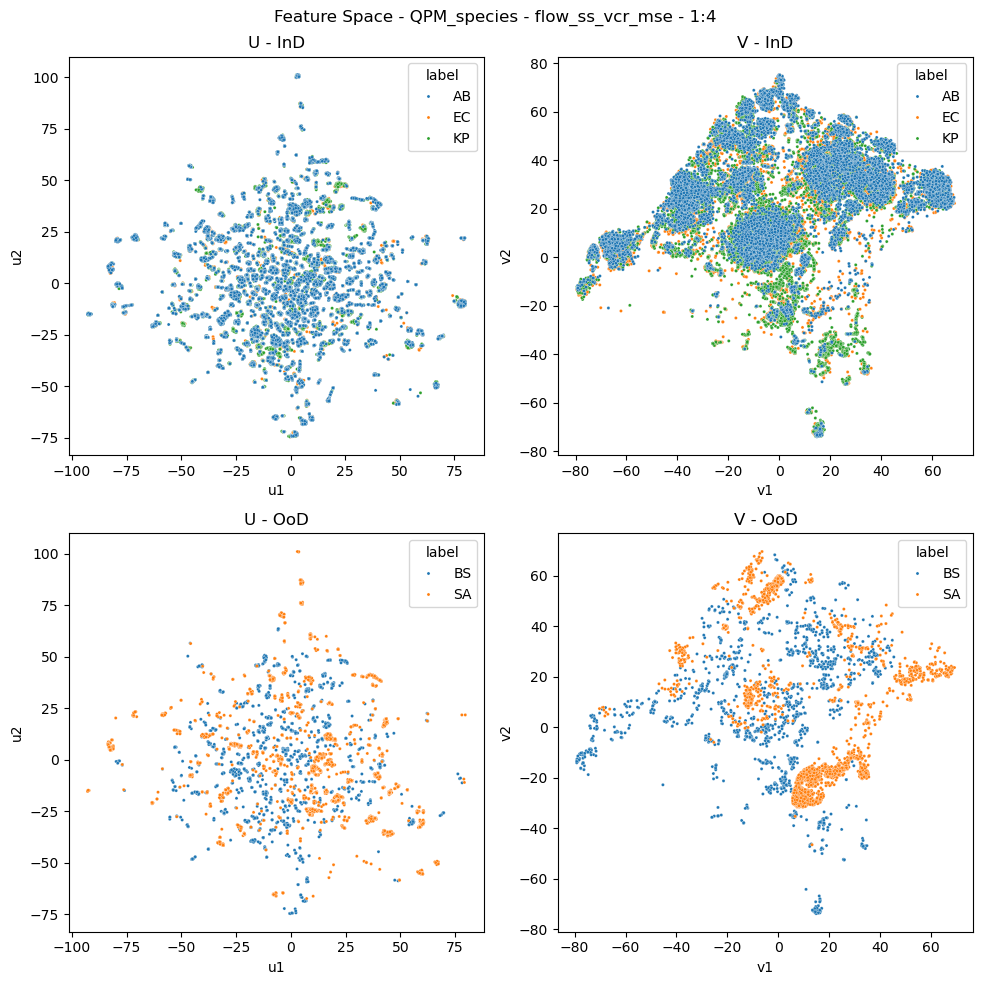

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
emb_data = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
emb_data = pd.concat([emb_data, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    emb_data = pd.concat([emb_data, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")

sns.scatterplot(data=emb_data[(emb_data['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=emb_data[(emb_data['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=emb_data[(emb_data['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=emb_data[(emb_data['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)

plt.tight_layout()
plt.show()

  0%|                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████▊                                                                                                     | 1/4 [00:15<00:45, 15.15s/it]

 50%|███████████████████████████████████████████████████████████████████▌                                                                   | 2/4 [00:30<00:30, 15.09s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 3/4 [00:45<00:15, 15.15s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:00<00:00, 15.32s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:00<00:00, 15.25s/it]

  0%|                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████▊                                                                                                     | 1/4 [01:35<04:47, 95.69s/it]

 50%|███████████████████████████████████████████████████████████████████▌                                                                   | 2/4 [03:11<03:11, 95.83s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 3/4 [04:47<01:35, 95.70s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:23<00:00, 95.86s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:23<00:00, 95.82s/it]

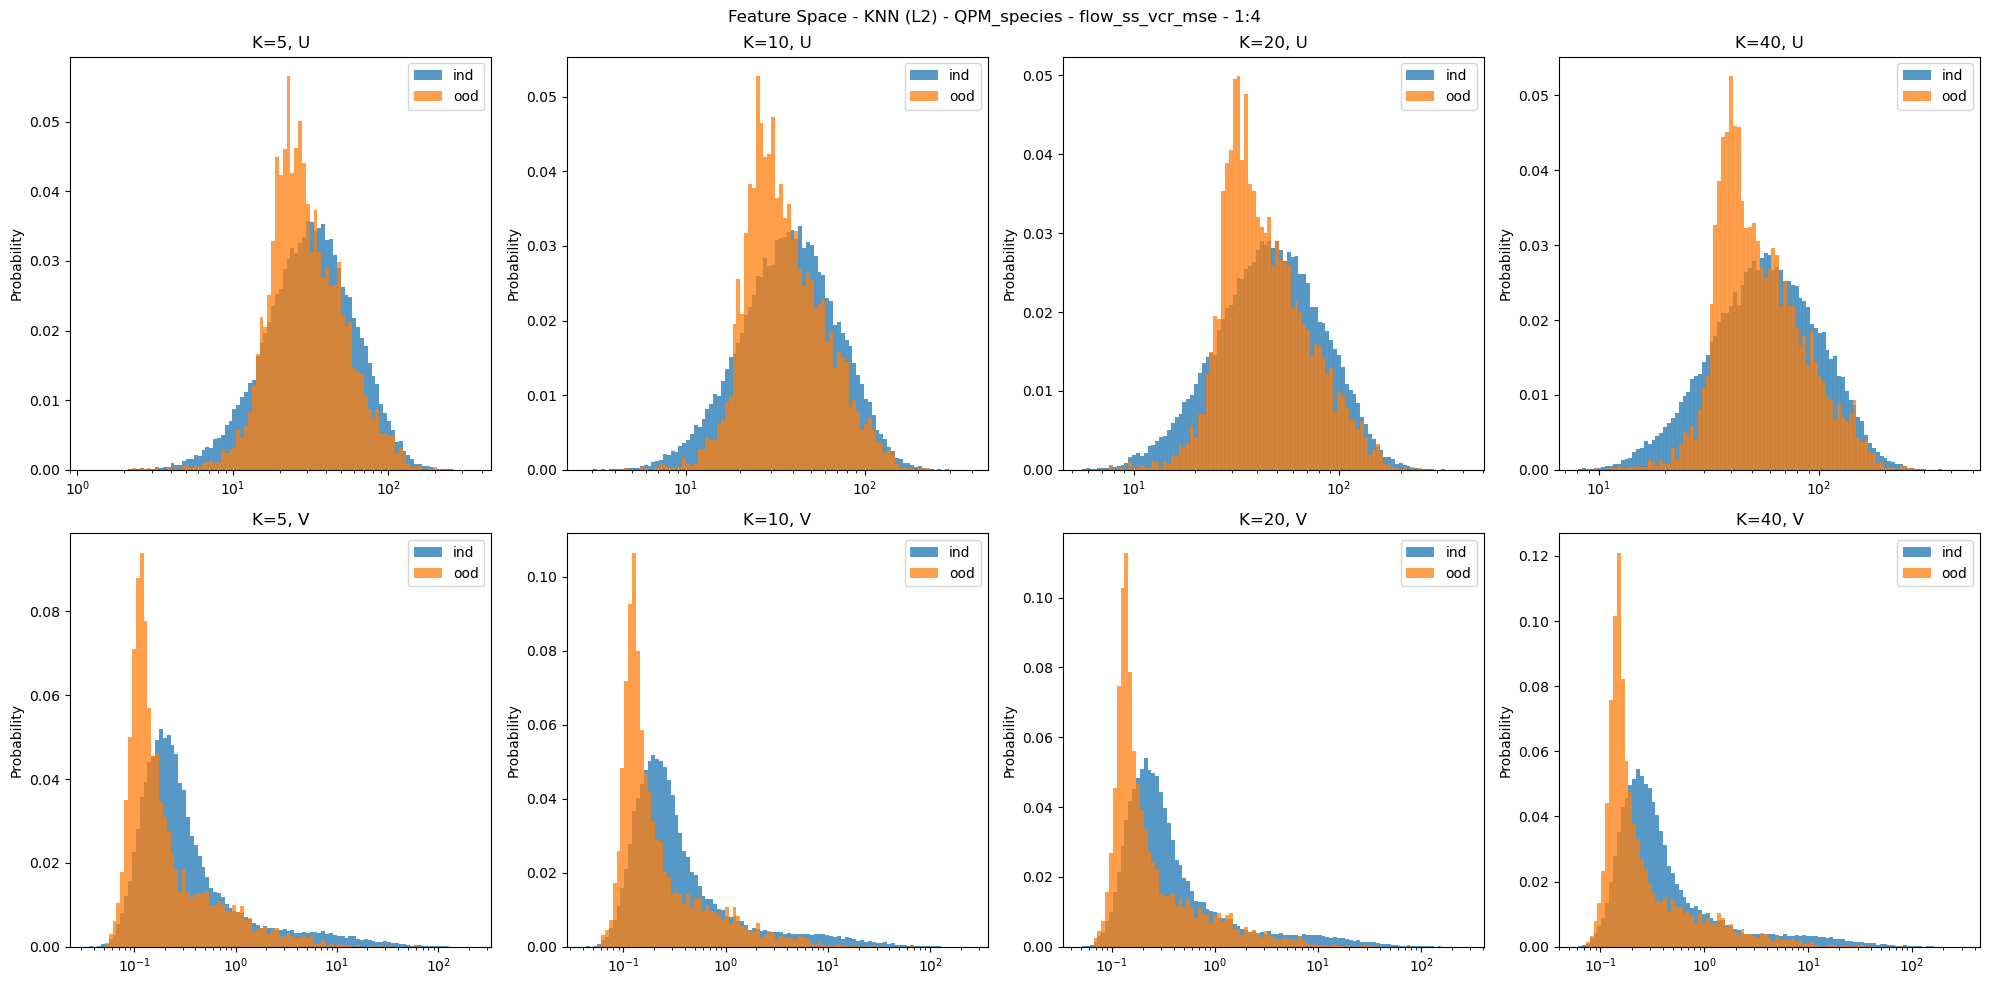

In [14]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

index_e_u = faiss.IndexFlatL2(ind_e_u.shape[-1])
index_e_u.add(ind_e_u)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_u.search(ind_e_u, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_u.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index_e_v = faiss.IndexFlatL2(ind_e_v.shape[-1])
index_e_v.add(ind_e_v)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_v.search(ind_e_v, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_v.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████▊                                                                                                     | 1/4 [00:14<00:43, 14.64s/it]

 50%|███████████████████████████████████████████████████████████████████▌                                                                   | 2/4 [00:29<00:29, 14.66s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 3/4 [00:44<00:14, 14.73s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:59<00:00, 14.90s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:59<00:00, 14.82s/it]

  0%|                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████▊                                                                                                     | 1/4 [01:34<04:43, 94.40s/it]

 50%|███████████████████████████████████████████████████████████████████▌                                                                   | 2/4 [03:08<03:08, 94.48s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 3/4 [04:43<01:34, 94.54s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:18<00:00, 94.78s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:18<00:00, 94.67s/it]

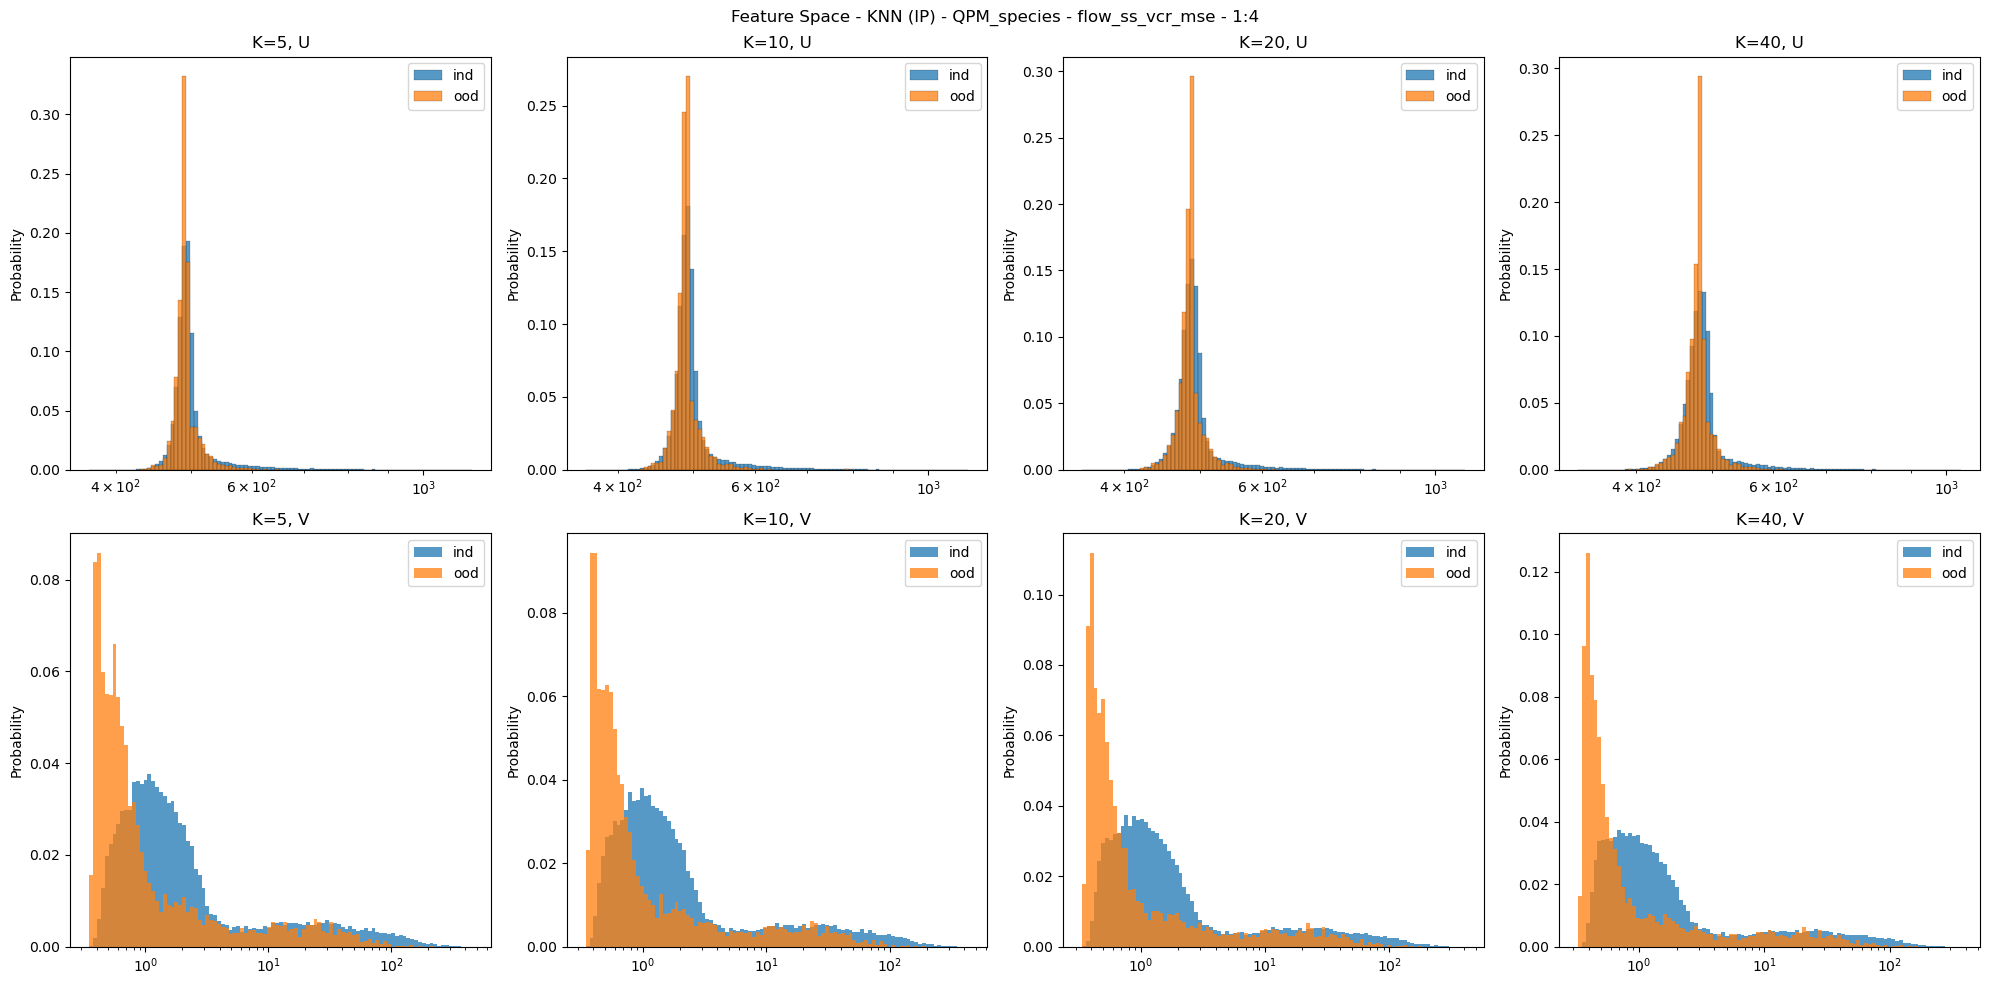

In [15]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

index_e_u = faiss.IndexFlatIP(ind_e_u.shape[-1])
index_e_u.add(ind_e_u)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_u.search(ind_e_u, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_u.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index_e_v = faiss.IndexFlatIP(ind_e_v.shape[-1])
index_e_v.add(ind_e_v)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_v.search(ind_e_v, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_v.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

In [16]:
from scipy.linalg import norm

trn_n_u = norm(trn_e_u, axis=-1)
trn_n_v = norm(trn_e_v, axis=-1)
val_n_u = norm(val_e_u, axis=-1)
val_n_v = norm(val_e_v, axis=-1)
ind_n_u = norm(ind_e_u, axis=-1)
ind_n_v = norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = norm(ood_e_u, axis=-1)
    ood_n_v = norm(ood_e_v, axis=-1)
rnd_n_u = norm(rnd_e_u, axis=-1)
rnd_n_v = norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

22.726309 0.6907684 1.449675 1.6621493
22.684023 0.6252567 1.3473644 1.5071396
22.766287 0.76974195 1.5448492 1.8371578
22.573177 0.35660568 1.0626929 1.0273799
33.40082 0.88363487 54.17184 0.7425323


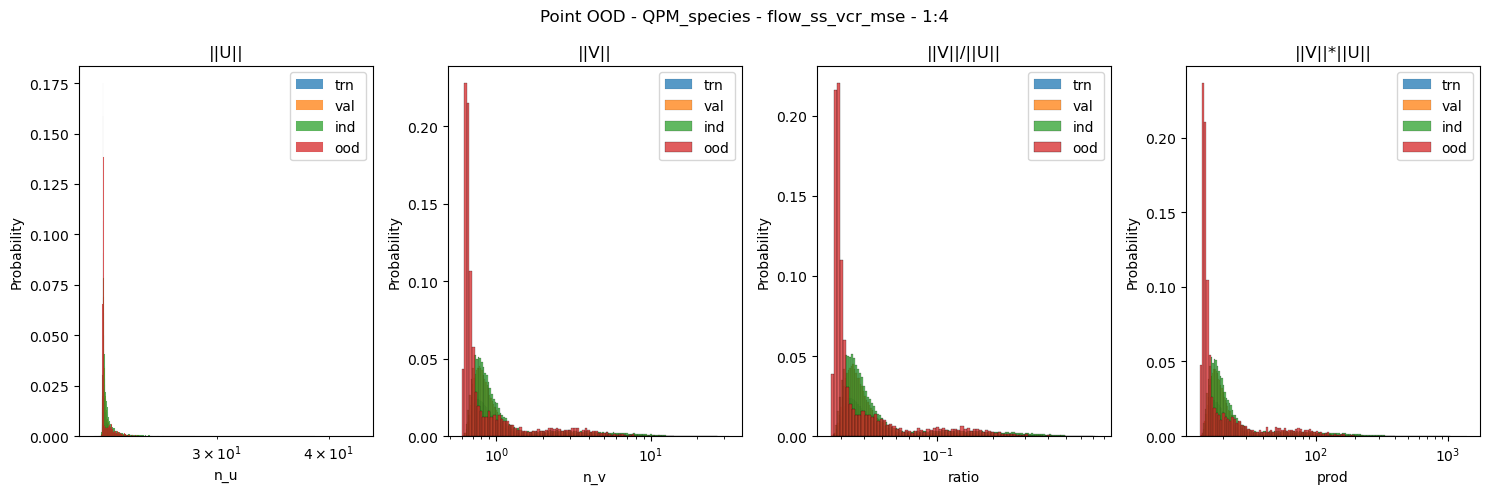

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='density', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [18]:
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


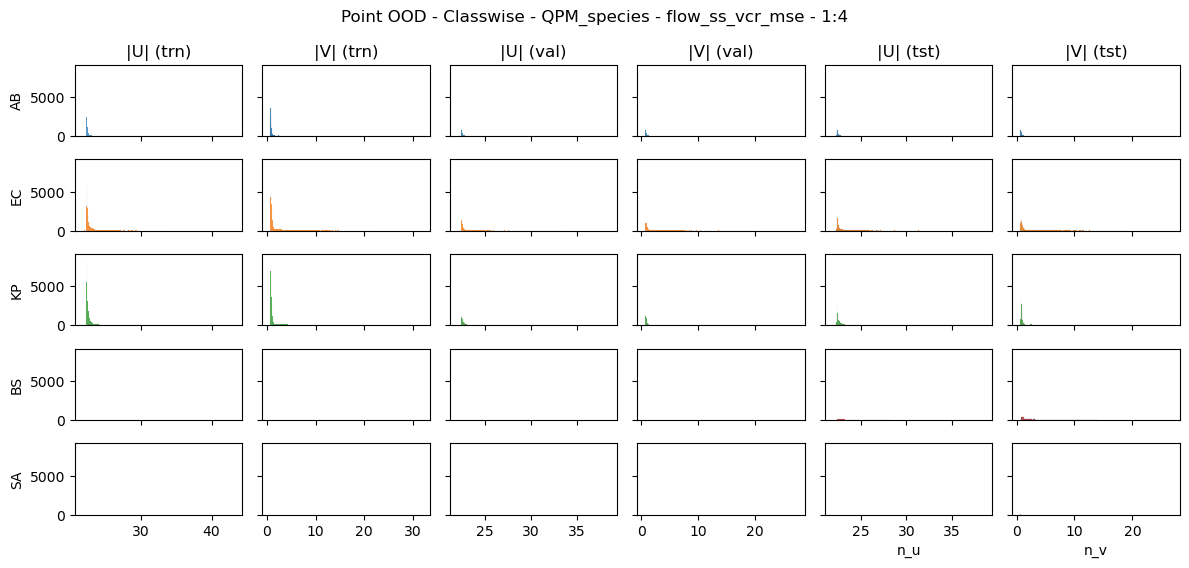

In [19]:
# pointwise
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='all')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

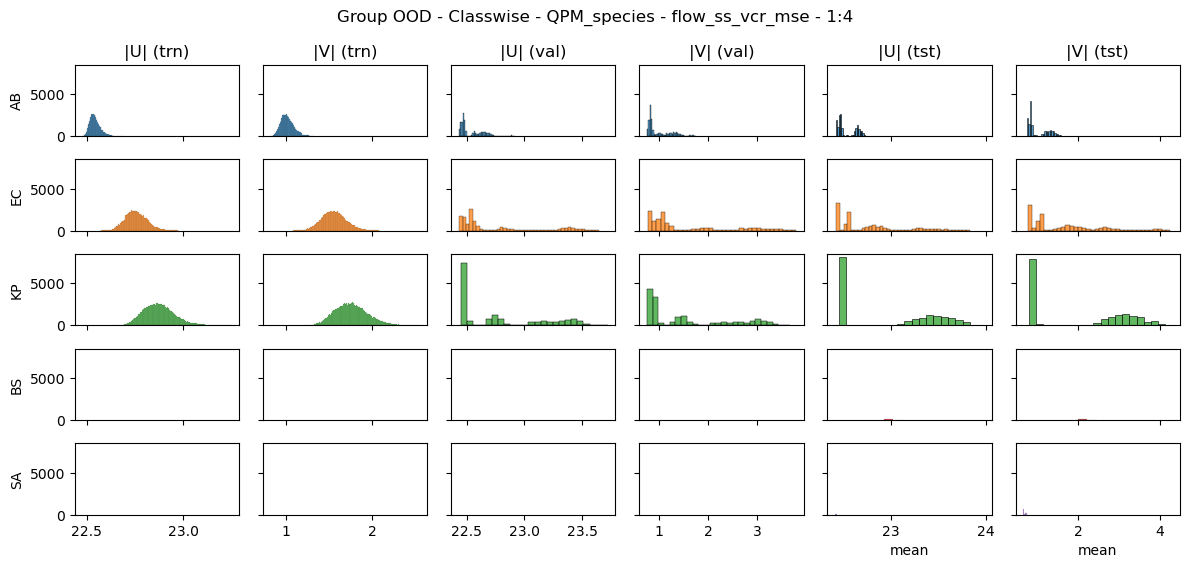

In [20]:
# groupwise
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='all')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()